# Page Rank
PageRank is widely recognized as a way of detecting influential nodes in a graph.
It is different to other centrality algorithms because the influence of a node depends on the influence of its neighbours.

The underlying mathematics of PageRank is based on random walks on networks.
We can think of a random walk as the way that a person might manually traverse a graph.
We start from any node and then either follow one of its relationships to another node or jump to another node in the graph and continue our exploration.
The PageRank of a node is the probability that it is visited during this random walk.
More influential nodes will be visited more often.

First we'll import the Neo4j driver and Pandas libraries:


In [13]:
from neo4j.v1 import GraphDatabase, basic_auth
import pandas as pd
import os

Next let's create an instance of the Neo4j driver which we'll use to execute our queries.


In [14]:
host = os.environ.get("NEO4J_HOST", "bolt://localhost") 
user = os.environ.get("NEO4J_USER", "neo4j")
password = os.environ.get("NEO4J_PASSWORD", "neo")
driver = GraphDatabase.driver(host, auth=basic_auth(user, password))

Now let's create a sample graph that we'll run the algorithm against.


In [15]:
create_graph_query = '''
MERGE (home:Page {name:'Home'})
MERGE (about:Page {name:'About'})
MERGE (product:Page {name:'Product'})
MERGE (links:Page {name:'Links'})
MERGE (a:Page {name:'Site A'})
MERGE (b:Page {name:'Site B'})
MERGE (c:Page {name:'Site C'})
MERGE (d:Page {name:'Site D'})

MERGE (home)-[:LINKS]->(about)
MERGE (about)-[:LINKS]->(home)
MERGE (product)-[:LINKS]->(home)
MERGE (home)-[:LINKS]->(product)
MERGE (links)-[:LINKS]->(home)
MERGE (home)-[:LINKS]->(links)
MERGE (links)-[:LINKS]->(a)
MERGE (a)-[:LINKS]->(home)
MERGE (links)-[:LINKS]->(b)
MERGE (b)-[:LINKS]->(home)
MERGE (links)-[:LINKS]->(c)
MERGE (c)-[:LINKS]->(home)
MERGE (links)-[:LINKS]->(d)
MERGE (d)-[:LINKS]->(home)
'''

with driver.session() as session:
    result = session.write_transaction(lambda tx: tx.run(create_graph_query))
    print("Stats: " + str(result.consume().metadata.get("stats", {})))

Stats: {}


Finally we can run the algorithm by executing the following query:


In [16]:
streaming_query = """
CALL algo.pageRank.stream('Page', 'LINKS', {iterations:20, dampingFactor:0.85})
YIELD node, score
RETURN node.name AS page,score
ORDER BY score DESC
"""

with driver.session() as session:
    result = session.read_transaction(lambda tx: tx.run(streaming_query))        
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())

df

,page,score
0,Home,3.233877
1,About,1.060435
2,Product,1.060435
3,Links,1.060435
4,Site A,0.329035
5,Site B,0.329035
6,Site C,0.329035
7,Site D,0.329035


As we might expect, the Home page has the highest PageRank because it has incoming links from all other pages.
We can also see that it's not only the number of incoming links that is important, but also the importance of the pages behind those links.

In [17]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:600px;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>


In [18]:
from scripts.vis import generate_vis

query = "MATCH (p1:Page)-[r:LINKS]->(p2:Page) RETURN *"
labels_json = {'Page': {'caption': 'name', 'size': 'pagerank'}}
relationships_json = {'LINKS': {'thickness': 'weight', 'caption': False}}

generate_vis(host, user, password, query, labels_json, relationships_json)



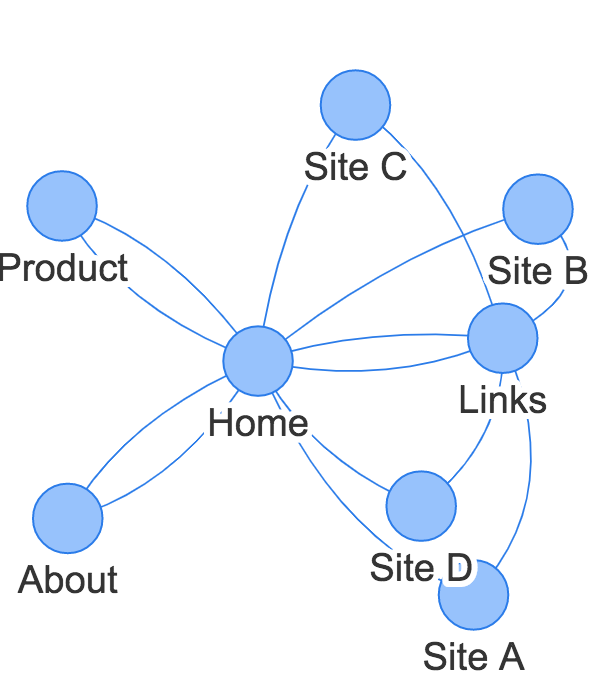

In [21]:
%%html

<img id="viz-image" width="300" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAlgAAAK8CAYAAAAzs8FIAAAgAElEQVR4XuydB3ib1fX/v1eWnYSQSSI5YYaZWA4Js9AfYZXRlhJCWyijZZRR2jL/ZSWWqcBymC2rKaUj7FlGUqDQstKGlpaZgOSEMsNILCVkAhmWdf7PeS05sixZw9r63ufJk8S6773nfu6136/PPfdcAxYSIAESIAESIAESIIGcEjA5bY2NkQAJkAAJkAAJkAAJgAKLi4AESIAESIAESIAEckyAAivHQNkcCZAACZAACZAACVBgcQ2QAAmQAAmQAAmQQI4JUGDlGCibIwESIAESIAESIAEKLK4BEiABEiABEiABEsgxAQqsHANlcyRAAiRAAiRAAiRAgcU1QAIkQAIkQAIkQAI5JkCBlWOgbI4ESIAESIAESIAEKLC4BkiABEiABEiABEggxwQosHIMlM2RAAmQAAmQAAmQAAUW1wAJkAAJkAAJkAAJ5JgABVaOgbI5EiABEiABEiABEqDA4hogARIgARIgARIggRwToMDKMVA2RwIkQAIkQAIkQAIUWFwDJEACJEACJEACJJBjAhRYOQbK5kiABEiABEiABEiAAotrgARIgARIgARIgARyTIACK8dA2RwJkAAJkAAJkAAJUGBxDZAACZAACZAACZBAjglQYOUYKJsjARIgARIgARIgAQosrgESIAESIAESIAESyDEBCqwcA2VzJEACJEACJEACJECBxTVAAiRAAiRAAiRAAjkmQIGVY6BsjgRIgARIgARIgAQosLgGSIAESIAESIAESCDHBCiwcgyUzZEACZAACZAACZAABRbXAAmQAAmQAAmQAAnkmAAFVo6BsjkSIAESIAESIAESoMDiGiABEiABEiABEiCBHBOgwMoxUDZHAiRAAiRAAiRAAhRYXAMkQAIkQAIkQAIkkGMCFFg5BsrmSIAESIAESIAESIACi2uABEiABEiABEiABHJMgAIrx0DZHAmQAAmQAAmQAAlQYHENkAAJkAAJkAAJkECOCVBg5RgomyMBEiABEiABEiABCiyuARIgARIgARIgARLIMQEKrBwDZXMkQAIkQAIkQAIkQIHFNUACJEACJEACJEACOSZAgZVjoGyOBEiABEiABEiABCiwuAZIgARIgARIgARIIMcEKLByDJTNkQAJkAAJkAAJkAAFFtcACZAACZAACZAACeSYAAVWjoGyORIgARIgARIgARKgwOIaIAESIAESIAESIIEcE6DAyjFQNkcCJEACJEACJEACFFhcAyRAAiRAAiRAAiSQYwIUWDkGyuZIgARIgARIgARIgAKLa4AESIAESIAESIAEckyAAivHQNkcCZAACZAACZAACVBgcQ2QAAmQAAmQAAmQQI4JUGDlGCibIwESIAESIAESIAEKLK4BEiABEiABEiABEsgxAQqsHANlcyRAAiRAAiRAAiRAgcU1QAIkQAIkQAIkQAI5JkCBlWOgbI4ESIAESIAESIAEKLC4BkiABEiABEiABEggxwQosHIMlM2RAAmQAAmQAAmQAAUW1wAJkAAJkAAJkAAJ5JgABVaOgbI5EiABEiABEiABEqDA4hogARIgARIgARIggRwToMDKMVA2RwIkQAIkQAIkQAIUWFwDJEACJEACJEACJJBjAhRYOQbK5kiABEiABEiABEiAAotrgARIgARIgARIgARyTIACK8dA2RwJkAAJkAAJkAAJUGBxDZAACZAACZAACZBAjglQYOUYKJsjARIggb4INMwITq6pMcO0TqeED9a/jTHDIZgMgwUislq/VmNs8/TvjprQksWeMR+RKgmQQHkRoMAqr/mitSRAAmVGQAUVbHKMAaYBmNwP8xcYyJ3hsO0fbTMdC/rRDh8lARIoAAEKrAJAZhckQALVRaChqf0YA6OC6mAY7BA7+lFD7Bhg7/rRu/VIu/X3ALsNo4bUYMW6TmwMha2vfbYyZP29dkMn1q3v+lp3EXwEm5kj4fC8ttb6udVFl6MlgfIgQIFVHvNEK0mABMqAgKspeCognlhRNWSQDVuPqMWOjjrrTzZlY0jw2coOfBDcZP3ZFJKeYgvG42913JVN23yGBEggPwQosPLDla2SAAlUEYEJ7sA0m+DGqLBSL9WOji5Rpf/OdVmxLmQJrUVLN8Z6txYYhC/yecdYsVssJEACxSVAgVVc/uydBEigjAk0upcdLKj5JSBWsLp6q/bdaQtMGDugYKNSkfXK+1/FCC0zz6DzSgqtgk0BOyKBhAQosLgwSIAESCALAq6mwB0wOE0frbMbTBk/uKDCKt5kFVkLlmzYvH1ozE3+FsdFWQyNj5AACeSAAAVWDiCyCRIggeohMNmzanhHaNOLeiJQhdXk7Qdi0vaDugPXi0lCY7UWLlmvQks2hcQAZl6tvfbYBZ4RVuoHFhIggcIRoMAqHGv2RAIkUOYENOWCqZHHIdhBtwOPmjwkLzFW/cWkMVqPvbo26s1aIGFzOlM79JcqnyeBzAhQYGXGi7VJgASqlIAGstcYc5eIDNXA9WP3GVoSXqtk06HerMdfXQsVW5rtwSB8DOOyqnTxcthFIUCBVRTs7JQESKCcCDS62y8QmJvU5vFjB+Cwxi3LwnwVWfMXf4nFSzda9ooxp7e1OO4sC+NpJAmUOQEKrDKfQJpPAiSQXwINzcHTjMgd2suU3QZj0vYD89thHlrXAPhX3l9PkZUHtmySBJIRoMDi2iABEiCBJAS60jDYNKAd32jcsqinBPs7SZrO4XnfF3rv4dpwJw5iTFZ/ifJ5EuibAAUWVwgJkAAJJCCgAe02G+YJZNi+Ow2y8luVe3nO94W1XWiANXZ73Q48XVjuM0r7S5kABVYpzw5tIwESKAqB2FQM5RRzlQ4sDXz/bFWHVl1Qa687hCIrHWqsQwKZE6DAypwZnyABEqhwAi538EXNzl4OpwUznYoepwsFd/pbnadn2gbrkwAJpCZAgZWaEWuQAAlUEYFGd8AjwC81ieipB44o6VQM2U5LbJ4sA1zp8zo92bbF50iABBIToMDiyiABEiCBCIHI1uCHAIYfu/dQbD2ytmLZfLayA4+/tlbHt7rWXjeOW4UVO9UcWJEIUGAVCTy7JQESKD0CLndAc0SdOs5RZ2Vpr/QSjceiF6vSZ5rjKwYBCqxiUGefJEACJUdgvGfZDjUhm3qvcMqUERg6yFZyNubaoKgXy8CsCdk7Jy/2jPko132wPRKoVgIUWNU68xw3CZBADwKN7sDjAkyrtFODqaY5mroBwF1+r/O0VPX5OQmQQHoEKLDS48RaJEACFUwgmlC0kgPbk03f2vVh3D1/lfVxpz08jl6sCl7oHFpBCVBgFRQ3OyMBEihFAq7mwBwIjqmUhKKZMqYXK1NirE8CqQlQYKVmxBokQAIVTCByctBy4Zx16MiKTMuQavpivFir/V7niFT1+TkJkEBqAhRYqRmxBgmQQAUTmOAOTLMBj2tS0RP2H1bBI+17aA++vAaaH8sgfIjPO2Ze1YLgwEkgRwQosHIEks2QAAmUJ4FoaoYpuw3GpO0HlucgcmD1/MVfYuHHGwCYm/1ex4U5aJJNkEBVE6DAqurp5+BJgARc7oBuDw5X75V6saq1dCceFXzkb3WOq1YOHDcJ5IoABVauSLIdEiCBsiPQMCM42djkzSGDbDh1CkOPfv/CSmwKCU8Tlt1KpsGlSIACqxRnhTaRAAkUhED03sFJ2w3ElPGDC9JnKXfSfZpQ5CJ/a/1NpWwrbSOBUidAgVXqM0T7SIAE8kagwd0+z8Ac9O3JQ7Cjoy5v/ZRLw4uWbsTzvi/UXCYdLZdJo50lS4ACq2SnhoaRAAnkm0BUYFX6xc7pcozGYQnkH23e+oPTfY71SIAEehOgwOKqIAESqFoCrqbAhzDYoVruHkw10RRYqQjxcxJInwAFVvqsWJMESKDCCLjcAdEhnXvEVhU2suyGszEk+MMLK2GANT6vc3h2rfApEiABJUCBxXVAAiRQtQQosHpP/W/+/rn1Rb/XyfdD1X5ncOC5IMBvoFxQZBskQAJlRyCaoqHaM7jHTxwFVtktZRpcogQosEp0YmgWCZBAfgk0upcdLLC9uPWIWhy7z9D8dlZGrT/+6lp8tqqDV+aU0ZzR1NIkQIFVmvNCq0iABPJMgAIrMWAKrDwvPDZfNQQosKpmqjlQEiCBWAJRgcUtwp7rQoPcNdi91l43YoFnxGquGhIggewIUGBlx41PkQAJVAABBrn3nkTGYFXAwuYQSoIABVZJTAONIAESKAYBCqye1KNpGgCs9Xudw4oxJ+yTBCqFAAVWpcwkx0ECJJAxAZc78BGA7ZlotAsdE41mvIT4AAkkJUCBxcVBAiRQtQR4VU7PqafAqtpvBQ48DwQosPIAlU2SAAmUBwEKrJ7zxMuey2Pd0sryIECBVR7zRCtJgATyQMDlDt4EyAWTthuIKeMH56GH8mryOd8XWLx0IyBykb+1/qbysp7WkkBpEaDAKq35oDUkQAIFJMBUDT1h3z1/FdauD0PCZo+2mY4FBZwKdkUCFUeAAqvippQDIgESyIRAozuwWoBh1R7ovmJdCA++vEbRLfF7nTtkwpB1SYAEehOgwOKqIAESqGoCLnfgTgCnTtltMCZtP7BqWbzy/ld45f31Ov67/F7naVULggMngRwRoMDKEUg2QwIkUJ4EGpqDpxmRO8Y56nDU5CHlOYgcWK3eK/VihYFjF3mdc3LQJJsggaomQIFV1dPPwZMACUz2rBreEdq0SkmcdehIDLBX349FjbvS+Cstfq+z+gDw24AE8kCA30h5gMomSYAEyouAyx3QgO5J1bpN2L09aDDX3+KcVl6zR2tJoDQJUGCV5rzQKhIggQISiJ4mVO/VKQeOqCovll6Pc/c/V1kXPBuED/F5x8wrIHp2RQIVS4ACq2KnlgMjARLIhEA06ei+Ow3CvjttkcmjZV23O/cVvVdlPY80vvQIUGCV3pzQIhIggSIQqEYvVmzsVac9PG6xZ4zezchCAiSQAwIUWDmAyCZIgAQqg0A0ZcP4sQNwWOOWlTGoPkbR7b1iaoaKn2sOsPAEKLAKz5w9kgAJlCiB8Z5lO9SEbB+qeSfsPwyjhthL1NL+mxW92NnArAnZOyfTe9V/pmyBBGIJUGBxPZAACZBADIGoF0vF1bH7DK3IgHcNaH/o5dXWtTgGuNLndXq4CEiABHJLgAIrtzzZGgmQQJkTiOTF0pN0k7YeWYtj9x5a5iPqbX40qSiAhX6vc3LFDZADIoESIECBVQKTQBNIgARKi4BuFdpDNQsEMmzSdgMxZfzg0jKwH9Y87/sCi5ZuBGBW1dprd1zgGbG6H83xURIggSQEKLC4NEiABEggAYGGGcHJxiZv6kffaNwSE8YOKHtOC5dswPx3voSBEYEYMeaWthbHBWU/MA6ABEqQAAVWCU4KTSIBEigNAtF7CtWacg96/yC4CX9dsM4Ca2xyZjhsrjTA1jB41N/i/H5pEKcVJFA5BCiwKmcuORISIIE8EHC5gzcBcoFmeVdP1o6Oujz0kt8mdUtQtwatInKRv7X+Jv2nyx3w6V8AXvJ7nVPyawVbJ4HqIkCBVV3zzdGSAAlkQSB6slAf1Xgsjcsql6Jbgro1GCl3+b3O02Jtd7kD/wLwdQDv+r3OXctlXLSTBEqdAAVWqc8Q7SMBEigJAq6m9gthzI1qjMZjqTerlIumYlCvlW4NWo4rY05va3Hcmchmlzv4Z0C+D5i1oU1mm3euG921l8hCAiSQNQEKrKzR8UESIIFqIzDBHZhWA9wtwJBSzpOl+a003mrFuhBgzFojncekusS5sTlwvQgu1jm1dXZOePvqsYurbX45XhLIJQEKrFzSZFskQAIVT0BPF9ps8qQAWw8dZLMuhtardUqlLF66EfMXfwn1YGmeKwmb09pmOhakY19D07JzjbHdaoksMQe93er4ZzrPsQ4JkEBvAhRYXBUkQAIkkCEBV3PwDoh0xzJpQtJ9dxwE/btYRa++ed7/hZWd3SoGc2tr6k7LNM9Vo7v9OwLzhCWyTOfeb7eMfb1YY2K/JFDOBCiwynn2aDsJkEDBCbjc7VMBM9cA94WNec6I6DUz26shKrCm7LZFQe8wVGH1ygfroX9HyhIxxpMs3iodYK4rAkcijGe0bg1s49/yjn4nnedYhwRIYDMBCiyuBhIgARJIl4BHbK5QcD6AiSaMA3wznW/po43ugIqsCwUYpv/XIHgVW+McdXm5y1C3/z4MbrIyskeFlQBrVOxFUzCkO6Rk9VxNge/B4BH93C412yxsHfVZf9vk8yRQTQQosKpptjlWEiCBfhFoaGqfYYxphUizv7XeG9uY3mEYCm1SkfXL2K+r0NLcWeNG10FjtrItGrD+2aoQFn22sSt4PVJUWNmAm+z2upsy3Q5MZYurOXAKBHdpvVr7VyMWeMbxWp1U0Pg5CUQIUGBxKZAACZBAGgQaZwR2FxvmA+YdsS8/oM3j6sp/EFf0HsOaDjNNDKYZmINiP1aBNWRQDYYO7Ppby+ghNair3fyjeFOHYPm6Tuuzdes7sXZDuOvvaGxVtEGDuQjLvNraAXfmWljF2uxqDvwMglmWrXZH7TyP2azu0uDGKiRQrQQosKp15jluEiCBjAi43IH7AJwEmOP8Xoe1dZaqqFdrY2jTwTZgmkAFV9cWYpZlCYB5YWDOAHvdvHyKqnj7XE2BS2FwLYCw3+vsUoYsJEACfRKgwOICIQESIIEUBFzN7SdBjAqse/xe5ynZAutK8dA5PGxqdrCJ7KDtiMFkERkebdMYs9oIrLQKYWM+sknnR+Fwzep0Uy1ka1uq51zNgSshuEKTkfq9jv4IxVRd8XMSqAgCFFgVMY0cBAmQQL4I7Oz5fOiAUGi+ANtLWA5YNLNe7++ryuJqDvwKgv8HYJnf6xxblRA4aBJIkwAFVpqgWI0ESKA6CTQ2B1tFZIYRafK11s+sTgqbR+1qCtwOg7N5d2G1rwSOPxUBCqxUhPg5CZBA1RJobAp8XYwGtuPV0XbHAQzw7loKje7AvQKcDJg3/V7HnlW7QDhwEuiDAAUWlwcJkAAJJCHgcgfmAphqgO/5vM7HCCrGk9UcmAPBMQBe8nudU8iGBEigJwEKLK4IEiABEkhAoKGp/WxjzO0A7vJ7nd3X4hBWjMhqCjwHg28AeMbvdX6LbEiABDYToMDiaiABEqg4AiJyBoBDALgAjIgMsB7ABgDRZJmamfxDAC8aY/4UC2E3z/Kx9s7wfAhGzDp56GUHjR+4E4C94kC9B2CJMeaaSgIoIpcD2A/AYADbAhgIIHrKMZadZrF/rbE5cBZgvgaYR/xex3GVxIJjIYH+EKDA6g89PksCJFAyBETkSAAXA9gdgCNDw4IAXgZwmzHmb43NwZtF5Py//2LUx2OH27ZL0ZY+e2NUaImI5ovSrTMVJlpWAfhNvIjL0L68Vo+w+xGAw7Ng986TCzeMvvyRtSPp7cvrNLHxMiNAgVVmE0ZzSYAEehMQkd8BOAH9S+SpDW/8dGXnv1qeWHfo9ccP6xg6yNRmwPu/ANRLZl38nKC8Y4wZn0F7ea8aEVbqgZsAYEB/OgyuDYfu/+9X9j/+86tZfq/z3P60xWdJoBIIUGBVwixyDCRQpQQiAkHjpJKJmqzIbAoJ6ux5+fG4wBizR1ZG5fihyFagbgfmNGnoy+9vwll3rrnW73Vo2ywkULUE8vITpGppcuAkQAIFIxARV3dnsaVVMBuTdHS/MebkYhohInMi25h5MWPxshCOm7XyEl+r84a8dMBGSaAMCFBglcEk0UQSIIHeBETko1Seq02bNiEYDGLVqlXQf2upq6vDVlttZf0ZMKBfu2LZTkvQGOPM9uH+PicibwKYnKqdr776Cp9//jlWr17dza62thajRo2Cw+GA3W7vswlLZP125ZE+r/Pvqfri5yRQiQQosCpxVjkmEqhwAiLybwD7JxqmiOC1117Do48+iueff75PEgcccACOPfZY7L///lDxkKxom7feeivuv/9+S5ip+JgzZw6GDUu+u7ZmzRoMHjw4oRAxxhTlZ6+IPAdYaRUSls7OTvzrX//CQw89hFdeeSUpj5qaGpx88sk4/vjj4XQm14r/+WATfnLPF9u+5dnq0wpfkhweCfQiUJRvcs4DCZAACWRLIJKC4Y+Jng8EAjjzzDPR3t6eUfPq1frjH/+ICRM01rt3UYE1ffr0bsGm9Z988kmMGBHNALH5GRUpKr6uueYa/P73v8cee/QOuUomsEQkUcoHTSPxt4wGlHgMGhN1dbLxPfXUU7j66qu7vVXp9nfGGWfgrLPOgoquRGX2/K9wzwuv1M7zHBJKt03WI4FKIECBVQmzyDGQQBUREJEFACbFD3np0qU47rjjMhYIse386U9/wu67a5aHnkUFVlNTE5599lnrAxVYf/3rX3t5sD744AP89Kc/xcqVK616yQQWgG+qaIqIRT39mCq1xBoAfs2aboy5LNPpjsSrPZQooF23Ti+66KI+PVap+hs7dqzl3VOPXa95Wd2JI3/1uc/ndU5M1Q4/J4FKIkCBVUmzybGQQIUTSOa9CoVCOPHEE/HRRxqWtbmoV+X000/HXnvtZW3tadF4rFdffdXyWMUXFU6PP/64FWMUW1RgnXPOOXjjjTe6BVYiD9YjjzyCa6/VNFhdpQ+BtR7AuiwD9JcAeCgToZUs7iocDuOCCy7Af/7zn14sdtllF5xyyinYddddMWTIEHR0dODTTz+1vHNRoRn7UENDA2bPnp3Qk/XUWxtw2Z/XPOD31p9U4UuUwyOBbgIUWFwMJEACZUNARO4D0OslrXFDF154YY9x/OxnP7PihFQ0JSrquXnwwQet2KrY8v3vfx+XXdbbSfS///0Pn332WXes1te+9rVecVt/+ctf0NLSko7AygXzfxtj/i9VQ31tqf7ud7+Deu1iS319Pa677rqk26Va9+OPP8aMGTPwzjvv9HhWRahuGcaXz78Mrz/omhWDRMz0tlZHRWW+T8Wfn1cvAQqs6p17jpwEyo5AoiDt+O07HdQPf/hDyzOTTrnjjjvw29/+trtqsu2/dNoqsMBSk3S79PK+YrRExLqwOt7+RYsWWR6q2HLYYYehtbUVNpst5XDVa/jjH/8Y2k60KLu5c+daJw3jy9VPrgve99/1DsAc5/c6HknZASuQQJkToMAq8wmk+SRQTQREZDGA3WLHrNtcZ599NhYuXGh9ua+XfCJWGzduxLRp07BixYruj/vY2usT9zPPPIPm5ubuOireGhsb8z1Feh/iDsk6EZFA/FakMtMtVY0Zi5Ytt9wSTz/9NAYOjN7wk9rsDz/80DpJGFsuvvhi/OAHP+j18IZN8re9W5brdUYQMVPaWh0vpe6BNUigfAlQYJXv3NFyEqg6AiKi8Uc97gbUlAmaaiEaWL7FFltYJ/w0bijdoltif/7zn7urq0drn3326fG4bg9GTydqloXJkydbnh71oPl8Puvf6r3RGK5oUQ+PpoLQ7cgxY8ZAg8ETFf385ZdfxosvvggVLZqfS8elsWD77rsv1LOUyCsU09bzxpjD4tuOZGvvdXLw3XffxUkn9dxp/fWvf40pU6aki8yqp2P3er1Qz120bLfddhbLBF6w5ydeueJyCYVf1boG2Nnndb6fUYesTAJlRIACq4wmi6aSQLUTSCSw9CWv8Vf//remxuoqKpgOOeSQtHHpNpf+GT16tHUSTgO8YwVaX0HuKoSOOuoofPHFF332p8H2GhcWX+bPn4/LL7885enHVOkQANxujDkntv1k+cLit0W33XZbPPzwwymThyYaoHLTsWnsmopBTXWhHBOUj40x2ze6A98V4FEYWVyzHnu/dUP9l2lPFCuSQBkRoMAqo8miqSRQ7QQSCQYVP9dff30PD5SeHrzqqqssz0868USpuPaVpiHeg5asrZ/85CdWjq5o0TY1V9Zjjz2Wqvvuz9UDpuJo5MiRiZ7plSE+kSDV7UHdwos9cZlsW08vvwagRyffArBzX0lK0xjEX4wxx2g9V/PyCyHhGw3Mwz6vo/d+YhqNsQoJlDoBCqxSnyHaRwIkECtKEmYiTxSwrQ9pPNYll1xibX1F0zRkg7MvgaXB3uox0wSjL7zwQg9Plm7xff3rX7eumznyyCMtwadF21MBqFuZsUWFoQox9QKpR0y3HONTKGislObgGjRoUKKhXBebviGRwNqwYQOOOeaY7i1VbUTTK0ycmDBNVY97E0VE83ENzYYhgDONMd1HFl3uwK8BXGSAX/m8zouzbJOPkUDJEqDAKtmpoWEkQALxBJLFFKlg0ZQDKhSSFY1hUrGjsVWas0m9Qanu04u2lW6i0XSD3PUamp///Oc9TNUttvPPP7+XcNLYLP16bIn3hsV89o4xZnyM3RsA9LhwMT4wPcWpSSshakx7CdNkpLFSFxpjet1/6HIHHgXwXSPgxdBpQGSV8iJAgVVe80VrSaDqCSTyykS9QupJ0mSf6RT1Fn3nO9+xPEsasJ7qLsJ0Mrmnk6ZBt+g0nkoD46MlVVqJeA+dBvJrX4nuQoy9hkdUGcYVPTkYe8pPPWJPPPEE9O+4kvBS6kSnElPwTnq59e6edY5w6KvnBWiUMH7UNtN5bzpzxzokUA4EKLDKYZZoIwmQQDcBEfkdgJ8kQ6IeH4/H02MLLB18GiivqQsSxWyl68FKR2DFi6UUW37dpsefdOwjbsraJkyWYDReYO2555647bbbEo3bCkqPZxe5dufuNLPQJzzdGNtmo2f53hIK/0t3dMUmh7VdVd/3Dd3pTCbrkEAJEKDAKoFJoAkkQALpExARvRCwV0qC2BZUEOlW2D/+8Q/rahe9pzCdorFPmgMrPhdULgVW/HU6uv33ox/9KKV58akV+vB6WaIm2XZqvMDS7VINnE8gLJMJLL002hO/9djHADTd+wV9JUPtPlko+EBs4altLWP03kUWEihrAhRYZT19NJ4Eqtsw4qUAACAASURBVItAokzu6RDQ+wffe+89vP7661Yyzb4ElwoOvT4mNj4rlwLrgQcegOacipbvfve7VqJTvesvWVFb1P7Ya3j6EEbdXqNEW4TxQk1jsBLdq6g34iTxYOmFj708WynmYYExZo++6kRPFsLgX6gZONXvGdZ1YzYLCZQpAQqsMp04mk0C1UYgmUcmGw7Lly+3Mr/ff//9ePvtt3s1Eb/9liuBpe384he/gOa+6m/pY2uvO9A9kcAKBAJQUafJTbX0EeS+0RjTI617P+egO01DsrFHTxbC4FF/i/P7/WXE50mgmAQosIpJn32TAAmkTSBZ0sy0G0hS8bXXXsNPf/rTHp9q8PhTTz1lZVTXkkuBFRss3x/b09naSxSQnuhqoD7SNEw3xnRfzpxsDjRwX/+kOJWZNNg9loOrOfAYBMcaMU2+VsfM/jDisyRQTAIVK7Ame1YN7+wMTer64dg5OQwzXP9tYA6OBS6Qefp/G2S1MTV6cSpqauwLF3hGrC7mxLBvEiCBngSSnR70+/3Wlp9uA65btw6nnXYa9IRgJuXNN9+07jOMlvj7DPMpsNTWbHJ07brrrvjVr37VZ+xUssz306dPx/PPb44l7yNgPtYbpvcI6sXRPdI+RE9FavC+ZrTff//9sd9++yU6lah4e6R9SDRHu7uX79aJsOY728YAR/q8zr9nMpesSwKlQqCiBNZ4z7Id7CFzjMA2DZAeQipz4GaeQXhOyC5zF3vGaMwBCwmQQBEJpJM0U8WKxhOluLev1ygSXbcTe+FzLgVWvLjpw3uULe1YUaT3B+0f35AG/re2tnZ/WYP7NdA9iTDV5KL6C2d9osD2ZcuWYerUqT26+MMf/mClvogvsSkk+hpcQ1PgZGNwrwHeEPumw/2ebRmPle1q4HNFI1D2AqthRnCyqcGpCMs0GPS4UX7rEbUW2FFDajCgtmuo0a9FiX+2qiuwdGOHYMW6Tuvf0a91z4rgI9jMHOnEXW0zHZaXi4UESKCwBJJ5Y+JjmrK9tDh+6y4fAkuJxZ8izMbeFORjg9wTprT4+OOP8b3vfa9HM7fccovlfcq0xN9r2FfaiXQFltrgcrffBJgLIPi9v9WZNC1HpvayPgkUikDZCqxG97KDBTW/jPVU1dkNdnTUYeuRtdbfA+zZDW9jSPDZyg58ENxk/dkUis3Vp56tzit93jHW1iILCZBAYQgkOkGY6B5CjU1Sr1Am24R6gk+9MCtWrLAGE3+yLlceLG073nu09957Y9asWSnvTNTTf7qVt9NOO2GbbbaxLqTWLbkE6RV65J4SkV7Z3BN57FQY6QnL+BQVfc1uIqF28sknW5dvJyhpxWBFn9vBIwMHh4K6Vfh/gJzt99b/oTArjb30h4A6PWpqzLDOcOdwxGXvrzE2673Z2SlrqsFZkZ0C6Q/9fj7btQ1ou1GAadYPQrvBhLEDuoVVP5tP+PiKdSEs+mwjFi3dGCO2zLxOe+fp3D7MB3G2SQK9CYhIwmtaEt1DqBnam5ubU4qWaC/33nsvbr755u5ONchdxUY0u3u2AivRVpnGi+ldgLHlj3/8IyZNskJGE5ZEpw8PP/xwa5vPmF4/xuMFlnrdezX+v//9DyqGYsvRRx8Nt9udFjeNdzvppJPQ3t7e3YSK2oceegjbb58wi0PKU4Txg29oCh5gjMZjmS/EhA5va9n6TX5vlA6B7h0ksUJyeu8Jp2fqAgHmIGzmVproKhuBpUHrHR2bboTBaVFhNXn7gZi0/aCsPVXpzf3mWurZWrhkPRYs2bBZaAnu7KwNX0mhlSlN1ieBzAgkSxGQ6OoZbXm33Xaz8kaNGzcuaUdfffUVbr/9ditdQ2y5/PLLe2yhZSuwVLTp/YexJb4t6+dZXR0efPBBbLvttgltffbZZzFjxox0RVkPIZNMmCby/mkHe+yxh9XXDjv0iLjo0bceLDj33HN7XGytFfq4I1E/7nHZc7qz73K3XwSYX0PwN3+r85vpPsd6uSeg7+FNHRsPMjAakqNODuvwWGwZNcTe/U7eeqS9x2efrQxZ/9d3qTouehUNxwHmCWROW2u9Hqgo61IWAmuCOzDNBtwRnczxYwdg3522wNBBtqLA18XxyntfYeHH6nm3ymox5qK2FsedRTGInZJAlRBIdpIwkVcoisThcOC4446Dy+WyPDOaSkBzQf373/+2UjHEFxU56oWJvZswXYEVv/2nwunSSy+F3h2ogkW39bQk2lrTr2scmN6NOGjQIKuebllqYtK779abaTaXFNuKvU7qiYgGqg+NH6sKTI3Fim6Nxn6uQuv444+3hOrgwYOh6R3U63XfffdBT13GlxRbswkve0532brcgYj3Ulr93np3us+xXm4IWMIqtOkC05XBv7sMGWTDjqM3h+Vk05uG4VghOcs3Yd36cGwTqwW4qc5ed3O5nuoveYHV6G6/QGBuUurjHHWYstvgogmr+MWzdn0Y89/5Eh8GuxL2CeBp8zqvzGaR8RkSIIHUBETkWgCXJqqZaKswdYs9a6gQeuyxx3qlTUhXYPVlgwosFW7RmCndgrziiisSmqhC7Msvv0yYcT6ZjZGGEgqZvripOFUBGk08mikzrT927FjLC6hCLEnJynsVbavhsqXbmbqaZyHYVWw109quGlX23o1sOBf6mRhhpUF1lrdKD4ppjLO+j3Pt5FCvlnq5NBwnxsO12kA8Pm/95j38QoPIsr+SFliupsAd0S1BFVaTtu+RVDjLIef+MV0Mz/u+6GpYcGdtbd1F5aq4c0+HLZJAbgkk88ZoL0uWLLHyWa1cmfmpfk1VcNNNN2HkyJG9DFaBFZteIdn1MipSTjjhBHzyySe92tC4Lk0hERtErlf3nHPOOWkD0kB0FTJjxozJWMiIyGLdOU304Jo1a6CnCPWy6kzLGWecgbPOOquvQwX98l5F7dl8X6EstsN+2MLWUZ9laivrp0/A1RQ8FRBP9HS+Cqsp47eAbgEWoqhX65X3128+1W9tHxqPv9VxVyH6z0UfJSmwrHir0KYXNWhOg9gPa9zSUsylXHQxPLVgXTQ2a0Gtve4QiqxSnjHaVq4ERCRh6oHoeFQMLViwAE888YT1J1U54ogjcOKJJ1pbiAkCxrt+bxLBDTfcgIcfftj6v3qRVIyoaIovKu6uvPJKawsytiQTZbpNp9tumhYiWdFtzvPOOw9qa4JTg9HHEt4dGMPlDACz+rqkWQPW586da21JpvJonXLKKdYWotPp7AvxWgDH93XRc6r5if280d0+U2CmA7jH73WeksmzrJseAStw3SYakmMFrauw2nenQdbp/GIUfbc+5/8iZvuwfA6YlZzAsibXyOOqmnV/96jJQwqmmPu7eNSl+Zzvy6hrc7WEzSGVdiqiv4z4PAnkgkCywO34tjs7O6H3DkazvKv3KBQKWde6qDDQPyp88lFUOK1du9YSYxq/NHTo0O6rdxL1p4JGY7NU5ESvnNE4MI0JGz16dFLxF2lrIwBP7LU2ifpIl5sKSo1T0ySiulWptm/YsMHiptuB+ifFtTjR7ntctZMLzq7mwN8hONwYc4GvxXFLLtpkG10EuuKdzR2ADNf3r8Y66yn9Uii6U/TK+19FhVZZvF9LSmBFTgq+qeJK3ZDH7jO0YCcEc7WANAD+r2+ui7o1V9fa68bRk5UrumyHBDYTEJGE6QeqkFFa4irKJSKyNMtoPt+catOdxpj09z/TnLiJzcv3Cos8KxIeaIM5zNfq7OkqTLMdVutJIDbeWQ+STRk/uOTev/p+fc73xea4Z2NOL+XDZSUlsFzugB5NmVyu4ip2uT7+6tqoyOJ2IX+SkUCeCFBkWWAz9hJFUl7oibB8iKyMBF82S6PBHfiJAX5nYP4Zti8/vM3j6jppxJIVgdh4Z90OVM9VKZf5i7/cfIrfmJv8LY6LStHekhFY0QnWmKtTDxxRcso508lTpa0iyzoJIbjT3+o8PdM2WJ8ESCA1gcgJOfWU9EpDkPrppDX01MqW/Xi+EI+qkHnUGNMzW2iaPUdElsYz5ZLbxwCuMsb8KU0zsq7mag7+ASJnwuDX/hbnL7JuqIofjI93Vq9VqWwJppqW2MNlBphjt9edXmq7RSUhsFxN7RfCmBtVXH13n6FlE3OVagGouHrs1bVW4LsBrvR5nT1yiKR6np+TAAmkR2DeovVnDRpQ87t9x9X2Nzmeipa/GWOOSXQ1Tx/W6GXImqMgk0hgvYMrm5/BauNLAK7PRfC4iGjKgyP76c3SYPYnsxV76c1yz1q7epaOqg3V6FU6kyBykr+1/oFs2qnWZ+LFVTm+e2PfsYCZ5/c6Diml+czmmzun9keSiD6ujX6jccuyUc/pQtATEI+/pj97ACnx/eJ0x8R6JFBqBFzuwDUALvvZoYNv/Nkhg/VYmwvA+DRFgwoWTWHwn/iYoYiXR2+P0LwIiTw96rFZEBFkKlL0ZNsBALbrg5E+85KKkUg81F6AdVF9qu06/UHyaq6EVbx9kdOZeuVJOrbo48rNyrydj1irdNaYyx38JiBPa4aOMMzhi7yOd9N5jnWA6K6RBrOfsP/wst010nyUD768uusEf4ntFhVVYEUU9IeawKwc9n2z/aaMcWWu7rSH9+C1OtmS5HMk0JvA7p52R2fILADMarEvnxwbjxMRSCMAaD6FnWOe/jIiqvR03mX54BrTd7T5VX2d8otsdWpdFVzR8jqAPp/Lk+2a0mGfOGZFtSnZOF3uQLNuS8LgUX+L8/v54FFpbTa6Ax4Bflkpu0axnqxScmQUVWC53MGbALlA82zoicFKLpojK5Lx/S6/12ndp8hCAiTQfwKNzYGLRXC9EWnytdbP7H+LbKHcCLjc7XMBM1VEpre11qs3kyUJgYbm4GlGrDxX+PbkISWfYzLdiewZkxU+xOcdMy/dZ/NVr2gCa7xn2Q41IZt6r3DC/sMqJu4q2USpG/Pu+ausjzvt4XH0YuVrSbPdqiJwnNQ07hpcIAZbGwlN8rVu3TuFelUBqc7BuqYva0CN7Vm9tUeMObCtxTG/Okn0PWrNM2mzWZcpDyvl21GynbvNpwvNagmj6HkoiyawXO6AXox8qubb0Ezt1VCik68nHnxe57HVMGaOkQTySaDBHTzdQGaLyC1trfUX5LMvtl3aBBrcy043sM2GMX/ztzi+WdrWFt662DyTlfzejdktWuD3OvcoPOnNPRZFYEVS8VvXsZ8yZUTOL4wsJtC++tbUDXf9c1XkVGFpuDBLlRXtIoF0CLjcwRcBOdiIbR9f6+jX0nmGdSqXgMsdfACQE0Twi7ZW568rd6SZjywad6V5JnXXqFKLvmc16H3d+nDRD5YVRWBFfyhWcmB7ssWrqf71AstSPFJaqd9wHFdlEnC526cCRmNvHvJ7HSdU5ig5qkwITPCsbLSFOv5p3R5pag9sa9nKn8nzlVpXvVehzo4PRWT4sXsPLdq9goXi+0FwE/66YJ12V9TbVAousKLeq0pJKJrpgon1YknY7MG7CjMlyPok0EXA1Rx4BILvGZvtO76rRj9FLiSgBBrcgV8Y4AYAD/i9zpNIBaimA2XR+Y7eplLMHJQFF1hRN2Ul7wGn+oaOCcS72e91XJiqPj8nARLoScDVHPg/iCbbLL3kgpyr4hNwNQX+DoPDJRw+vW3mGI33rdoSe6CsmkJyojkoDbDGbq/boRhZ3gsusKL3DVbS8dBMv3O7k48KPvK3Osdl+jzrk0C1E3A1BW6HwdkGcqbPW5/3a1mqnXe5jX/i9GUHhWts8yB4Lyy2AxfNHL2s3MaQK3ur8UBZlF2x0yMVVGDFKulzj9gqV+unLNv5/QsrrWB3pmwoy+mj0UUksLt7+W6dCGti0Q/jE4sW0Sx2XWIEGpqDrUZkBoBZfq/z3BIzryDmdIfk1Bo5Yb/hZuig/t4kVRCzc9ZJsdMjFVRgRROcjXPU4ajJQ3IGsRwbes73BRYv3aixmBf5W+tvKscx0GYSKAaBRnf7TIGZzsSixaBfPn3u5Vm6xfqQ7Z8GZi/YbFP9V41+onysz42lDMkBur1YRXjXFlRguZoDcyA4phLvHMz02yGadVYg/2jz1uv9XywkQAIpCOgFv/ZQzQIDbMHEolwuqQg0NgWOFYPHAPx345q1B7136y56f2LVFIbkAN0Z3g3m+luc0wo5+YUVWO6ApjIfXk2BdskmU08T/uGFldbHtfa6EcUIwCvkQmNfJJALAtETYkwsmgua1dFGY3PgNhGcA6DF73VeUR2jBiJ3/VrXh1RzSE7su9bvdRZU8xSss+hecKUnOcvkm3fzMVImHc2EG+tWKwExLndwAYDdmVi0WtdA5uPe3fP5Np2h0D8BbA+DA/0tzn9l3kr5PcGQnM1z9uDLa6AXQoeBYxd5nXMKNZsFE1iN7mUHC2wvVsPFzulOHgVWuqRYjwQAV1PwVBi5k4lFuRoyJdDobj9DYP4Ig6f9Lc5vZ/p8OdZnSM7mWVu4ZAPmv/OlfuEuv9d5WqHmkwKrUKQT9BMNdBdjTm9rcVR1rpYiTgO7LhMCrqb2F2DMIUwsWiYTVmJmNjYFHhaD46rlYJGLITndK1C9V+rFQoFTIxVQYAU8AvyyGq/HSfZzJnptTjEzzZbYz0CaQwIJCTS6278jME8wsSgXSLYEXM2BSUbwD4F0GIQP9HnHLsq2rVJ/LrpjxJCczTMVTY1UyJhnCqwifqdQYBURPrsuKwKN7uDDAjmOiUXLatpKzthGd+ASAa4zwH0+r/OHJWdgjgxiSE5vkMUIySmYwIrehTRlt8GYtP3AHC2j8m6m+0LKIhwfLW9ytL6aCExsDuwfFvwbMIuYWLSaZj4/Y3U1BZ6DwTeM4BRfq/Oe/PRS3FajAe7VfCVd/AxUtMBqcLfPMzAHVcNN3ul+a0WvzGEurHSJsV41EnC5A78B8HMmFq3G2c/9mF1XLDsEYdsLAvOOLSwH+WY6A7nvpbgtRhOMMiRn8zwUI+a5YB4sCqze33AUWMX9IcTeS5/Azp7Phw4IhTRWZqsaDJjwlnf4h6VvNS0sdQKu5uDVELncQG71eevPL3V7M7WPAqs3sWKE5BRMYHGLsPeEc4sw0x8brF9tBGJSMzzo9zpOrLbxc7z5IbDbpYuH2OtG/APAHpV4KjWaouHbk4dgR0ddfiCWWasVLbCoqEtDUZfZ9wTNrXIC0ReFMeYHvhbHw1WOg8PPIQFXU+B7MHhEgJcHBT856PXf792Rw+aL2hR3jEpjx6hgHiwKLAqsov7EYedlR8Dl+bwBoZAfwPsDt3VMeP0npmJegGU3GRVqsMvd/nvAnCUIX9nmHeOplGFSYFWdwGIm9/gpL0bQXaX8AOE4Kp9AozvYJBCvCG5oa3VeUvkj5ggLTWBC09LtbTb7SxDZIgyz3yKv491C25CP/iiwelPdnM3d3Oz3Oi7MB/f4NgvowaLAiodfjGOjhVhU7IMEckGgwR18zUD2MoL/87U6/52LNtkGCcQTaGwOXCyC62HMb/wtjvMqgRB3jEpjx6hgAmu8Z9kONSHbh0MH2XDKlBGVsIb7PYboBZQGvOy53zDZQEURcM1YeiRsNc8wc3tFTWtJDqbB46+zhUa9LMCeNoOvv93ifLkkDc3AKAqsKhNYOtwGd2C1AYapwFKhVc1lY0jwhxdWWgj8XmfBhG41M+fYy4dAY3PgNhGcYyAX+rz1N5eP5bS0HAm4mgOnQHAXYCritKqrqf1CGHPjpO0GYsr4weU4JTm3uRg7RgV9sbvcAb3Q+FRmcwcWLd2I531fAMzinvNvJDZY3gRcnk9GIlTXBmBL6ehsaLt27MflPSJaXw4EXO7A0wC+CZGp/tb6J8rB5mQ28qqc3mQqXmBF0/ePc9ThqMlDynn99tv2pxasw4fBTaiWm937DYwNVA2BRnf7GQLzRwPc6/M6f1Q1A+dAi0rA5Q5+E5CnDfCcz+s8vKjG9LNzCqzeAKMhORI2e7TNdCzoJ+K0Hi+oB2uyZ9XwjtCmVWrZWYeOxAB7QbtPC0ihKun2oG4TdtrD4xZ7xnxUqH7ZDwmUOgFXU/uTMOYoA3zP53U+Vur20r7KIeByB+4CcIog/OM275g7ynVk0Zhntf/cI7Yq12HkzO5iheQUXOG43AFVjpOqOcNs9IocCD7wtzp3ytkqYkMkUOYEGmcEdhcbFgrwTluLYwKMkTIfEs0vIwITZizf02YLvwxB28a1a/d779ZdNpaR+T1M5bt2M45iheQUXmBFgu+q+Zbv+Yu/xMKPN0Rn/+8iuLut1XlfuX4j024SyBWBBnfglwbwwMg1/pb66blql+2QQLoEGpoC1xuDiw3Cl/q8Y65P97lSqxc9SVjN79ronBQrJKfgAqthRnCyscmbdbVGTthvuKm204Tqqrz7n6us7UEALwA41FoEggUwtrs77B33/M8zdkWpfbPSHhIoBIHob90i4a+1tY55pRB9sg8SiCWw+6WfbtM5oE69WBKym/3e8YxeWk6Edne3jwsDUwU4CTD7MjUSrBP7xQjJKbjA0oUaPU1Yjco6euGkQP7R5q0/eEJT+342m+1kCE4GRBOELYUxd6Om5h6/Zys9ScVCAlVBYKI7+O0w5CkInve3Og+rikFzkCVJoDv5KMy1fq/j8pI0MsYoK765c9NUiDkakKkA9IZnzUrvBDD0hP2HYdQQe6kPIy/2dYfkAAv9XufkvHSSpNGiCKzYALxqyom1dn0Yd8+3YvwRf5KhsemzbcOoPdlm5GQBGgGEDOQeoOZun3f0vEIuCvZFAsUg4GoK/gFGzgTMuX6vY1YxbGCfJKAEoslHAUxAGPv5ZjrfKkUyrqb2owFMhVFhpWLKrAZkrhHM9dU65rpCwdnVnhppc0hO4a7Iia6VogisWC/Wjo46aMB7NZTo3YMA7vJ7naclHLNHbI0dwZPFBvVqHWnVMeYJGJnlv8r5t2rgxDFWH4HdPe2OzpBpMzD2DrtpKLdtmeqbscofcUzy0T/5vY4zS2XEDU3BA2BkqlFRJTK+6x2Bp0UwF3Yzt83jaI/aOsEdmGYDHq/WbULdFnzo5dVQ50Yh0zMUXWBFUjYsUfflsXsPxdYja0tl/ebFjljvVbqpGVzu9kNFbCcbIz/uMkoegDGz/C3Of+XFSDZKAkUi0OAO/MQAv4Mxd/pbHKcXyQx2SwI9CHQnH4V8w++t15jZopSG5mUuiJkKmKMNsL/1NoC8bmDmmjDm9uVhc7kDmgZo+280bokJYwcUxf5idRofklNoO4rmwdKBRk85qLhSkVXJ5fHX1kL3gg1wpc/r9GQyVldz4P8g5lxATogIrT9EhNbCTNphXRIoVQIud/BpQL4pItPaWuvnlqqdtKu6CESTjxbjxo3dPMvH1naGp0pYtwDxrcjP/k8gmBs2Zu4ir/O5dGYj6sXSvJOnHDiiavJPxh4oK9Z9v0UVWOrF2hTa9JHeT1jJdyZtVtFYU2ev22GBZ8TqdL4x4us0utu/I8acG9k63AiDWUbwW5/X+X427fEZEigFApHcQ6/rtZx+r1PjD1lIoGQIdCcfNeEftLWMeTifhu3/608Grfu8dqoYWN4qAEMA2SjAXGMwt2Y95r51Q/2XmdrQ4G6fZ2AO2nenQdh3py0yfbws60djr6IHyooxiKIKLB1wNG2D/rsSXZjdCc6sbfLwIT7vmH4HrDc2B34ogvMA7AvgcxVaNTVbzHrLMyRYjEXEPkmgPwRczcEWiLhhjNff4mjuT1t8lgRyTaA7+Sjwqt/rPCDX7Wt7je7AEWIFq+NoCLaLeKvmqbeqs3bAnMWeEf267SN6dU61eLGyCcnJx7wWXWBZIqs5eJoRsa4lqKTjpCvWhaAXTKqrUow5va3FoZdd56iIaXAvP9dAVGjtAmCJAWYNsHfOet0z9qscdcJmSCDvBFzudh9gXOGwba9FM0e/kfcO2QEJZEggmnwUEv65v3XMbzN8PGF1V/OKfYDwVIRFhdXukUp+MWYuwra5ba2jcpoHLurFquTdoijotA6U5WISU7RREgJLbXS5gzcBcoEq7B/sPxzlnoA0LqFo8lOD/Zxkl+eTkeioOxfG8miN0m0WFVo+r/O2fjbNx0kg7wRc7nbdCpkLwd/8rc5v5r1DdkACWRDoTj4KfDFwk32/168duSaLZuDyBHeWDhVUMlW37LQNAyxXUWXEzPV5Rz+ZTbvpPBObHqmSr6qL3TVK90BZOvyyqVMyAssSWc2BORAcownRjt1naNkG46m4Us+VerAKtf870RPYMdxpzoNYHq0aAP81glm+Vuc92SwMPkMChSDgagrcAYPTBDinzeu8vRB9sg8SyIbA5uSjuMLvdbak28b46Wu3stVsmKoJQG0wRwtEfz5r+YsxZm4otGnu4qu3+Tzd9vpTzxW5qk4dGfqOrbTko/rOffDlLu2b+12jzMmXlMCKpG7QGKVJOvGqssvNkxUrrgAsrLXXHZxtUHvm0wlMbF6+V1jCKrJO7Vpl8ryBUaH1eDbt8RkSyBeBCTOWjzG28CID6ayxY8JbnnrGEOYLNtvtN4Fo8lEBtjPAfqkOFzU0LdvX2GpOhMhJABxqgAH+ExYz12ZCc33esYv6bVQWDURvUtF3q+4WqdiqhKJxV5rzqusausInFU3EsOTIxoqsclPZsTFXKq4kbE5rm+lYUIzFO9EdOCwMa9tQr03Qb+w5COO3vpnOZ4thD/skgXgCrubAzyCYBcif/N76kknkyJkigWQEoslHxZhb2locFySq19AUPA5GTjLAtMjnHwN41NYZnvv21WP+UQp0o3d+qiND457LvfRwbBjM9bc4o+yLOrSSE1hKI3Kv0p26Xaj/L4fThbrv+9LiL7sC2iH/qLMPmFZIz1WyVaTf7MZY24ZTIkLrXpvYZ73VutV/irry2HnVE2h0B54V4DATDn/HN3PMU1UPhADKgkA0+agYs2dbi+NNNXpS04qtO03nSQKcfszL/wAAIABJREFUCGCPyEBeMsD9Azpq7882ZitfQCKODP3lf3tNPqrv2HIuf12wDh8EN+kQCr5r1Be3khRYUYOjge/6/1JeBK+8vx6a6ypS8hbQ3p9vgIbm9rNtYs6L3HOo+9O32GvCrdyW6Q9VPpstAWv7xNj+qz8QC30Ba7Y28zkSUAINTe3HGGPmQOQ3sJkHIZao0m3AERFC95uw7X7fzNEl/UtDJEWSetSGlvL7ta9Vpw4NdWyog8MAa0L28OTFnjH9SmmRy1Ve0gLLWswxKRw04/u+Ow4qmWt1NDP7Kx+stzK0aymFoLq+FsdenqVbbAjZzxPIeQbYWoB3bIJWBsLn8luKbaVDwOUOaL6rqwThK9u8YzK62SCd9lmHBPJHQEyjO/iWCCbAWAeKtHwMI/fbgPvfbql/O39957blSJb3u1Rk6ftV457LJSYrdltQxVU4bA4uVkhOslkpeYFliawZwcmwyTzN+K7/1wuiD9htcNEC4DWY7tX3v7JUc1cxIRts33rbOyqtqwty+y2SeWsTmpZub4NtBow527IeuA+oafV5RxUl6DLzEfCJcifgcgfnA3KAzeDrb7c4Xy738dD+yicw3rNqB3vHxpNgzInRnQAAnxpgZiluA6Y7I/p+tdlkngDDNPBdRVapny7skWMSWIMSFFeRd2u601DcerpnHAptulCAi1RtqzXq1txnpy0KJrRi3ZFdugprjWCBAAca4Fc+r/Pi4lLKrPfGpsCxYmQGYPYGsAJGWv0t9Tdl1gprk0BmBBpnBHYXG/QezQV+rzMar5JZI6xNAgUiYGVBF9uJMNY2YDRY6X7A7CGQUfZNHXu+dd02nxbInLx0E3+4TGOy1JFRiiU23hmAXhs0WIz5QVuLI6/XGGXDoiw8WLEDiywEFQFWGoK6WiM7ja4zuhjGjqzNuXtTRdXSlR1WAN37yztkU0c4yuyuTnvYo/u9rqbAX/UyTrGZ49uucvw5m4ko1jP7X/TJoLVbDpgBUaEFG4BnRExrW6vjpWLZxH4rm0BjU+BiMbgeguv8rc7LKnu0HF05EtCUDKZj9Il6GhDAEZEx9NgGdDW3nwkxfwBsV/i9o9POi1WqPOLfrXpn4aTtB+b8nZrt+PVdvHDJhh7xziJ41hjcC+Alv9dpHeQqpVJ2AisKL5KVVmM3uvI9RYruI6vYGje6LmvPlm4Bfrh8kxVbFTmZsLkDg7mdNeELYwPprN/Ia6DpD9aGw52HLWodu6SUJjkdW1zNgf8zYmYI5Nt6DBI20/plzejWjzxmQzrPsw4JpEvA1Rz4OwSHS1gOa5tZ/3y6z7EeCeSbwAR3cBcDS1SdaIDdIv0lPg3oEZsrFHwDgmG2zgF7vn3N8FX5tq8Q7Te6Ax4Bfql9aTzWlPGDMX7sgEJ0nbQPPUi2cMn6SI6rnvHOje7AvQKcXIrJistWYPUQWh1mmhhMi149EP1MF8eooXbrv6OG1GCAXR00wNYju7722cqQ9ffGUBgr1nVa/163vhMqsOLKQojcKWKblyyIrrG5/cci5k+A3O/31p9c1NXYj84bmtrPN8aoN8sJyKsiaG1rrZ/bjyb5KAl0E9CrQhCSdwXmnTavYzzRkEApEGicETgcNjlRBBpjFVUTKU8DNjYHzxeRmwW4uM3r/FUpjCUXNui2aBjGE32namyWerQKLbQWL91oeayi72RNgYSw7cLY97DL83kDQh3zAbOsZph87a1L6nXbsCRK2QusWIrq4tzU2THNiBwsUMHVFRSfaRFgjSbmFGPm1dXUzkk3n5XLHdBLQH9qjLnA1+K4JdN+S6X++Omf7lpTU6siK+odvM0uNa0LW0d9Vio20o7yJOByB38OyG8M5Faft/788hwFra4EArtf3D64c1DNiQh3qqg6JDKmjE4D7nbp8iH22vAbMNgodseebR5jJWOqlGLFn8F2p+bL0jHpDpHGPo9z1OVt61DF1NJVHb2ElQ3i8XnH6E0vvYqrOdgCEbcYM72txXFNqfCvKIEVD1W3Ee0h7KBfFzGTjTHD9d9hyMH6tw3GmiwRWW2MWBnXQ3Z8lG0ejZ09nw8dEArpVqErLHLYotb6sk7m6WpuP0HEzDDARAg+MDbT6mtxzC6VxUs7yo+Ayx1Qb+hUAzna563P28W25UeGFheKQMTjcRLEaOD6jpF+s04K2uAOTjeQmcbgp74W5+8KNY5C9hNJl6QhOZbQ0qInDSdsPQBbj7D3+9Shngr8INgVkqP/jilLxBhPW4tDRV7S4ro8uDPsoklf1xoJ7edr3fqTQvJJ1ldFC6xiAHa52w8FjIqsef4Wx2EwRi9GKttieQVDm1RkXWKJUcjDtrBp9c10vlW2g6LhRSGg2a5DpvM9GASlZsUubR5XRf22XxSo7DRtAhPcy75dA5umWNAYq654ESDlNmCqDhpnBJxSY96AhD/ze+v3TVW/XD/v3iGCTIveshIdi24hquCKpnfQ/w8Z1IU4+rWocFq3Pty95adf0z+xYTma00oM5gnMnFTCKpalqzl4K0TOFeD6Nq/z0lLgTIGVh1lwNS27FMZ2LYxc42+pn56HLgrepMu94lAg1ASYQ3UL1Qa0+rzO6wtuCDssWwIN7uDpBjIbYv7ob3WcVbYDoeFlQ+C4h6XG/1bwTAP8EMABEcMz2gZMZ7Aud7sXME1GcEq1JG6OJCnVO/90R6jbs5UOrwR1lgBmThgyb5HXOSebNhqblu4tpuZVA6xHGPuVghOAAiubmUzjmUZ38CGBHA/B9/2tzkfTeKQsqjS6A5cIoPFZwyF4HjXhVv9VY14sC+NpZFEJuNztDwLmByLm+LbW8kpnUlRw7DxjAnprxfqQ/QwjciYMdo80kPU2YCoDJnoCO3aG8IaBedPvdUTjuVI9VjGfa7JSsckONcBkHZQAOwjECs8BjPU1oCsMx8B8ZADrOptOYIEJm49ylYG90R24R4AfGphbfV5H0WM8KbDytMQnXh7YMVxrnoZgtHSGjmm7euz8PHVV8GYnNrdPDIttBiAnRDq/NrTJ1vrOdaPXFdwYdlgWBFyeT0YiVPceIJ3rO+p2/uDakWvKwnAaWVYErITUHZvOFJs5AyJdp1QNHjcis/Md8+dyB34NTYRdYb9Ul9MCmOAOHGYDntWY4YZJjl3/fLzpSg9QpEKBlUfwDVes+IYJdz4pwJKw3TZ1sWf0//LYXcGbdjUFT4UNmqR0VwgWGIPLfF7n3wtuCDsseQKu5uUnQMIP6LVMPq9Tt2tYSCBnBDQOCsacISZ8JmDGdekq3CeQ2X5v/Qs566iPhrp+8TRvCOTvbd76owrRJ/voTcDlDj4ByHcAOcbvrf9LMRkZEdGA7EzKe9C7f4B3jdG8T5VXRORyAI1duaC6i+bWWGyM0c/SLtG4EwP80+d1HpT2g2VS0frBVmNmiIjljjXApYzNKpPJK6CZje7gbIGcDoNT/S3OuwvYNbuqYAKNTZ9vK7bQmSI4Qy+wtw6JA3+qEfvst1q3KvgpbldT4HYYnA2Yb/m9jmcqGH3JDs3lXvZ9wPZnA9zu8zrPKaahKrD6c8pNhdaHAPzGmLL/rVRErgVwgSaw7WNS9IbnZ4wxGtyXVmlwL/MY2DQz7iN+r/O4tB7KYSUR0asEogGe2vK7AG4wxvwtV924mpefBMi1ENlGf3PsDNsuWTRz9LJctc92ypfANhd9MmjYYN0exDCxm53bPI728h0NLS8FAtax/FqcAbE8VqMAfCEis43NzPa3OPWey6KUhub2rxkx/zHAn31e5/FFMYKdwuUOaEjODkNHOnZ9+f+Z9cVC0l+BFWu3iq0ny1VoiYiVnyeDiVhgjEn7otrG5uCfROTHAGb5vc5zM+gn66oiojlZNE4qWcLVvxhjjsm6g7gHG91LJ4jo6UlztAF8AnMJf4vLFd3ybaehqf0YY8wcCB73tzq/W74joeXFJtCVwyp0JoAzAAwFEISR2WGxzV7kdegvjkUv0atbwtJ50KLWsf8sukFVaIBrRvuZsOk9keY4v9fxSLEQ5FJgRccQBHBKLr0j+YYT2RK8Oot+bjfGpO2CbHQHnhXgMAh+6W91XpVFf2k9IiL6w6c5zaOz9xtjcnq1T+xdVoC53O91qGeQpUoJuJoDsyD4mcB2Tpt39O1VioHD7geBhubgHkZ/rlmnAs0ACD6CwWy71MwutRsmIrkQn4eYO/2tjtP7Meykj4qIZivfC8AukUqDADgARO/B1TtkNdnm66nCWvoKiQHwYpm9y/Xdt/f6Dmlc8HHHASO3rFm6m7OmLcUcBAB8Gqmz2hiTs0zw+RBYaqeKrBtzaWg+Fmm0TRFZjM0Xe2bS1UZjzMB0H7CuVRggr2lQeL4uphSR+wB8L8U2Z7zJZ+Y6ns7yWths10RO8jxQs6nj0reu2ya6iNNFxnoVQMDVHHgXgh1rIDu/5a3XkAIWEkiLQEPziq+ZcEhFlb44DQzaRDC7JjRgdilfruxqDjwGwbE2Y9v77ZbRr6c12BSVIiEsuuOg6Q8yuX1Zw1oWAfi7MeaymPeexhPrn1RXyj1njDlcnxORIwFcHCPs9MsvFXvnKmLXzVm+x+PJ626cH8Bbxpif9mfu8iWw1CadVN0ayFmcT38G2tez/YxDy0icTGxevldYwi8BGCjGHNjW4shZ+oaIuNIsxZmWl40xX8/0oVT1G5s+21aMXb1XeiVFm+kMX+qbOeapVM/x88oh0OgOHCGA/gx4xu91fqtyRsaR5JPAhKbggTZjeeJPsV7skNdtMH/a4HDMfu98o++Wki6N7uXfEYSfgOC3/lbnz/tjbEQ8qFclkk+qP63hHQCaIPpQdGW0T7eo00Rv75iSRNzpnNwcK+DSbbi/9SIeOL3GJxPRmW63Ou47sx2X+eY3vyk2W/TWgL771HojRozAtttui4kTJ2LPPffELrvsAmOSZnt4xxjTlYukREuy7cGPP/4YJ554IoYPH45gMIgZM2bg2GOPTTSK6zKF72pafiJM+H5APod90K5+z7CV/cUT+Sbs89TKihUrsNVWWyWar4+NMf3NxJt0CI3NgYtFoELLZkSafK31M/s7Xj5fHgQa3YEbBPgFIP/P762/sTysppXFIjDRveKwMDTGyvwgYsN8CYdnt80c0+dddMWyt69+Xe7A3wwwxdhr9nzbM0p3STIuWe5IpOpHL/vTl356L/5UrW3+XEWWp9A7VyKiW3y6PZrP8m8AV2XqMDJ77713f04RWgKrubkZEyZMSDa4hHFKEXdntO+U+7wRIWRd1hxT+rVfGhEl6gLsFej9wQcf4Ac/iH6PA+eccw7OOEN/oepVMhZY2kL3yUKDNn+L05VqZURsjc8Q3J0qo68g/XXr1uHWW2/FU089hSeffNISyXElrwLLGu+M9m/AhmsNzF56nyFqwpe0XTn241Tj5uflTaDBHXjLuizcbnf5PVulioUo78HS+qwJNM5YdpTU2M7QbTWrEcHfxBae3dYy5uGsGy3yg41NwR+IkQezvRuvHzsSxRz5GmNM/Hs6b/YUmFHQGBObuinluPotsKI96At8v/32S9VhNHtzoj3f6D7xbzQeKCIofqQBa2nsOavbU39DuC2VwoxJWdCnxyYDgRU7Zg0w/CyyJx27163emyMAqLLp7rczjM7A2s6az78Ir5q4Te2J8banaaty02sH9KjyVvET8OKLL+LSS7vuvayrq8Nf//pXDBvWC3/GCyfVRCf6fOLlq0eE7RuVxVkCvGNELvG31j+RTVt8pvQJNExfOsXU1PxTYP7R5nXofWUsJNCDQOMVgWPDYTnTwHzb+qBAWdcLNQ0ud3A+IBOko3PPtmvT/4Uy4oBIeWHx6tWrsXz5cugv0ZpxSXeTttxyS4waNcr6RbqP3aV8Isjo8Fd/DBER9Szt3582Mnw2o+wBPQTWjjvuaG2JJStffvkl3nlHtUzvoi/vv/zlL9YWVA7KV6oHANgzbEvFhsY09cjxFBOYt08aAX1Wl1kKrFhzLZcigCsApIxvCnVK2F6jx0rxeOQZPSHSrz1l/Yb7xS9+gfnzu8K8+hBY+rGKw5ZcB7snmr/G5sA5IuZaQIZCpNnfWu/NcJ5ZvQwIuJrbWyDGzW3hMpisApvoam4/wYg5wzpVXYSs64UabkNz+4+NmD8J4GnzOq9Mp9/IKfBZyX7+a6iH7kQ8/vjjWLp0adIm9ef9qaeeim9/+9vYZptt+uxa2znuuOO6Q2IuvvjiHjs48Q/ru2XVqlUYOXJkonafN8ZY85rvIiL63touth+1zev1Wjs26eoRFaPbb7899thjD+y7777YbrseTcYPI+30Rt0CSyfjmWeewZAhQ1Iy+fTTT9Ha2orXXnutR92TTz4ZF154YcrnC1Chey84slg15iejPdocCCwdpnrsUp3QiMehtvdLWEUb1IXW1NSEZ5/tStafQmBplYJ4srQjTcgHsbYMNbv9I532uksWe0ZYF4CyVAYBlzvwXwD7Guncx9c6tucPi8oYIkeRIQFX07JTYWwaa6HB0kXNup6h6VlXb3QH3hYRe8MkZ2M6d+OJWJciT0okav785z/j+us1Rj2z8sMf/hDnnXceksVbv/vuuzjppM0x732ExGDJkiXWe2X9+vVQexK0mVBgRd7F0bQS0QH0N8wnocCaPn06nn/++cwgxdRWoXXNNdckE5Ba85updsu0Ug+BlSQ+J6GRoVAIZ511Fnw+X/fn6prULahBgzQlR0kUXagaHJaxYMmRwCoqhCwEltpbsN8+9rpdajd8EtQtw4s0u7zY5JK2q+o14StLmROInJZVUfWK3+v8WpkPh+b3k4DL3X4WYKVa0LVQElnX+zmktB93NQXdMNICIyf7W+rv7+vBiAj5YyJx9bvf/Q6zZ89Ou9/4igcccAB+9atfJRRZ6bzv9H1y22234Y477rCa1kNu+v8EAqv7VHokzEVjjFO9h9MO84kdVzIPVqxjIVtgW2yxBR577LFkXrC03pM9BFaS+Jyk9n344Yc4/vietwHoAtAThuVe0llwpT7GeIGlC0bdpiqE+ygFDVJUOxqbAj8SY50yHJPvJKylPmeVYl+DOzjdQGbCGK+/xaFJb1mqkEBD87LjjdjOi1zVVXJZ1wsxJRPcwV1sCPsAo6lK+rw5I5n36l//+lfC3SH1tHz3u9+FhveoY2PDhg346KOPrO3DV199tdfwfvzjH+OnP+2d2ineg3X66afjZz/7WY/nv/rqKxx11FH44osvrK83NDRYYiuJV2w5gC0ADM6QccIwn2RtpCuw9DBest259vb2pFutOkbVNDU1NfEmpJUDs18Cq6Ojw5pcNTBafv/731v7mFr0Bd/W1mZNuhZN7+BwOOD3+3Hvvfdi5cqVGDx4MPbZZx8ceuihcDoTB+i/9957eOmll/DKK69APWcbN2602lYhd8ghh1hKOt1UE1G7Fi5ciHnz5uF///sfOjs7ree1nW984xvWYo0Xj4lcprqQP//8c2tstbW1aGxs7NMOtVk9fps2bbKeGTp0qHUKs6+izygvHfuiRYuwdu1ai6fuLSu3Aw88EFtvrXecbi7avvaji8LtdveYH92bHjNmjMWxj0WXlvszw2+cPqs3NC9zGZhrIUZvoX8scmn0+7nsg20VjkCDu32ebv/mOtdb4UbAnvpDwMpmbsz5EOuE9jrA3GIX222llnW9P2PM5FmXO6AXnP8IJryvv2VMb+UTaUxEVseHlYTDYSseSt830aK/JOu7tq/3h743dVtQY7aiRd8Jjz76aMJ3xssvv2y9M/TdoO/qnXbaqccQ9b2jqYqi7aUQWJngSVRXw2uuSZXyIR2BlU74k74zA4EAZs6c2Sv06ZZbbsH++yeMo0+ZQaBfAktf/hpz9e9/azx3V4kVWPGKVydbg+0uu6z7gF0PsPfccw/Gj9+cNkv3eq+88kq8/fbbfU6WemZuuummbmHXV+XXX3/dymml4i5Z+f73v4+jjz7aChCMlniBpWPXr73xxhtWFZ3EVFus8Tw0kC7JHrYlIF944QUrWC/6G0Mye4844giLqQo2LfG/jSR77re//a0l0hKUlAunv989yZ53uQN6MEA9Hu8a4Fyf1/n3fPXFdvNDwDV9WQNqbH4j4vO11pe/Ozs/mCqyVVdzYJKE5XxjjN67CgPcLp3hW/xXj6nqFB1WGgqb7UkD/MrndWom9IQlUdJrzcn4ve/p5RxdRd81unWVzCER27C+5/TZ2HdIX/FVfS3KAgssNSVl8tJ0BVaqd3N03CouL7roIvznP//pRjFlyhTccMMNiZwnKYPd+yWwFPgxxxzTQ6zECqz4Celr8lSRKwT1aGmZM2eOFUifSdGFo67NZN6sp59+GldcoYf6Mi+JBFaGAeSW5yn2N4Bke9gqrq677jo88kj6d1TG7henK7Bi5yqOSNEEltrhagp8Dwa3A2aomPC5bS31v898xvhEsQi4mpdfCAnfmOplUiz72G/uCUxqWrF1yNapHqvz9ZYKPbgixtySy5sqcm91YVtsdAdeFmCbWvtXExd4xqmnqkdJlvT6zTffxNlnn91dV/Mx6vso3aKhP7/85S+7q2fredIdq6lTp3Z7sPbee2/MmjUro92jdG1O932UrsDKJPxJHTq6lRotffBKGYfVL4H11ltv9Ui+GZ+qIVZQ6GfqhtP8HLEuy+gg9JTDBRdcYP1Xt+4uueSSXnNx2GGHQf+oG/O///1vQgGSbI85/reAaOPqqTrooIOsI6f33XdfDzdsrAH5EFjJJi7+GyJqhx6jVVelesIeeuihXp69aHuaeV6DGQcOHGidDI0tkyZNstzD+puNKnXdDk1Qiiqw1J7GpsDXVWQJ0GhgrvZ5HTOy/ObkYwUm4GoO/hUi3zLAkfRAFhh+gbvbwfPhwMEdW5wvBucbYGsY86IJy62+Vqemm2GJIeBqar8QxtyY7B7aZLmv9Bfta6/VENWucv755+NHP9IUkemVZcuWWcIoWhLtnGiYjL7PdTtSi4aRjB071vq3vq/1/anvHd0piYa46Dtd819Gy+TJk5OKLd2N0pyMGuqi3jSNF9NTiLpjpTswKcJ8kl67lw+BFR8e1Ecwf8oE3VkLLIWukxwrltQLpV4ifbFriffYaPyVvvzV26JHTXfeeWfryKf++6qrrrL+rzFG6hWLdWnqRGow3a677tpjRWnfukUZn5vrgQcesNqKFvUI6aKMdftpm3feeWePPWytN3fu3ISes0IJLI3p0m+G6CLWMWiWfBVMo0eP7jF+jUtTkRRbbr75Znz9611ptxKdItSUDcq/r2KKlJ0u3qbd3O3j7GJuh8HhgHnQ73WcmN6PFNYqFoHJnlXDO0KbPgbMar/X0WcymWLZyH5zQ6CxOfhjEfn/7F0JmFPl1X7PTWbYdyaZQRFwYUkyiOJSq7hUrXVp1WpdWmvVWm2tVG2LIJNgcDIoaGuLXVzail38rUu1arF1RaW1YlGEZIDWhUWYJMO+M5Pc8z/nTjKETDJZJpnJ8n3Pw5Mh+ZZz3u8m973nnO8csVgdzcAKIp7vq6/ucAIuN6sV/ywTZjbXaJq+AszLfQ3VUgvwoJaMYEns7dVXGyUZjSbxUfKALXG/6TRxe8l9TbxDkudSclfFl7jrLMg9nuAlWjNZiMz27dsNb8zLL3ce6SH3JDkl2UlFmIQphLqDYHViwUpZwzfjNA0S0P6Pf/wDv/jFLzrgXF9fjy996Uvt7ydyEQoJe+GFF5KeZBMiJbFB0Sb9JSgvSUIzIyAvPl2EWLkkWC3KEySQXXJ0RZtcDBL7FGXo8YrISTu3W2pHHmjdRbAeeugh/OY3B36j5IKTUwxmc+Kcq6KHXMDRJrqLa1XcpEKwYvOBpBMnBmAHEWWauyud73nWfezOwGNS9JWAf4dBV6/0WP6X9WRqYF4RiMaaAPRnn8dyRV4XU5P3CAK2Ov+FJAHsbQWDN0oAe29z6IGl7hGSIFq1ThCwuwK/BOMmaNoXfHdVvRHbNVk92XgLlIyRuCCp0FFdXZ0TvDs7NZ9OuE6ie4vcdyVkJ9ZYkEpYCbu56KKLknXrkCE+HwRLDC/i+oy2WO9anGDpuwhloLjeEmU+lZu1lFdJlsVdxorZ8cknnzzoOGMigiUxUOKWS9SELEnah/Xr17d//NOf/tS4mDpr8e4/0UMYvmRmlRZP2lKZWBOd2ugOgpVIf9lsuz15qUIplXD22We3wxNr/i30PFipvmyxn9tdwbvBPANAQAe+u9JjfS6T8apv9yBgc/kbiGkmEd3irbfM755V1SrdgYCtLniKRpjK4MsAbmGm+RrM870Nww78YHeHIEW8xoS64Kka8ZsS/O/1WDsEUiUKck90mCwKgfz2X3nllRg3bpwR/J5t64xgiVtPHuSlSfhObJMH+ujDvzzMR70j8fNFx4h35dxzzzUsaWKZizWmRPtIvNgFF1yQSJW1RDQ69oN0CJbIJJ61VJ4bmVeMR3LyPtqES4gFL0km/JQlgXJSi1CsTCJEPDmLJ1ipLCjx7rF4l2OyiyeeSEi/Rx55BOITFrIkAYKSlkFaPPlKNmd8HFR3ECwpVyDu0WhLRFrj5RXd5WSk+LTFBSsnCXv1asurmgXB6rZM7tn8EDhcwR8w889lLDGmeRus92UzjxqTPwTszuAbAJ9OZu14r7tKZW/PH9TdNnOte9N4PRQWi5WRQIlAj+pmzG90WySRs2oZImBz+l8haMeZzKba5e5hn8URBqmpOy5+SkkhICmROrMGSayQBJ5LmiRxASaoOZtU0nTyPqYb5C73XCF9Mme0yb1fkpJOnDjxIBkkrsvlcuGtt946qG8np/7uiE3dkA7Bknu+hCAJqYvGmMUKIXUcJVRJ7vmxxh3pIxkH5GBagpY0Liy2b5cJlpjPJHFZIvacKcGK9wN3YprroK/UQRQXZbRFWbBsoAAUTcsg/muxtCVzuUXHp7rgsiAvHWLS4n32Fpk/AAAgAElEQVS76eTeyuS7nKGMkkn3lnTS/2ciQ677OuoCFzPRbwEeAtAvfR7LzbleQ82XHQLH3NFU1aJpUux8va/BenASneymVKN6EAFjP830A0kUyuBBYH5BJ5q/0mN9tQfFKvql7TP910OjRxj4caPH+pM4giXR7AmLPKd7Ojw6n8QhywO7eIDicyXGg5jqfif95V4qKR9S5cGKP/WYKiQnPpRF1urEy3SQWy4dgpXtBdOJJU2mTBngLp0OIlhywi9ZkUOJ+JcgOdko2TiJDZLXaFqFRErEEywZI+66BFlRjeHxpxJTufJi14zPdBu1OMXLkO7R0nhi1h0WrHgdMtE/Ef4ZEKy0LpZsL9Rcj3M4A0cw4XkwbAxe2OipluSkqvUwAg5n4KsMPMPAHxs91vSPOfWw3Gr5OATcbs0RumkqE0vaBTlm/C9imu9tsPxZYdV1BGzuYH8KsWR2D/o8lhPiZ2TmQLLauRI0LjG6TzzxREaCyOlxiW8aM2ZMwnHpEKx08mAlIkudWIHaZRELXaxbsJOqIwfdq/JJsOQAnZzc78T1ej0ZD/vJW1bFntPd2XTzPkXniycYcnwz3VxYyaw/8TKI2VT8rMlIXlSW+HHdQbDigwnlgovNX5Iu7tF+pUqwovrZ6wKvgnAmCI0VpsqTl7mHdMgtkylmqn/2CDicgfsY+BEBN3k91l9nP5Ma2VMIOFyBq9pOBtLxDFpNCD/g89QciPjtKcFKbF27KzAXLJYqvtDnqX4+5jdb4kzlaLilM5XFrSVJrsWtJQmp022S7kGqpsS3XBGseMNEOlnURZZEB7KSJVONPeWeT4IlciULf4rgt5qIDmRGT7AJGZ8iTHcjpV86jDd2Prlgbrzxxva3MkmoFn9SMJkFK90kaz1BsOLdnJnon2hfSp1gic42Z+APBFzFjL0acJa3wXqgrEAmF6vq22UEbE7/OwT6HOk42jvHurzLE6oJug0B28ymc8lkmir5ywDeDKb5FRWV89VDS362YMLMDcdqmnkpgMd9HqtxxD1yilCK3bcF0abZJC5L4nelpJrEMqUiXIlKv+SKYEmaJbH6RENyhGDJQTWJEe6sSciO5NiKLbsnMVvicYpvmRIsMaZIpZdEB/hkbjlcJuvKIT45HBdfOSU+CXqcPJ3mjMw6D1Y6e58pwYq3QmXiIosnJ8kIVidJww5SKR8uQqmhKEdQk/mw4y/yTPTvIsEKGmkQiP6Rzr4WWh+bs8lN0CKpivkGn6f6kUKTsdTlieT42QiiVb56y4RS17dU9LO7Nh3PHJYkoVcZN3mi+dS6/wHfPSM/KhUdC1UPuyvwF+j4ilZhcqxwD1/FzAkD3DOVXwiX3EvefPPNg1L+ROdJ5H7LFcHKNE6sM906qTTSHuiejgVL9JWg+WTFnmNlEKPEb3/7W0i6pNgmhp/rr78+kbidpmooKIIVvzmd1ADqoGh8PqhogFqiQPt00uanuuAysA61yxp/EiTempZtkL8kUJVcYZKIVTLwSrZ3YesZyiinItypimtm+mXvrv5twe/4i7Ee0c989ZaDM7B2lyBluo69rvlKkP44Ef3OW2/5dpnCUDRq184IHK6bxRWoTQVYA/hxJsxvrK9+t2iUKHJBHXXBy5n4CYY+21df/Q6Ag8tu5EA/MRTcfffdHSp6xOesTHW/E1HSMZgkS8+QjSrplHJLh2CJFS2de35URrlvSvLzaGoKeb+T/J2duglzRbDWARgMoK3acKSlsyGx/eOzuKdb1FKOj8oR1ljz4h//+EcjN4iAJUc0hcFGWzq5teKz16aKwUqHJce7QOMJVnygX6qkrKKP6PejH/0Ib7/9drt+0Uz2GRIsGS8k6/upAvey+bJ0xxgj+B2Q6tsDwXjF12D9Ynesq9YA7M6AZB7+PoGu93osnQZ+Krx6DoHDp388qI95gBHATkAVGP/QiOav8FgW9pxU5buywxlYwczm5R7rCxrQoT6cxFpJiiEJbv/ss8+MKh21tZnVT5fUBFKGLraSSXz4ST4JlqQPyrRJxRdJsJ1E13a3XD4Ilsgan9y1E5LW6QGxTAmWEKlok2zaS4loeuRGv1byjXaFYMmFIBvv9Xrbp0lWWzB2nfjahfH5s+I/TxWHFe/Kk7USEazYLOnSJ5FvOypnomRx8XIkSnAa/6QRf6HGW8Vidc+CYMn0KdP/Z/pl6e7+NmdgFRm5ZOgzn8cysrvXL8f17M6AENtjCDjS67F+XI4YFLrODmfge0YAuxGYS/8B8QO+euvvC13uUpbPXhd0grj+99cPfvHYUZUdsmvGh75IRRI53ZZpiy+3E3/vyRXBivfCpLrXZqpHpH9GLsJMLViyRiIOkIzwdVZaLi2ClU5tukRMMlMLligWn0ND3uuMZMRfONI/npTFx1NJH8mxNXXq1A7FKYWU3HPPPZATDLEtnmDJZ/FWrs5ybCWq55To4osng8nqMEZIrVEuITa77qWXXmoEC0Y/l6O5Un9QmswlNakkHUcnbT8RtRWTLOJmxDcwjAxxOmisKq+Tv8101G0eyRRaJ/XoGj3WgzMJ5m9ZNXOaCDicAbHkTmPgLDCvAWG+baJ1/lOXUTjNKVS3PCEwwRk8SoPubfjqoHUXHtP7QAHdyHrxh7fkHiOuq1Sn4OPFTVXAOFcEK9u8k5nAm2mQezYEKz5Yv7ME5UVFsOIzr0eBl5MJUnNwyJAhxluykcLupQhybEvmVnv11VeNunyxTdL8i+k0Ws9pw4YN8Hg8+M9/2hJQy8ZEM+cmIliJAvrELSmp9g8/XNLHAHJhP/bYY+0kJ3b9RARL3J2XX355h4yyMud5553XXuBTMs9KCgshpNEW71JNlJNEMvwKARW9TjzxxGQnKzo9GZHJl6En+8YGv+vA2SpBYn52w+4KXA3GY8nKf+RnVTVrKgTGz2gabTJp00C4yehL2jwK6z/1zrFKniXVCgQBuzMgVsRveus7utLiq3uIyJ15SpKp9Pe//93ImB5t8UHb+SJYsl6qcm/SR+5VctLvvffeg9wXJYZY0hQJoYxv3UGwVqxYYdwnY++tSeK4OjVIFJwFSxQSt9cVV1zR4bikfCYEQWojJquLGI29it+UROV0on2EDIm1TS5macJWw+G2h7soyUpEsBK59NL5zkrhajnGmsx82lmgoJRBkOO4iUomJLL0STyWxJwlap2cjEhZYykdPQuhz0HB73E5ZwpBvlKQwV7nfwRE1zPjqsYG659KQadi18Hh9N+ig6YRcAiA50GY56u3/rPY9SpF+aMF0pfeWdXSy0wHFRRMFFoi9yc56dZZjdpYnOTUurgWo6kT5DPx0px55pnt3bIhWIlO5CcKEE8nuXciY4VY6kaPPqj0oCFvNgSrk9I7HS6p+Iz10kHu1eIiTGA5TD8GK5kQ2boI482FmfhjJbhP3F9Ra1KqL1ayWkex4yTfhbjPYuseJZtXSgJIQtJoToxEBCsVGYyfWzLaikvz2WefNT7qDA8hexKPFk3pkEr/ZGn9Ez0BReeSotvyVENE8dOnrBKeSp5C+rzWFThJZ7TlxyLtSl99VWZpkAtJmQKUxe4K+CSrvq5rI1bOqWoqQBHLRiTbzOC5RJgG4jNA+C8xzVOHDgp/+x3OwDsLbxt23MihJnO8tInCZqSPhH986UtfQu/eySM65GH85ptvPshYIV4escbE5qbKhmAlq5WbyEAg9zKpCSzGkfgmPEG8NrGH1DpJp3SQxSjdIHex4KVK0yBGFakmM2PGjIPIqMg7a9YsyP0yQfuQiCYlu8LaLVidnVjLlmCJlUWIShS4U045xXDpJQI5kYDChuV0nLjCYtl3bF85oSAbJxW6060mLqRNMtquWbOmw7Iyh6x36qmnGnWcorJPmzYNl112WUIchQyKG1D+JWpidRP3pJyIkOOfUgtRWqo0FLLhkt1dLFDJinxKNXXJlxV1cyZav7Gx0XBbxhey7ITglRTBEkzsrsDRYBjFaYno2956y+8K/2e38CWc6Nw2Joz9nzBoaaPH0jErYOGrUBISygnaSJyVkamZCff1CunzPri7prkkFCxxJex1/lt/eM6A+6+b0reDpnIfFLegeGcSNal4IveSESNGGPcJuW/Ig7yE0MT/5sv4eOuVvJcOwUoUyyxuvDPOOMNYV+6Zcv8UeSXURtaPbeJ9kfugWKXkoV7kFPIoRDH+/i7lgKS8T4J20CGsdAiWzCGETThOsiZes2ResRT1izv19hALGp23IBFZU13fiRRNNSaTz8USI8dUZSMl66ukRRBSUVVVlcgCk9bUYh1at26dMadsuOSQOvTQQ9MmgPGLyDwSxyUXi8RSiYxSuzFZBtm0hASMC1FiuYTsRYtUCxsXWTOpmL5t2zZDLplDtn3gwIHJil6XHMEySJY7eCRCLKdfweAfNHqqH0h3D1S/xAg4XMHrmPm3BHrA67H8QOHU/QjY6gI/NKxWQDXALzJp8xrrLQfytnS/SGrFDBGIJOpd8eaM4f2G9dM6mKQSxdNmuITRXWKO5YBXfEuHYCVyV8bO88gjj2DSpDZjTiKrVLSvuNmkjnEyQpPMWxQZf1D9v3QJVjZYyRghjGIQSVIsewcRDeps7nQIVqcmsOjkzCwumJOyVOQzAIdmOVYNyz0CzxPRhbmftudnHOduHmEO6RvaJKEZPo9FqterliUC0QBdYnzV22Bt832r1i0IOJz+CwBtGoNPBeMjEM9TVQy6Bfq8LGJ3BX4599KBN50/MbHLL1mW8XSFSRZGIuPTIVjSL/6Ue+zaYrU655xz2t8Sg4PEBYt7Lt0mBFDixRKErcgUHbhIPgmWeIfEcxU9WJdAh5SGiHQIVloBz8z8IIADhQTTRTSS3BLAVyL/0h+Zuqfk4xHillFtp9TTlnQPSTZ6YbGWzUlnZya5Px3cGuq7tY1j4S5fvTVSZied0apPLAJ2Z0BKqhyxt3XX4E/mHrFdoZN/BMbf0TzWpLHEWbXV7mD8lBjz1OnA/GOfzxUcswJns46Xl7iq9vStpI6+wsji4nkRovP4448ndAHGyighNNdeey2ELHTm7RAPkZzUj4aiJLN0ydxCmIQ4xYetJDs0tWzZMsPFKSfzkrWvfOUrhpzilemkdTjdnoxgxScXT7VvYlWTSiiSBWDy5MkQd6bV2qnjLqX1yri9pHARpqwWHSt4llasdmsJM8sJpEtyQIiEJPxckqBGCmjKMdjM08mm2pXC/XwvgM6rayaXPSUrL1y105ds8kNcsW99sMX4EhDu89ZbO2RRTn+28uzZlsOH/0vAv70ea7bW6/IEL0utHc6AXKeS00piI/6mhcL3rri75s0sp1PDCgwBuzOw7MzxlUN+/o3BYsZKec+SfE2bN2/G1q1bjfAPCfuQrO9CpoQgyIn1fDSxpsm6Ek8tISy9evUygsiTWJ4MEaIhOeI+lDAV6SvySexYv379UomZ0JOWq/qNqRZP8HlaqYw6I1iStf2GTCwZETLzcxhZtNNqHbKGM7PUMZsKIGGEWxqzfghgeqzcEbnkh+mUHJA3EUEInARM18Rnr09Dvs66vAbgVQDfy3LeHQD+j4i+GyGrX89QnrTcwRnOWdDd7U7/bsB4Wvy1z2NtyxekWloI2Fz+G4jpoUgKgLbstqrlBQHbLP+FxDQNjJMBfNwWZ1X1cF4WU5P2GAJ2V7AezM5Hvz1kwfGjK67M0f2qx/TJ0cJJ70vMLPfLA/kmcrRgimmk5uo30lkqEcESYrWsKzE4kZu7kBmxscW754ScSKK7J6JldhIJyswzIi5De3yNwwT9hVgsAvCrzghhDNE6PsWcImMit2JQyhTFEriIriLj+BRfBhkrTyUH1WsEILLLnAtiCy0zs8QGiUM71bwCh+zZ4vhNj5BVcb2e3pm+rSE0VpjxYmf7kc7FVKx9bM5A0KjLBjzm81ivKVY9ultuuzP4fwBfQcA5Xo/15e5evxzWczg3TQB0ibO6NqLv/WymeY1ui78c9C83HW11TScQae8S4cEVd1mk/Jy7zElWp160yH3y9m68TtImVyJThwRI3Sho2ktFiMLYCNmI2hIl9kNiPl7PxMoWXTRCtr4QidGKOluXGqBE6iumLWCkY2Sz5VRBtOTBbgCrAGyNJU9ZzCtkU1LYT44ZG507bf0j8rVP8eSSvSPvemHnlQC16qyfurKh+t+ZylYq/e1O/xqARhHoKa/HkjgfR6komyM9bM7AZwSyVpmr+ixyUyhH06ppAHztSTb5VjRPI2a5eQwB4SVibZ7XUyUPkqqVMAI2V3ARMR/FZhrnu7NKLJYSI5pLF7wYEOTef1BS0wKENC0vWpahSZmqKwYSMYJkZKkvCoKVKRKqf/oI2FzBy4j5z20j6Gs+j+Xp9EeXVs9owkwGL2z0VJ9fWtrlVhuxrDDCjQS85fVYT8vt7OU9m8MZ+CpDiBWdKNW2iDDPW2+VQ0SqlQECNmfgRwTcB+Jv+OqrHxeVIw/HYl1PGZeVAiIhLXehzWJ/W5rzCSHbE3nI744dEBk79XDFCpFFaFImOgixejVdl2D8xIpgZQJ1ifadUBc81UT8OgMmgH/o81TfX6KqplTL7vS/B9BxAC/yearPSDmgTDvYXYGbwPglWLvT11AlP9iqdRGBCe4tDi3UKharb7ZNxT8PmU3zVrur2mp4qVYWCIy/47OxJlPFKoD+7PNYJA6rvUVCZ84CUJsmOZKxQhLEOyEHyn4bN5/EMB2VJOY3Gr5yr4yLCds5thO3pZCx9wFE15GYakmCmw4xXA3gr5laiUQfuytw8qwvD1h8xvjK1qoBJr0LbtVoGJC4ZzvglekFqAhWpoiVaP9xzg3jzDCLJUsOF9zv81h/WKKqplTL5gy8ScCpAJb4PFaxIqgWh4DdGXgKwKXMNKWxwbJYAZQ9AjY3V1Jr4HYQyUGcgWD8I5LT6vXsZ1UjixkBu9P/VwBnmcwV45a7h0meyA4tJsxFPpNY3dijeNEQmv/Gk6pc4BK3dnTKpOEqMWE+kochGpIjsdiiW9phLslkb8OLvsKEbzbWWxOnvM+F4hnOoQhWhoCVcvfDp28Z1Lui5WECSQzS063m8Pf+6x6xqZR1TvqFdQUWgnEuAV6vxypPi6rFIGB3BpoZ6NfosSbN16MAS42AzdV0mXE6sM1quhbM83wNNb9KPVL1KGUEHM7gtxn8GzC+72uwquuhk82OVpMA6Gmfx/K1QrouFMEqpN0oEFlsruDPifkHkt9IN9P3Gt0Wo4ZfuTW7K/A02MjL9qnPYz283PRPpq9jZmAia/gQRC/56i3nKVwyR8A287NJpFWIxcpIpUJE8026Nu/DhuGRKgOZz6lGlA4CE91+SzikrQL4XZ/Hem7paJZbTca6Nw43h0yLCTiC2XRyY8PwJbldoWuzKYLVNfxKdrStzj+TiBqMlBqa9h3fXVUvlKyynShmdwakgvfVgoPPY60uRwzidXa4gj9g5p8TY5q3wXqfwiR9BCa7N/bdGzJNIxi1A8Wl8zJrpnmNdw2XHHiqKQTaEYj+9ug6166cU+1V0HREwO4KzAXjdgLd7fVYZhYaRopgFdqOFJA8Npf/OuJIUCTh+7768jRV2+oCvybCdwHs9Hms8XnMCmjHukcUhzPwLAMX6Xpo8so5h0hAq2ppIDDBGbhIA2YBOKYtdx3N83ksv0xjqOpShgjYZwUugY6nmbmusaF6ThlC0KnKEtgOxmKAV2qh3ievuGdwW/mzAmqKYBXQZhSiKBOcwfMIeJjAhxDwkwkTLdOfuozChShrPmWy1zX9BKT9kEBhr8dizudahT633RmQxLj9FNlMb6dqZ2wboptb7gT4FmME8y8IFfO8DcPWpzeD6lWOCNjcvkoKDV9FQECVoup4BbQHtoOua/RYHi3Ea0QRrELclQKTaYK7+VgtpD8A4PNgeoMRntHYUFNQvu7ugMzuDEg6ApeU1fJ5rJJHpuyao27DSCbzOhBe89Vb5bi4ap0gYOS0YtwJwkSAPmBNn914V7WcEFNNIZASAVudX2rq/kCd1j0YKocr8Gtmw6vwF5/HKnGyBdkUwSrIbSk8oSb+2N8v3IvmgXATAdt1xozGhvJLfmh3Bn4aSdD3oc9jnVR4O5VfidqSYOIZEN/jq6++I7+rFe/s4+/4bJjZZL6TQVJXVdr9vVsrZi+dO1SqT6imEEgLAdusTWeSHn4VpM3z1VdllEU8rQWKsFO0XiNA/yGdL/DOsUq6h4JsimAV5LYUrlB2Z/N3GPq9BAwC+BEt1Ht6Ifq+84mg3Rn4vSSDJNBCr8dSVhnf7S7/3WCaQcAlXo/1L/nEuVjnttcFLmHCnQTUEvA+g2f7PNXPF6s+Su6eRcDuDL4P1vv4Gqon9KwkPb+6wxm8hcE/I6BZZ/2CQvekKILV89dM0UkgBUlBpnkEPo3BS6FheuNd1WV1CsoeyZMF4BGfx3pD0W1ilgLb6wKvgnCmyWwemSwBYpZTF/2wse4dwytCe6U47/dFGYlZbG3RZq+eV7Wz6JVTCvQYAnZXYDYYswj8Za+n+sUeE6SHF3Y4/RcwyDjNzkyXNTZYJNlxQTdFsAp6ewpXOCP7dKh5nhG4y2AiTPd6rPcWrsS5l8zuDC4B+HiGPrvRUyM31pJvdmdAXFy7fR7riJJXNgMFbXVNXyPSpCiv3XBdgGZ7PVVlezPMADrVNQUCjrqNxzGZ3gPhYV+99cZyBGyi+7NDw6GK/wHoXUzpYRTBKserNYc625zBawk8D8BwgJ7QOTRjZcMIqeNUFs3uDHwCYAzAN/g81Y+UstITnRvGhWFeBcJfffXWi0pZ13R1MxJCtpIEsd9kPFkT7oOJZje6LbvSnUP1UwikQsDu9L8B0Pj9ZvO4j9zDpEZgWTW7M7ge4EPlBK6voToa11jwGCiCVfBbVPgC2lzBY0jX7wXRmSD6L+k8w9tgfbbwJe+6hIfetr7PoH6VEmQ5QAcuXumxPtf1WQtzBpsrcBUx/kBgp9dTLUloy7o5XMHLGHwnGDaA3yOdZ3vn1PytrEFRyucFAbvTfxtAP01Wa6/W1XyaLBzWw4NB1H74RgNvIzIZlThaTaG1q9w1a/IiYB4ntTsDHwCYBOYXfA3VX8njUjmfWhGsnENaphO6WXOEgvMY+JGBAJHHV2+RlAYl38a5m0eYQ3qkxInpTJ9neEkW6Y0eGSfgHK/H+nLJb2wSBW3TgtWo5DsjyWcl2Gpeb1N49lL3iD3lionSO78I2GcEj4SZVxHoGZ31x0nTTofOF4EwOpuVCXgO4EUhM/+1kEmXwxn4AwNXgbHc12A9Ohtde3KMIlg9iX4Jru1wBa5ihsRiVRN4YdhcOX2le2jJl3mYMNPv0DRa0UYuTSf46oe/V2rba3MG/kXASRXmyiHL3EO2lZp+6ehjd/mvAHAnmMYDeJd1mt04x/JSOmNVH4VANghMcm8d3NraeiGI7wao2nBEx7VDhlQY71RWEKoGmNo/3d/K2LSzLS/0jn1h7NyrJxJhGYgWcRiPNc4pnLqzNpe/gZhmMmN7Y4N1cDbY9fQYRbB6egdKcP1al79WZ5K4rC8B8IMw3VdvldQGJd0m1G08VSPTm6KkZjZNWOEevqqUFLY7A62RwtdjS0mvdHSZMLO5xqTpdzIQDTKeu313y+zP7h+5N53xqo9CIFMExrubRptaNYnvuyZ27PABZhxuqcDhlkrI35m2/SHGJ8EW49+GLa1oCfGBKRhrAHL7GixSg7XHmt3pfxig7wDY6vNYh/aYIF1cWBGsLgKohidHwO4K3g3mGdKDmefvqdg7fY17zL5SxsxW57+QiCQOa5OZTZM+bBgecR0Wt9Y214ZjiM3vA/y4z1P9jeLWJjPp7XXNVwK6G4SxDP43aeT23WX9R2azqN4KgfQQaLNYtdwfS6zGWCoNQiWWqoF9tPQmSrNXlGh90txywMLFWEOkX+v11CxKc5qcdbM5A88ScBHA//F5qo/P2cQ9MJEiWD0AejktabhUWJN0DiMBLCbGdG+D9V+ljIHN2XQtQfsdgA/3m82nlsKpH1ud/wYieohAt3o9lp+X8v5FdRtbt/6QCqqU1AvyJA0C3b1v+/bZHz1w1P5y0F/p2L0ICLFqCbXcogG3sZHIGRg/ohdOOKJvzklVMs1WbtyPJR/viXEl0iJCeHZ3EK3JN/ynYp9l5BsATgb4zz5Ptbjji7opglXU21ccwte6N43Xw/o8MH8ZwB4mmt5Yb/lFcUifnZQ2V+CHxPiJke29vuoCEMXY4bObsydH2Z2Bh4VoEOPkUifIgrOtLvANIgi5OgqAxJ7NLufA/p689sph7QnOwEUaIAWLjVgjsVhNGdev24hVPMYfrt2Hdz/ec8B9SPSzClPF7HzFXk50bz403Bp6zbASE89prK+uK4V9VwSrFHaxSHQ4UEPKsAY8qpn1Gcvd1cEiET9jMe3OoAdg+aH4g89jvTrjCQpogN0Z/ADgSVVmS8UiN4UKSLScimL80IfDd4L5epmYmef0OczqXnojSfyZagqBnCPgcPpvYdDPZGJxAZ5wRB8cMrQtaL0nm8Rqfbh2L5at3RclWssqzJVn5Jpk1bqaJ+usvwJgCEA3+zyWX/ak3rlcWxGsXKKp5kqJgH1W4BLofC9AY8SFBugen6fm6ZQDi7SD3RX8JZhvAuFXvnqrUUKl2Nrkh7hi3/pgC4APfB7rscUmf7ryOuoC35QaggCOAGixBp69wmN9Nd3xqp9CIFME7HWBR6OxVmKxOnpU70ynyHv/TTtDeNW7G/JKRNv0MM7I1WlDx8ym81nT2ioeEL5VaoehFMHK++WpFohHwMjpUsHzwLg48tkjOocbSjUDvN0Z/D+AJZ5grs9jNYL+i6k56gKfZ8I/wXjY11B6pTps0zceBrN2JxFd1/ZDT54qU9XsUrbUFdP1V4qyGoHsoRaJN5pUaSac5ehvBLEXahNr1sIPdmLD1r8YZ74AACAASURBVFapsblTJ/pBY71lQVfkdbiC1zHzb42vHOOrpZicWhGsrlwhamyXEHC4At9lppmRAPi1ADeUYrmZSLZ3OVn4RQI5vR5LUWVBP1DBnq73eizGD2KpNLsrIK5bycZ+OIC3WefZjXPKq3B5qexlsehhmxmcRMTPSpLQAX00nD9pQFbpFnpC31e9u7BqY9sZDwbcjR7r7GzkcNT5ZzKR/A76WeOrGu8qze+cIljZXB1qTM4QMHK9hLSZ0ZNaAD3NZjQ0ugsn4V0ulG3L9s6SPfl4IrrFW2+Zn4t5u2MOhzPwRwa+QTqO9s6xLu+ONfO9xoS6raNM1Hong69ts1rhLp/JMhtuSpiJMd/yqPnLA4HI752UfhksOawuPn4gepmL6zYsJw1f87aV2owc/ki70P3EH/st4d4kiaivBvMqBn+rsaFmSanufnHtbKnugtILDmfgqzpoJoEnA9gJ6A0+T83cUoImku1dLFlHMOi6Ro9FTg0VfLO7Aquh8yhfQ3XhBYhkgZ4RawXcJRYEBr1JGs323VUl7hrVFAJ5QyDWLSinBMVyVaxNcmctXLbTEJ+Jrk3HXWib6T+TiO4DYRIIz2gm3L7Cbf2kWDFIR25FsNJBSfXpFgQmuzf23Rcyi8tQLFpybb4ecRuWTG2/SLZ3KYQ9lIBLvB7rX7oF3CwXmTx9y6B9Fa1SFudtn8d6apbTFMQwI1h/XWAeiG498PRtmW1EgKimEMgzAg5n4FkGLipWy1U8PFFLlhGTpdOpnQW+2+v8twIGuTIVY5hEtpeGIljZIqfG5Q0BW13wFCIjvYGU2hGuNTfUQg2r51W1PTIVeYvJ9h7QSDt/RX3V0kJVaYIzcJYGvALGT30N1rZC3kXYbC7/iWDMJdBpDF7KoBkr1QnBItzJ4hTZ7gz+DOBbJKD9ipMG91h+q1yjdyAmi7ZVmCvGxKdwqJ2xbQibWu5jYjlA4iNdn+6dU/O3XMtRqPMpglWoO6PkQiQ/jFizLGAsAxluw5JI6eBwNn2Pof0K4CWtZv38/7pHbCrELbc5g3cQeA5pdIX3LsufC1HGVDK1HaaAuJsHyklILdxrxop7Bm9NNU59rhDIBQI2V/AaYjbCAa44aVDRBLSnq/uz7+0wThcCOChPVu0dTafpmlit6DgC/tRq1m5f7a7amO68pdBPEaxS2MUS1mGic8O4MMRtiGiizpJJ6eBw+ucw6A4CPen1WC4vxG20uwJ/kXQamhlHFFu8hBHzEm6ZC8YNUjSWiWc01ldLRnrVFALdgoBxYlBjCWrHmY7+mDCiV7es252LSAoHIVmSJwugn/s8llttdcGbCbqQqwoGbm/0WH/SnTIVylqKYBXKTig5OkXAXue/kohmMuAAUDIpHWzOwB8IuIqBexs91tsL7TKwOwPrAe7j81QPLzTZOpPHPqv5DOjheYDx9PwqkTajkF2xxYStkjV9BOzO4BsAn370Yb0xZXy/9AcWWU8hV0+8s71NaqZnQHwJg5ZC16eXc9oTRbCK7EIuZ3FrZ6wdEq7oPZMYP27DofhTOoy7fdUAU6+hLxDzaYVWJmLCzOYaTdM3guglX73lvGK59mzOwI8IhkvQVKzJXYsFayVncgQczqbTGdobEnf1rVOHFF06hkz3VopEL/l4b2QY/xbmPrf73IO2ZDpPKfVXBKuUdrNMdLHN8p9JuiQoxRdKIaWD/Y4mG0z0opQPImhf9nqq2kpH9HCzO/1fAeivRo6oequUkCnodnTdpkPCFJ4rObvA+EQC2RsbLE8VtNBKuJJFwO4MiGtwktQWPOGIviWrZ1QxcRU+9tZWo24hQT/D66lZVPJKp1BQEaxyvwKKWH+HMzCNYWSClwr0RZ3SwT4rcA50vAjCRg18wYr66hU9vTXR4twE/rLXU10QpC8ZJg5n8wVMusRb2Qh4isyYUWwxYz2932r93CEQDWyXTO3fmjIkdxMX+EwHrFi0yOexnFHg4uZdPEWw8g6xWiCfCNS6/LU6SyZ4o9ZfUad0sLuarwfrj4Do7f0m0wUfuYftyCd2qea21wX+DsI5JjNbl7urg6n699Tn9rrALBAiJTtohs9jKakEtT2Fq1o3ewTsdYFPJZFtqQa2J0NGrFhPvLMNO/fqaScgzR7lwh+pCFbh75GSMA0E7HXBb0HDTDCPNVI6gH7ma7A8lsbQgupidzbdBWguAv7o9Vi/2ZPC2Z3+zQDt9Hmso3tSjmRrj7/js7GaqWIuARep3FaFuEPlKVO5Wq+iu91eSoexxtdgHVOeV0Hkcb+clVe6lxYCjpkBK0w0k5l/YGjGeIVIm18oMU3pom2vCzwKwjUANfg8Fme641L1s7mD/TmEGnCoxqSZq8GoYXANQNUMloDwJoLWBA77oZkIrP+JgOe8HuvFqebu7s8ddcHLmVgsVaNUbqvuRl+t1xkCdlfgOTAuLDfrVSwmj729tc2KpdMxnWV4L/UrSVmwSn2Hy1A/+x0bToap4uYYt+ETGvH8FfXWd4oBjtFu7t2vNSjxWGcCfIPPU/1ItnJLVnyN9PMYJKcAj85qHqJVAC/kMC8shCPXdmfwHoCnq9xWWe2mGpRHBCL1Bo0ktt/5wtCSPzmYDMr2DO/Mt/kaqn+WR8gLempFsAp6e5RwXUHAMav5fA7rUyWOKDLPL8Nmbf4qd9V/uzJvd4wV95fJXPkCGGMIfIHXY305nXWPnPq/Xr0HDjQIFWl8ATOqo+PMJkK/Xhr6VkZee2mR/2sgAnbv17FH/rXo2L2fjb/lvdbwgVJ9BNrK4BdBvHC/aefCj9xHdVucmM214RjSzXNBOFvltkrnalB9uhuBCc7ARRrw7CFDKnDx8QO7e/mCWS+mGPQyn8d6TMEI1s2CKILVzYCr5bofAYcrcBUzTwXoBADbQJgfDvWZv+rugZu7X5r0V2xLRyEnC+kzE2sXLPdUrU42+tDb1vcZ1N88A6yJZac9XfTgviaMqqrA6OGVGDmsIv3FY3pu3NqKNZtasba5BZt3hQ+ag4CftJjD9+S71I/N5b+OmMQlKAlP5/o81hlZKaMGKQTyiIDdGVgA4FtTxvXD0aN653Glwp5agt0feb0tBVaFuXJIfI3CwpY+d9IpgpU7LNVMBY6AzemfSqTdbATCAx8T0XxvveUBI1qrQFt7HTPGa7sr9lywxj1mX7yotrrAD0nDHWCDfKBmsBmjqioxenhFzuuebd0dxprmFqzd1IrPthj1x0DAXgbu7h1cf8/Sh49rezNHbbJ7Y999YW0umG5Wua1yBKqaJm8I2J0BcQ8OLsWag5mC9rdlO/FpsKWsTxMqgpXpVaP6FzUCkg1eN/e9maFPJaBKii0z0/zGBuufClUxu7PZBeh3MfPvGhuqvx2V0+H0f5uZZoBwpLwnFqrJY/rg0KHZWaoy1d+/PYT3P90LcQcYRIvgh853exuq52c6V6L+dlfgZLFWgXGyym2VC0TVHPlEIFp3sNxyXyXD9MO1+/D26t3y8WM+j/WafGJfqHMrglWoO6PkyisCE53bxoSxfyoA+WcG4yUQzfd5LH/P68JZTm6v80t+rOvBuFNn7UXSwg8TaLJMZx1kxrFj+uAIS2WWs3dt2LrNrVj66V5siFi0wLwKJtNNvruq3sh2ZrE2AiQpGPoAKrdVtjiqcd2HgMMZcDNwZ6nXHUwX0R17dfz+7a3iHyjbdA2KYKV7tah+JYnAhJnNx2pkBMIbT1gM/JHINN9XP/y9QlL4dDebm9tOFkrAvpStNw/uZ8Lk0X0w4ZD2kKseFfmjQItBtJp3iHgGmhmfgDzmjqaqVhPNZdC1KrdVj26nWjxDBKIEq1xK46QDzy9ebgtz9XmsZck1ylLpdC4M1ae8EDACysOYCqILAdIB/QHNTPMLqdyKzRmYR8A02ZkJI3pB8uwUYhO3gLgHIi3tgHSHM/BFbivSPEnltirEnU0t09e+xqYPqj8y9+01wFxhqjTv1vaYzVRhNpHJ3IIW41VDyBwizUzQzBrC5jDkbzJr0M3hMBl/E3SzTtG/2axH3iOiA3+j499g2q+RLjGBe5hpj0YSH0h7NMYeXQsb75uZ9oTM2t4WmPYciqF7Frkp+kSQWsFOetidwZ8BfEu5B7jHQqQIVpcuKTVYIVBaCNidTZcymW4m5tMIaGbggd6tFfOXzh26vSc1tbuCj4D5epHhc0f2xXGH9+lJcVKuvXzdPry1yoi/kPb0brPlm2vc1CFAP9rB7gxOB/geldsqJbTd0kGS0oJDQ0HmoWjRh4G0oQAP08BDQTSUGcNAGArIPx4G0NC2f9w9AYC5RIHRyoQ9BOwBYy8R9hgEDbyXiPYAtIeZ9xJjDzTaQ6zvZcYe1kx7NONv2sMm7NF0fRaDHBcfNxCHdFMcZC5hyMdcT7yzHZt2hso24aiyYOXjqlJzFj0CkbqAEp81EZJoU+cHfA3WX3W3YkfXrT8kpPX6A5jP0Ag4q7Y/xlYXhkswFRZy0vCVFTuxr9U4pPkBk/7NxvoaX+y48TOaRmtmibWiy1Ruq1SIZv65nMJsRa+hOkJDOUqUSBvKzMNAPBTGKw3VQEMZeoQoGcQpzYtMrD+8BaDNxitBSHQIMN4Xy1AITCECh9h4Dyn+RpjBIS3Sn4GQBgrJe8b7rB34G5G/WfrL33oIZq2SwujLmtYHCPdlHX2JtD4gjvyNPgTuy4y+IOpDQF8G+gLoI6/yGUDy9CLvyb+MmyJYByB79r0d2LC1FQT9DK+nZlHGYBb5AEWwinwDlfj5Q0AyqvcPBacyjBxaIwH8i5jnexuq/5y/VQ+e2eb0LyLQaUP6mXCWo78R0F5MbdvuMF7x7kJge0ji21aEB2gnr55etVN0cNQFLmYyXIJHqdxWme3quNubB5j7aiMRCh/GpB9GjMNA2kgwDmPDooShGjCUjUMCabd2okSgzTp4i7yChTjJq76FjNfwFo36bq5o1bf0tGU3bc2y7HjSbev7bO1NfSt79enTAr2v1sJ9TSZTnzC19hUiR5rWRxdipnNfEOoF96unDMHAPlqWK5bWMEWwSms/lTYKgZwjMGFmc41JC09laFJ+ZwBAL4J5ga/B+kzOF4uZ0Fbn/y0RXSfk6pITBqF3RXE+D+kMPPvedjRtC0nOLKO2YbtLkPEJg2Y0NlieyieWxTa3bfrGw6jSNBK6dhiIDwPzYdBopPEKyL8hnei0Q0gREzYTU4QcGdYlgyy1kSZ9S5hoM+shyQa5edXdh8prweaDK4b9szsDBn43f1H4rWqCwJKP92DJx3vlez/b67G6yw2V4vzFLrddUvoWBAL2O5psMJmFZH0HYAnGfUsHFjR6LJK9Oac3J0edfyYTNWgacOkJg2AZWFyWq/gN27E3jKeX7DDK7zCzl4gcJPUNzdotPrflo4LY4G4SonbGtiF6xf7DiLWRYn0SqxMgxEkb2UamDAKVrEl80HpirAPROjCtYwqth0brWNfWtVqq1n30A9rfTaqoZWIQUASr4+WgCJb6iigEFAIZIVDr8tfqoGvARmoHiVdZRuAFe1p3L/hk7hFdDoZ31PkvZ6InRKhzJvbHUUUSc5UKxPWbW/HXpe2lC1/3eaxnphpTjJ/b3euHUsg8ESyEiQ5jsTqRQZrEzSyvA5LpRaANAK/XwQcIFHg9dG1duLJ1Xb5LEhUj3oUisyJYHXciWvSZia5trDceRMuqKQtWWW23UjaXCEyo2ziKyHQNSQ4txmgQPgFjAXFogbfhkPXZrOWo23gck+mfACqL4bRgpjp61+/DopVtpwsJOCfdItaZrtNd/SfM9Ds0EyaCaSKBalkORYAPTbL+DgLWMWM9EQzrEzReRyF9PZlo3biJ1nVPXUYHF3vsLkXUOl1GIBovqYLcD0CpYrC6fFmpCRQC5Y1AW/mdXtdArFrGDRabmLAA0BfEn5pLhZTdGfhA8kBJ8tAz7YWZ5yqVDqk+/+d/9+CDNXvFp7qhcbVlFJ4qfFIxYeaaGpPWpxaMiUzGHk8EqBbguGhmagJ4BROWa4xPoGnrENLXmysr15VrwdtU10OpfK4IVsedVASrVK5upYdCoKcR+NqTJse4U6/hNqJ1CoAWsWhpGhasqLe+k0o8W53/BiJ6aGg/E75+8uBU3Yv68wM/vOz0eqobCkWZyTf8p6LFOmJiGOZaYp4YJVRtdStjG0nyieXEvALEy1nD8l6tvPyDu2uaC0UXJUf3ImB3BZ4D48LzJg3A4T1Utqp7NU69mko0mhoj1UMhoBDIEAFbXfBrGuEaBp/XNpSegM4LfHOs/0g2lcMZ+ISBMZKOYfyINNMQZShXoXSXHFkvvL9D3IS72dxymM89Uk6xdWsTF68GbSIRJjK02jarFE9IIMRaEC0HC6HSV4D05V7PiJXdKqxarOARUKVyOm6RIlgFf9kqARUCxYuAfWbgHGhi0eIrDJoFWqgzFsSnJXA4A9MYmFc92GycGiyH9rcPduLTZjHy4d5Gj/X2fOk88V5/P95BE8OMicSSOBaReCk+GGjGbsO1ByyXV9Zp+b7QzhW5OLiQL93UvIWDgCJYB+/F/hDjkde3yPd7e6PHWtom+SSXoQpyL5zvp5KkhBGodQVO0nVcEykqXQlgsZw89K5+a4HNfnofLYR1DB5y/qQBGFMm7gX/thCeXtJ26NIEPny5p/rTXFwCjroNIxmmU6DRKcyYQoBYpw5uRP+FzisALNcIy2HG8kKqO5kLHNQc3YvABGfgIg149pAhFbj4+IHdu3gBrvZJsAULl+0Eg99s9FSfXoAi5l0kRbDyDrFaQCFwAAGbq8kOaNdQW4qH4XKDByEAxtmHDa/AV44trx/mV1bswuqm/ZJF7GFfg/XGbK4VyU/GZvMpYF3I1MkAxkTnIVCYgbdJLFJhfQUTL99TsW/5GveYpHURs5FBjVEITHJvHdwaatkqSHznC0PRy1zet9doigYw3+ZrqP5ZOV4h5X0FlOOOK50LAgHDykLma5j4OmIaLULJU688/ZZT27IrjMf/tc1QmYAjvR7rx6n0t7k2najp4SkgnMzAiQBqYsbsBOFfpBtJYN9qbLAsTjWf+lwhkCsEoicJz3T0x4QSj6NMhdnv396KHXv1si30HPlNSwWT+lwhoBDIFwK2mU3XkKY9esjQCkj+nHJs/1i+E//zSywW/aDRY3kgFgOjHmRLcAqTfgrIdAIMQsWxZWICAN5l4C0i01u++uHvlSOGSufCQMBe578VRPfLIRU5rFKubdPOEJ54x3D/r/V5rMYDZDk2ZcEqx11XOhcMAnZnQLIbf+vksX1xzOhM6vIWjApdFmTVxv0QdwKAv5vM/C09ZMROnQiiEwh8YlzB4k8BXsLAP4noLV+99cMuC6AmUAjkCIHx7qbRppD2qbgHxU1Yri1aIgfAYz6PVcIhyrIpglWW266ULhQEHM7AJgaGff3zgzG0v6lQxOpWOfa1Mn7zRjRLAzHAsb9LPgIv0Rn/Nun6WyvuHrGqW4VTiykE0kRgbN36Qyq03ueC9Z8D6FvOGd3FeiVWLB24eKXH+lyaEJZcN0WwSm5LlULFgoB9VtMZ0LXXhVgJwSrn9tx/duCzLa0SifUxwH8nxrsa8eJcnSwsZ2yV7vlDwOYOViOsn0esnYu2nHd9o6uVq5tQ4q4k/kqaz2Mta45R1srn72unZlYIpEbA5grcS4wfHzu6Dz4/tv13OfXAEuwhpXOkhA6AP/g81qtLUEWlUokgMNHtt4RbtXOZ9PMIJKTKCLZiZi9ptJCI3medjWLtV08ZgoF94qoplQgOydR49j87sGFLqxxame31WN0lrm6n6imCVc67r3TvUQTsroAPDFs5nh6MB37r7jD+9E/jNOFmn8cq6StUUwgUDAJj3RuHV7aazmXi8xh0LgFtSWoJjQwsJOaXfJ7q16MC253BnwF8S7kdXhFiJQRLkotWmitHl3v9TUWwCuYrrAQpJwTG/mjj8Io+puZeFYTvnFG+wbCxey4ES4gWk9nRWD/MV07Xg9K18BCwu4NHcghTNPCZDIilqu30KtEqsP6SDlq40mN9NZHkkZxYawEMLKdYLGW9OvhqUASr8L7XSqIyQGCCe4tDC7WuUPFXBzY7GoelA2cnu3GVwaWhVOwhBAxSpIemsC6kSp/CwOdiRPkfQAuhh17yzRmRtJ5orOjR0jnlYsVauXE/Xms7Dby2wlw5qdytV20GTtUUAgqBbkfAMStwNut4+dChFbioTPNfxYP+8opd+G/TfhDjam+D9Q/dvilqwbJDwFEX+DwTTQHpU6DjLBBFq6zLadY3QdpiEC/23ZW8SHsy0CJWrGUARp03aQAOL/ESWO2JRYmubay3SPqZsm+KYJX9JaAA6AkE7K7A1WA8Nq6mF86uLd+EhLHYS5C7BLsTcLvXY723J/ZFrVnaCIx3N481h3gKwKczcBaA6hiNl0luNR3hf4ZN5sWr3VUbu4qGzRW8hpgflbxYl580uGQD3sVyJRasck8sGn+9KILV1W+QGq8QyAIBu7NpOqDdI8lFJcmoajDIVeQk4f0+j/WHChOFQFcRGH/HZ8PIVDFFIz4TQqiYxrfPSbQRzK+IhUozmRevcA/PS441uyvwHBgXDh9gNsphlVqNwhjX4A7W6bTGORax2qmmXITqGlAI9AwCdlfwfjDfesq4fpg0qnfPCFFgq4p7UNyEAD3h81iuLDDxlDhFgkCtq/k0HXwWMZ91UBwVIwyNXmbwq9BNixsbhi/pDpUirsJFAI4WN6G4C0ulRU8Nij6sXIMdtlVZsErlSld6FBUCdmfwCYAv/2Jtf4ytiYZ9FJUKORdWEo1KoDuD32z0VJ+e8wXUhCWJQK2reXKY9dOJ6EywuP24vWI6g5YS6a9QmF4fsLdl8Tv3j9zbEyAYJXTC2odgDDz6sN6YMr5fT4iR0zUlU/uz7+3A/hCrnFdJkFUEK6eXnJpMIZAeAnZX4GkwLvnS0QNwpLUyvUEl3mvj1lb85b0douU/fR7rKSWurlIvCwQMMoXwZNJpMhNPJtDkuGk+I6aXWTNI1RveOVYpBl4QzTYzOIk0/kCEOdPRHxNGFO+DlZAqIVdCssq93mBnF5ciWAXx1VNClBsCdpf/ATDdLE+y8kSrGvA/fwv+sXynuAif9nksX1OYlDcCaZApSWi5moClRPQuOPSK1zNiZSGjFg16L2aSFUeuPqwwV56uUjIkvuoUwSrkb6OSrWQRcNQFZzJxw+QxfXDSUSrIXTb6w7X78Pbq3VJz5Be+huqpJbv5SrEOCKRDpoys6Yz3ibSlut76fsV+beny+6p3Fxuc0fxYIvfRo3pjyrjicRfGugXlK6vIVedXnyJYxfbtVPKWBAI2Z/BaAv+uXAvCJtrEf/1vD97/dC+Iuc7bUD2nJDZaKZEVmTLq+hEtZeb3SaOl23e1vP9ZD8VP5WMLYy1ZEvguLsNCP10opwUXr9ptxFxJnGSluddFynKlCFY+vh9qToVAlxCwzWw6lzRt4WHDKvCVyQO7NFepDH7VuwurNu4Hg65r9FgeLRW9ylGP2hnbhoQrdo82sXmUzjwaoAlJYqYM42UbmcL7JjYtDVX4329021tKHbdITNabUk5HUjjI6cJCLQwtlmWxMEfaYz6P9ZpS359c6KcsWLlAUc2hEMgQgWjA67ABJlx50uAMR5dm9+eX7sC6za2iXACglWCsYQqvhY41moY1oRDWrLqnZk1pal9cWknx417hilG6ro9mDaM05tEMGgVgdORfwqcGAt6PWqV0XX/ffnT10qcuo3BxaZ87aY3ThSHtOfEWigVLYjLFql0obcdeHYtX78YnwTa+q1IxZLYzimBlhpfqrRDICQKOmQEra/D3qdTw7dPbasiWe/u/f23D5l3GvTYIwJIUD8YaEK1pI2C8Brq+VhGw3F49E91+S6iVR8NkGqXpPJoZo6HRKLAu1ighUsnKD+wBeG3b/mhr5G/SsIaYPlpRP/x9SCEk1Q5CwMiTFW5ZIMlI5QOxZk0Z1xdSw7CnmrgBxR0Yyc4uhwm2a9Av8npqJJ+XamkioAhWmkCpbgqBXCNgdwbWAjjsss8NgmWgOdfTF9V8u/bpWPDWVpF5f5XZ0n/nxqW0b8Rho/QQj5YbPEzaKGYeTcbN3bjJj0xNwHgriLYwt72Ceaum0RaEeSuZtC1o1beaelduKYc4kiPdmwdW8v7BWqtpsG6iQaTrg0mjQTposPzNGh1CQqJAoxiCM/okwXcXAWsY1EaeCGt0XV9LWsUakym0drm7WsixalkgEInLckvtQhkuBOuEw/t0K9ESYiWuwA/X7jVirSLtsbBZd69yK+txptuqCFamiKn+CoEcIWCrC/yaCN898Yi+OP6IZPezHC1W4NN4P9uHRY1yghDP+hqsX00prpu1WgRHCwFjaKOIeDQYbeSAxNJiuKrSaxKzS9gCxtYOrxptYZ23QoiZrm+Fpm3hsL5VrzRt2b1939buCLw+3c3mjTubBlf2MQ0iCg/WuXIQITxY13kwaRgEosFgGgTwYDAPBmnG3wQMYshn8p7kgkzdxFIhBEpqyrFYoXReqxHWEIXXtob0NavuPnRz6llUj64gIKcMAdzKwCCZR/JlSSD8mDwWixZX4KfNLVjy0Z4DxIrw17BJv1URq+x3M60vXfbTq5EKAYVAMgTsdf4vg+h56yAzvnai8Vtatu1vH+w0fuAJdL3XY/ltLoCovXvbEN69fyjM2hCE9KHQaAh0HgqiIeADr3rk/xR9HyiBvBkkGVu3E+vbmWgbmLcT0TZmbGeNtpHO21nTtml6eDubaBuHKFBZWbGmHKx5ubi28j2HuA1DoZZbdeBWIcrR9YRoyb8RQyq6HBD/abAFn21thbwKwYo2OSGogd3KHdj1XVYEq+sYqhkUAtkh4GbNHg7uBqP3t04dggG9tezmKfJRYZ3x4GviwQN0XRuxck5VU0+qdOR87lXh3zRUs6np3wAAIABJREFUq9SGcGt4KJloCMLcRtBYjyNoSV1pOVOBwCEmbAfTNhBvh47tpNE2jpAjTeftum7aZtb07RzqvW1F70Hb4aYDd8ycSaIm6m4EJAjeHNKuYeAiCYSPXV9itQ4ZakYvc9vvhvwtTYLl5TNx8UUyrWPTzjD2t7a5/DZsbcWmHaFYF6C8LUcEexP0n3g9NT/ubj1LdT1FsEp1Z5VeRYFAtGTOaRP6oXZkeWZ0/zjQgpc+lAzuWOzzWKcUxcYpIRUC3YyAWLVawq0XEfgiZpwea9nKUpQPAVrEOhaQKVwB1paA8KyvPg0XfZYLltswRbDKbceVvgWFgM3lv46Yfju6qhIXHDOgoGTrLmFe9+1C4wbJf8UzGz3Vd3fXumodhUAxI+BwNp3OTJNIYvAA6GAhXf0AOk7+L/F0AC+Tvwm0JhJbJz0XhcxYEx9bZXcGFgM4jlvDYxvnjlhXzNgUiuyKYBXKTig5yhKBaLoGUf7Kzw/GsP6mssJhT4uOx97airAOkBlHe93W5WUFgFJWIZBDBAzSBe0Nhj670VMjwfJpN0edfyYTNTDw3UaP9aG0B6qOSRFQBEtdHAqBHkTAMStwNjMeBOPwsTW98MXaZOmFelDIPC7dniGa8Iyv3nppHpdSUysESh4B+6zAJdDxNDFf4W2o/nMmCttdgaPBEIvX8z6P1cjJpVrXEFAEq2v4qdEKgawQsM3adKamh29k4GuxE1xywiDUDC6PnFjbdofxx39uM9QnDh/vbRjxn6zAVIMUAgoBAwGbM3AjAQ+SjqO9czK3Btud/jcAOiVsrjxqlXuIqprQxetKEawuAqiGKwQyQcA+q/kM6HwjwJfLOAY/SZrpQej6OQCml1Ms1mveXUamaGb+XWND9bczwVH1VQgoBDoi4HD66xjkYfOmXtnUc3Q4A9MYmAfC93311l8pjLuGgCJYXcNPjVYIpIVArav5NJ31GyXUKjLgL6ThQe9d1lfk/5Pcnw5uDfWVwNIBEuwuRKuUW2B7CE+9u91QUQeNXemx/K+U9VW6KQS6AwGHM/BHBj7n81iPzGY9u3uzDaGQD8x/8zVUX5DNHGrMAQQUwVJXg0IgjwjYXMEpGrO4Ar8RWeZ5HfpDKz01C+OXtTn9dxBozoghZnz1+NJOPPrSsp342Cggy/f7PNU/zOMWqKkVAjlBgJnvATAexkm99rYbwCoAbxDRPzJdiJnnAhgXN2cAwGdENCPT+ezOgBegT30ey5eTjWVmsZafAWByXJ+PJIO/wxn8AghnEjDW67F+nKkMqr8iWOoaUAjkFQG7K3AyGGKx+qYsRKCFDP0hn6f6+U4WJrvTv1bq7B13eB987sgSSCieQNlla/dh8Wq5L/E+kxmjVP26vF6KavIuIsDMDwK4RnJ4ppjqVSI6O53lmPlPAC5JMed+AAuI6LvpzDn5Ia7Ytz7Ywoz7Ghus0xKNYeZ/Avh8Z/Pta+VdDy7a3f+Rt/dObay3/CKdtVWfxAgoC5a6MhQCOUSg1hU4SW8jVt8ypmW8QoQHvR7rX9JZxj6r+cvQdYOEnWnvjwmHpPpNT2fWwukjZTn+tsxIKgomurax3rKgcKRTkigEDkaAmT8QD34GuASJyNpZf2YjN9VBWdlTzP8OEXVKimS83bXpeHB4CRF/21tf/bvYOSNWq98DsKSryyu+feu/6OhzWLr9Vb+OCCiCpa4KhUAOELC5/CdqjBsZdG0be+A3SNMe9NZbnsx0erur+Vawfr+M++rxA426Y6XQNu8K45kl29ESYoDI46u3uEpBL6VDaSIQsVzJw1Km7TUiOivRoC7MOY+IpncmiK3OfwMRPaQRPr+i3vpOHMH6F4CTMlFEvqfrNumXHVVjfiqTcarvAQQUwVJXg0KgCwjYXU3Hg+lGgKKn4N4G8YO++urHuzAt7K7gA2C+WeoTSuqG/kVepzCkM55ZsgPNO0LCPv/P56n+elfwUWMVAvlGgJklh0i2wZBfShSTxcxysmNgFrKntIzZnQE59fc9LbRv6Ip7Rm2NrsHM8tv0myzWxJbd+uph/U0Sd6ZaFggogpUFaGqIQsDmCh5DrH8PoO8IGgy8I65AX71VzPA5aXZXYCEY5x46tAIXHZfNb3JOxMjJJH//cCc+ChhB7UuqzNaTF7lJmJZqCoGCRCDiUvt7F4TrYHHq6pxE1On92uYM/IuAMT6PtSZW7i5YzbBjH+8Y1EfLlmR2Ab7SGKoIVmnso9KimxCY+GN/P703Sa4YCSLtC9B7RoxVveWgmIdciDPWvWN4RXjvP8EYe9iwCpxV2x99K7VcTN1tc4R1xisrdkXIFTaZoJ2y3FO1utsEUAspBLJAIHK67/b4oZ988gkuv/xyWCwWBINB/PjHPzb+n6B1cBMmm/PNN9805onOuWDBAtjt9kRzduomdDgDe5jo3756yxfiCNarEtIZ9x4eeOABPP744xg2bBj27NmD5557DoMGdeRSqYhdFvCWzRBFsMpmq5WiXUXA7vJ/HUxCrCTodR2zfm9jQ01eT9lIbBeBHpdSOoP6mnCWo3/RZHrfsiuMV7y7Im5BbAboKp/H0hWrQFe3UI1XCKSFQCqCFZ3ku9/9Lr797YQ5ctMmWM8//zzq6+vb5Xr44YdxzDHHpE2wmHnGxm3hI15asf/6QwabPvhSba+XY1M8MHNCgnXHHXfgtddeM9aprKzEiy++iCFDhnRYd8Id/jGr7qnJKKt7xC15VAIlskpnkdamFWAnRbAKcFOUSIWFQK2reXKYw7cT6DKRjEAPgFvv9TYcsr47JJ0ws7lGM+mPgWEcAT/b0R/jRhT26cJPm1vw6opd2C8B7eD3tLB+9Yq7R0i+INUUAgWPQIESrChuEsflByBsqLNTgUEAEuw+FsCEeAtWXV0dXnnFyHNsEKyFCxcmtGDt2Kv7B/bRxHQev1ZUjlVEdBEz/xrA5wCMSRG7JuN8ABanCtwv+AslhYCKYBX7Dir584bAuNubB5gr9Wlgvh1EwmheZo3nNd5V3fbY183N4Qw8yDBSQOCEI/rghCMKM0/WgTxXIik/0Tv42dVLHz6utZvhUsspBLJGoDsJ1tNPP425cyXfaFv71a9+heOPPz5r2dMZyMxIl2ClM19bGCqy4RNrAfy5VIlWNoCkibfqphAoXgRsrsBVxEac1UQwxDx+r6+h52tztdcKAzBqeAUmj+lTMGkc5ITg0k/3RuOt5De3weepdhbvVaAkL1cEupNgbd68GcuXL0dFRQVaW1sxadKkhK66XO5FHghWV8UTonVjNtnwu7pwPscrgpVPdNXcRYdAJFmfBLde2iY8/byV99/734aRGwpFGbsr+DqYpdSF0Y6q7mUQreEDTD0i4vY9YYNYNW6QxNNGa2XoNzZ6ah7tEYHUogqBLiKQJ4KVdbqELqrTYXgBEiyRUVyaV5cSyVIEK9dXrpqvKBGYPH3LoH0VoYg7EBUgegkUvtd3V80bhaSQra7pZiLtARC/RowlDKNemfE9dhzaG5MP7wPJndUdbV8rG8TqgzV7D16Ow5f6GkY80x0yqDUUAvlAIB8ES+RkYTYF0AqUYBkkK1Um/AKAL20RFMFKGyrVsVQRsLsCV4s7kAEHGJ8wafMaPVUPFZq+E+r8n9OIXgF4P5u1sxrdlmWOug0jGeYZINwUlVfK64weXolRVRUwa7n9isvdYW1zC9ZsasWqjfsRCrffLx4j8AcM+hlAi3weS7uFrdBwVPIoBFIhkA+CJaf9ANwdv/b27dvx0UdSZ1kKHBCOOuooDBgwoL2bkKGVK1di7962B5lDDjkE1dXVQtawevVqLFq0yHAxhsNhaJqGww8/HCeeeCJOOOEE9O7dO6GqmRKsjRs3oqmpqX0uXdcNOQcPHtxhfr/fj3fffReNjY1Ys6bt8KHIdeihh+Loo4/GscceixEjRnS2BY8T0TdS7VExfJ7bX99i0FjJqBCIIGBzbTqROCzuwK9G3rpf1/feu3LO6AO/JAWC1uluNjeHmoVcnQ6dv+ObU31QZuYJM/0Ok4YZjAM/TPLlHlVVidHDK4zXbC1be1p0rG1uxZpNLcarZGU/qDH/xtdQbSRcjWaTZsDd6LHOLhD4lBgKgYwQyBPBkkj2Drm1UgW5S46q888/H7t27TJ0mDp1Kr785S/jpptuaidmyZSbN28ezjij47NOJgTr448/xhVXXHHQEnLq8KmnnjqIKO3cuRP33HMPXn755ZRYSxqKhoYGVFVVJeorpwwvLwVXoSJYKS8F1aHUEKidsW0Im1umsXE6ECYQ/U0D3buivurNQtXV5grcS4wfM+PBxgbr95LJWevy1+qsnQfw+QCmxParGmhGv14a+lZS22svrf1Vfgj27Nexu0Vve93PkVcdQaO8TWzjJWD6m6mCXw6F6GEiGqaH6biVc6qabO5gNUK8iIBxBP0Mr6dmUaFiquRSCCRDoDsJVqo8WPv27cPFF1+MTZs2GeJKQlIhXVHClWoXE5GsdAnWp59+issuM7LTtLe+ffsa5ErkiLb9+/fj0ksvhViv0m1C0oRc1tQclHg+OrwkrFiKYKV7Nah+JYGAzRW8hsDTwLCB8RFIm+fzVD1SyMo5ZgUvZ52fkKzxvVvNZy+dO1Se8FI227RgtdYb5zEbZOs8AIn9BSlnAoN5IRH9LczhhSsbRsiJH6PZnP6pBJrP0Gc3emrc8p69rvlKkP64chWmBlb1KEwECplgCWJDhw7Fli1bDPDE7XbKKacYpEuITzzx6t+/P1566aWD3IXpEKy1a9fi61//OlpapMRVW5O5hBRJ9vdok7nuvfdeY+3YNmXKFHzxi1803IhCvP70pz+1uwyj/aTPfffdZ7gQ49pqIir6GoiKYBXm91tJlWMEHHWBz4OMOKuLZGoCfqKZed5yd7WcXCnYZp+x/kiYKl8B4TDAdLbPM/z1rIR1s+Zo3XQsI1zDQA2IajRCtfE3owYgDYQmsO4HURMBTTpxE8LmpkHDhq1454cUF8neJsWR87lXr2BwKYiGRK1YbSQr+AiIr1euwqx2Sw3qYQQKmWBFS+pIHNZPf/pTIxYqluw8+eSTBmmJbfHZ4VMRrHXr1uHKK6/sQK6eeeYZg9zFNrGwXXjhhe2ETyxTjz76KMaOlfymB7fFixfjtttua39T+v71r3/F8OHD47vuJ6JsHwh7+Oo5sLwiWAWzFUqQfCAw/o4dw0zaXol7mCYp2EH0AgP3NtZb3s7Herme0+4MyGPhpQTc7vVY/5+9K4Fzqrre33mTGUAERZxkwJWqBZKAKNjWWlArVeturdrWutuiVVTcIS8ayAuL4l6Lbd1qbbVV61Kl9u++VatSFeYF911IMogsKsskOf/feTMZMiEzycxkeUnu/f36q5r7zj3nu/dlvtx77neuKrT9Qtjz6pHzJLk9fRerPfn+GRC+pY4KC4GyslFKBOxMsAQH2UmS0jYDBw7cDJZM8iQdMkv6ZCNYqVI5n376qZVzlblz1VWtQkmAF4KVaueeey5OPPHErNOVzbduhFWnE9HcUs57ocdSBKvQiCp7tkHA44udzMTTJR8IjHeI6Mpmw3mrbRzM4YhHj10K8FwG/z1sNGWtKGuHWPa+hgesWRldBNK26ryLtfxkkHYHAS87HN/8+I3AiFV28Ff5oBDIhYDdCZYkkx9wQKf6zZ1Cevfdd63jvVTLh2BJ2Ry50Si5VOnkSm78SVHobGRO7KcKYKfGkuPKq6++Otuxn9VlyZIlViL8yJEjrfwr+X8hjFnawZWe6K4IVq43TX1ecQjI7gm0+gAznybOy45V3DHgyncCg9uyRCuguS+PHEBJkWTAB3XgHy02mj60s9sePTINoGvSd7HEX48vepMlIcG4wwy5TrVzDMo3hUAKATsTLDlWe+yxxzpJOWTOXCbpyUWwhOBcf/31uPjiizuO+sTm6NGjcfPNN0MS27tqmUeE0k/yws477zzr+LIrqYhcq41Es6LCW8UHUOH4K/cLjIDbFz2BCCIPsAuIntZAM+18OzBb+JboqWPjEyCaANCxpuG8r8AwFdzc2KsiA+OraRERDUrfxZIcrYZY9N8E2heMS82Q68qCD64MKgQKjIDdCVbqOK+rsHtKsLqyk09dRDn2+9WvfoU333wzq5lJkybhRz/6EcaOHWvtWOXJmz4hop0KPK0lN6cIVskhVwMWAwGRB6BWngnCrwEkwZhphlyzijFWsW26fdEFRDgTRHPNoHN6sccrlH23Hr2QgPmZu1ijZ7TsWaclH2OgEeAjTaPp4UKNqewoBIqBgJ0JltvttpLIs9y864CiUARrhx12wN/+9jerTmJ3TfKwjj322E5Hi9n6y+7bSSedhMmTJ1uCqN2QrYeJaFNiVzEmuQQ2FcEqAchqiOIi4PXHjmNgJphHgfAkg2aWKom9XZ3ZC8CVEaVIM79GRHnlfKXsLF+V3OOjL+LuLfvRyjHb1/8PwCIAT1dCLsLIeS2DHGuTcqNwYPouluDi9UVPZMKdopSfJDp4qeF8t7irQllXCPQeATsTLFFCX7BgQUkIliCYebzYFapCsuRYMKXengt9uQUpO2RC4rK01US0uUx8LqM2+1wRLJtNiHInfwS+HVi2bX1rnexaSZmYOJhnmqEmI38Lve/ZTojkvvEmtb3s5t4GcF5XBKn9i/w8AP1yePMfALPsTrS8elSkMK7M3MWS2Dx6VG4EXSrCrmbQeVjv0VdPKgSKi0ABCNYbAP6d4eV+AL6b6XlPhUaLuYP1wx/+EKNGjbKIT3q76667rGT0fJqU/XnyySdx55135rWjJbISUv4nS6t4sVFFsPJZMaqP7RDw6tGfCKFiIqkf+Dg0zDSDrhdL4Sgz3wxgSg/G2gDg7MzdLGZ+CMARPbBj+2rzbUWzW2UXa0DmLpZFsvyxh8F8uOiQNRuui3oQu+qqECgZAgUgWHn7aheCJXlSwWDQOrY7/fTT0dzc3BHDVlttZYmV5joqTA9acrOkfqHkZkltwkcffTQrJt2Ijb5ERN/PG0gbdlQEy4aTolzqGoFxgQ+3bo0PDAAsuz4brONAw7lZAdViYcjMpwO4KY8dp0wXPiainVP/savCr3n4bXuFY4++/FJAm5ttF2u0HttNY36sTR+Lzqgk2Yw85kZ1qRIEao1gSW6UEKjBgwdbMyhCo8ccc0yn2ZwyZQrOOOOMbmdYikB3lRsm0g9CtqR0T/oxooy9cOFCCInLaBWf6K4IVpV8IdRCGB49cgRAUo5lDzD+rWmYuSToeqmUsTOzbP3v3ssxO7a8mfktiD5X75qtBfik1mPSsUF2sfpl28VyX77iSEomHgSwFoQfl2rnsXdQq6dqEYFaJFiZJOfuu++2lOLT25///GfrCDG9LVq0CM8884xFnqQwdK4bjlLSR8hbqrZiNwSr4vOwFMGqxW+PCot57EWRgcn+NJOBCxlYR6CZpuGUyvQlb8wczSPvqiu/niSiyfIhy/5575vtb9i49ch0As3OtoslYXt9sRlMHAL4VTgGHGwGtmorrKaaQsAGCCiCBcTjcavQsyi7p1rmUaF8jYVCIavcTarlEkHtTkU+Y+orvlyOIlg2eJmVC10j4L489mNKJmcCtBeBFiYpOSscbPpvuTDLRoxSleTlC0m2x6UGVxdKxtaWd1fHg6n6X1IcddWqVdh3331hGEa2LfcOolYuHHKNa5UoqvtG1N3rs+1iyfMePfoXACI3fadpuE7OZVN9rhAoFQL5EqzuysLk66sdcrC62kXKVISXmCQ/S24WptqLL76I888/v+PfRbS0q7I60umdd97BCSec0NFfREwlPyuLmrs6Isx3Eal+CoGeILDr1Hf79dt6qwCYLwPwNQEz7VCLLxvBylQy7uaWT4pgye6b1Efs1DK1a7qxsxnBas8N21T1td0yEQl+fWpZbL/bnfxEO4Hc+rl3Nuz9bjQx6VuN2os/HD3gB5lOeGdEXaxZN612Z/CMsNHUKZeOmQ8CsH/mc4WIqU+AqIerHoF8CZYQE/khJD+y8m2SiyS7PKnSM3YmWBKTKLnfemtntZk77rgDHo/HClmO/I4++uhOCvCCi+Raffe734XD4bD6SdzPP/88Lrus81eSkK10gpaG45tENC5fXO3YT+1g2XFWatwn74zoj1iD5Fp9H6BHiGlmc6jxNTvA0hXBki+YVE5BqQgWMy8A8D0AIwBsliGahpfcPlwM4J50YtROYOQmnxCzprTEfflrEQGwPkee2McAXgDwZwBS3fVHOY5PRbJCtMF+mfLNo0d+CGiPAVyvAUcvDjr3BiBkTL69exyTHdaI8qHyEciXYPUmUiEf6XlKdidYqR36SES+Etpa5lFh5i5WOi5SbkeS399+W17/zi3HbpftUyFyzb8iWLkQUp+XDoEAa55EiwiG6pIALeKhYcN1dekcyD1SIQjWv5esf+1Ab7/xmaP1YAdLvukG5CAgXQUjSfq/BbAXgFN6cRsyN0i5e6xuJ3vWOYNbj0y98MBBNxy2e/+4c7DW9nO3Z82KKV9R156ZVr1rEQE7EazMHaJC6WBNnz7d0quSlkn6Mud88eLF1tFgejvttNNw1llndfwn0bO66qqr8l4ucjQoifRSTDpLkx95R9pd9y9XsIpg5UJIfV4SBLx6y35AUhLZJwF4OJnUZi6d3ShK5rZqfSVYY/zRa6YdOOi60yZuXjy1BwTLVpj0wZmHiOgoZhb9sr7q3cgX8v1EtCm5ow+OqUdrG4FiEiwhFrJrlZIlkBt4UmQ51W677TaMGTOm49/laO1nP/tZR7L5hAkTcNNNN3Wr5C6q6kceuanSjCis//KXHRvHcskG8+fPh5AiaZk+Zc6+9L/hhhsggqOplo2Uff7557jlllusHbqu2rbbbmuRtSOOOMIidl20itfAkrgUwart7xFbRO/2Ry8gxtUArQLRTDPYeJ0tHMviRF8I1sY4r/7zS+u2GtnkWPeD3RpkB6pTq0GCJfGva9+NK9SUW6StUMaUndpEoA86dbUJWEbUsusmZGvNmjVIJBLWEaGQOCmP09jYmKvgc1Zh5koEVhGsSpy1KvFZ9JLYsf5qBp0KxpPMdFF4tlOOe2zb+kKwcgVVowQrFyy9+dz2tyx7E5R6prQI9FFKpbTOVtdoVxLRpdUQkiJY1TCLFRiD2x+bSJyUXSuRX7hxW0fjBc8EKG73UOxIsCT59IUXXrDKUcRiMfTv3x/r1q3DTjvtZN1w2meffTBgwGYbZp2gFomIlpYW67+JmvNuu7VdSBTF5aeeegqvvfaa9UtU2q677gopqzF27NhOxxRyjPDSSy9Zmjjy61VuSYkf3/nOd3D44Ydb/uTbRKbi2WefteKSchti6+uvv8aIESPyjalqvqTzxUz1KywCzCyXOHYsrFVlLQcCFV9/MD0+RbDUei85Al49elYSuFqTkQkXNAddUtuvIpqdCNbatWtx/fXXdxL56wpEXdctkpOtjIUQI9G1+d//2lLevF6vlePh9/vx3HPPdTkvkpx6++23Y5tttsHq1atx9tlnZ70plDIgOSBTp07tNndEfBG16BtvvLHb9VBXV2fVTROi10WrmmOGingxqtDJPpTFKgcast5zFYwvh1/5jin+30FEmwS28n3Sxv0UwbLx5FSbazsHPuw/sHWLq0H4DYMW1TEuWBJydv0X3IYA2IVgmaaJU06RS4D5tz333NNKVO3Xr/P3cKayslh0Op3WbliuJoVafT4ffvGLX3TSwenqOfFZiFi2JiTt1FNP7aQcnWv8ww47zCKCXdQ/q4pE2VwYqM+Lh0B7Yfdy3bbNNzApF/YwgGl9qDKROdYnctMXgNR8LTZxexPApZV+YzDbZCmCle8SVv36hIDXt2xCkuquprZbgn9udQy44J3A4BV9MlqGh/MhWPnc8snmupSk+MlPftLxUVfXsTNvCKUekGO9448/HkOHDoUoMMttHrmBlN7EptxSkh2gVEsnWLIbtXJl56o1ciR40EEHWcd98myuduCBB2LkyJFYsmSJVaMsvcmtITlClJtE6S2zPlnqM0mKFVK23XbbQY5CFyxYsJl/kydPtsp1ZCFZVXHVOxfe6vPiItCuFyfiwMMKSGDEaXk5pWRWNgIjv27kM0oyhmiE+owoZW1L2S7RtuvIV2LmJ9p17bIdba4BIM/JWb9cY26r7Ny5CbF6g4isK4jtu3g/78amdBO7HwD4sl2/zpnHjMgzphBDIpqbR/+K7KIIVkVOW2U57fbHTmnPt9omm2J3JUWTD8ESEiHCo0T5v17SVwqlvvLKKx1wZCNYQoZ+9atfWYVV09vs2bMhRCN9TCFXctR2zz3yQ3RTmzFjhuVfqmXuYAn5EdFUiUNUnNOvjEtulOjfpNcnS9nZY489LKIjt4RSLbMshvx3Odo7+OCDO/n0+9//3iKE6e2KK67AIYccslmel1wVl5249CbES4htllbxYoWV9H4oXwuPgMcXeRhEhxO0/ZuNxs6/WAo/XF4WPYHYrojzu8x8WzjU1Fkgq42YCSHdHoArzaAQws+kWk6taNbl/xcgL9hVJ4VAZwS8enS+FGkG4wMGXxAONW2qClqBYOVDsAoVVjaCJXlSU6ZM6TTEH//4R4wbl72ihJCnP/zhD53Ii6gn/+tf/7KS4aVlOyKU/y65UKNGjdosnKVLl+Kkk07q9N932GEHS1MnVRYj/cMnnngCImqYauL/GWec0fHvQtoOPfTQTrtt11xzDeT4sat23333Yd68TfW+u9k1rPh6ZoVaT8pO5SEwxh/dO8n4D8CvmUaTiAPbpnn0qAgGf2Aarj1s45TNHFEEy2YTUi3uuP3LPcR18wE+GOBHktAuWGo43630+MpJsIQIiVLyvffe2wFjN3W8Ovq0trZaon6pUj7yQfouUjaCJcnjshuVbRdOai+mlwYSe7KjtPfeUuVm8yY3FI855piODyShPl0VOpPxGTc8AAAgAElEQVQsdXPk12FDdHV++tOfdtpJ64oQUk+2Eit9gSr/qwoBjy9yI4jOAXC5abiCdgrO4489Beb9TceCOgQCSTv5ZhdfFMGyy0xUkR9eX+R41rT5YN4ehCvNoKsqNE1kispJsIRUCDFpbm7uWC1y/LfLLrvkXD2S92QYRlaSk41gye3E738/u7h6ZnFrOUp87LHHMGjQoKx+ZOp7pRMsGfvCCy+0isCmmtxMlJuMuVomMetm10tJNuQCU31uOwRGBlqGO+JJqSE6FIRxZtDVOS+gzB6nTic00iYsCTYuKrM7thxeESxbTkvlOuXRo7MA+AGsBNMFZsj5p8qNZnPP8yFYcrQnx3Y9aZKgHQ6HO+3sZB4RZtYk23HHHa1jufSE9a7G/PDDD3Hcccd1fJy+S5SNYN1xxx3weKTeclYMrCO/VB2zXGU2chGs888/H//5z386BpLcK9HMEr+6avX19XjwwQfxj3/8o6NL5tFj2rOKYPVkMaq+tkDA64texISrwHjcDLkOtIVTaU64/bFziPlGMH5qhlz3280/O/ijCJYdZqEKfBirrxqRoA1XgyHZ0y+AkheYwWGvVkFonULIh2CJHIIkXXchHdAlJLmU3CVXSY7mvvrqK8tGT24rRqNR64Zi6lZhOnnLJFi5CFNm/1zxdkewMkljX9ZL5tFjmi2V6N4XYNWzZUHAo0dFmG4PJm1KONj4h7I40c2gXj36EwbuZ9C5YcPZvXCd3ZwvkT+KYJUI6GoexnN5y+FIiio7dgPjD3Ub+ILF85u+rsaY8yFY+VS7z4ZNLoKVSZIkWf3xxx/PmlieaX/Dhg046qijOvKwuiNYcuS3cOHCjmK0mbYyCVaueLsjWNnyuXq7brohWKp0Tm9BVc+VBQG3L3YsEf8doNdNR+MEBMh2OU5jfV98L0Hxl0A81ww2bbrFUhbE7DmoIlj2nJeK8cqtx6YTeDaAJIEuaDac11eM871wtJwES5LUjz322I4drFzEJj28zJ0iOxMskYno6e6f7O6dddZZELX4LE0RrF6sdfVI+RBw69EHCDgKjLPNkOt35fOk65FH+5btpFHdRwDuNA3XyXb0sdw+KYJV7hmo0PHdgVgTxVl2rX5BQDM0XNA8y/V4hYaTt9vlJFiZu1A9OSLsbncsc0eqlDtYmcQvV8J83hPVuaM6IuwlcOqx0iPg9i3/DpH2XwaWDIg5xy/6A7WW3ovcI47/9Wv16507bAThcTNovxyx3BEUv4ciWMXHuOpG8PpaJjAlbwUwlkB/r2PtgjdD235edYFmCaicBCuTjMgR4T//+U/I/+dqmdpVUmLm8ssvt2QYykmwZOz0hHkhWJK47nKl6xPmii7n5yrJPSdEqoNdEPDokesAOq8ScpvcejRGQMw0XLmv/doF4BL6oQhWCcGuhqG8l0d/lEzidgK2YyRnho1hgWqIK98Y+kiwpPzFHQBEvfOIzDFz5WBlU3HvTk4hZV+eE4mGhx+WcmVtLV3NvdwEK1Om4aKLLrJK/uRqIpb6u9/9DmPHjsWwYcPw3e9+F3vtlVWLURGsXGCqz22BgHdG1MUaFoOw4us65/iPArTeFo514YRHj74B0I6m4dzGzn6WyzdFsMqFfAWO6/XHjmNmqbtCds4NKCa0fSRYlqp4exmJS3pKsKS/aEQJqUi1bLUFM+1mq1149913Q2oMSisnwZLxpV7hxRdf3OF2rluM0jHb7cNsJXjajSqCVcyXQtkuGAIePTINoGtA2jQz2HhdwQwXyZDHH1sI5h+v/nrjFp9du8O6Ig1TsWYVwarYqSut4249OoWAmwGKA/i5aTjvK60H9hit3AQrW1kZSXyXXZ9sieGrV6+2Er+lUHKqZepnlZtgZeaWiZ8i/SDq8P36bV4HV/yVMjn3379JeidH3tj0ai4oa483Q3nRVwTG/57rN3waezkJGggHJoQDzjY9Fhs3ty9yKxGdRsCuzYbrfRu7WhbXFMEqC+yVNajbF7mMiOYA/GmStV8uDTmfq6wICuOtV4/dsCTYODXTWqbUQDe3+/q8gyVjiwjoTTfd1MkNKbQsuUwjRoyw/nsikbAKRwvxSmlfpR6QYskjR47seL7cBEscESV4v1/0aTc1IU3XXXcdxo8f30EeP/roI4tcvfbaa536nnvuuTjxxBOzTXSMiAqa0FWY1aSsKAQ6I5ASFiXGxc0h1/xKwMfjjwTBpHMiMSk8Z/imcgyV4HwJfFQEqwQgV/IQHl90HghynPVfLVF3ypI5275VyfH01ne3Hr2CgEBz0LmZiVITrHg8jmnTpuHll1/ezBeROBg6dCjefvvtrKEKCRPB0fRmB4IlPsydO7eTMnvKR1Gql+NMUaPPJIvSJ4fQ6V+J6ITezrt6TiFQCgR2963YLk4JeaE39G+tH79o3jZSSNn2zatHz2Lgd0R0fHPQ+XfbO1xiBxXBKjHglTScxx/9PRi/BuEB1PU/wwxstbKS/C+Ur249MpVANwD4c3PQudk2SWZtvmLvYElcQkhELV5ysvJtPp/PEhvNbNlu8j3yyCMYMmRIVtOFFBrNJHpS+mf+/Px/vE+aNAlz5syB7HZltq82ML47q+XE8GzXXflipPopBMqBgMffMg+cvASgy0zDOa8cPvRmTLcvciQRPQjiaWawyfY5Y72JsS/PKILVF/Sq9NmxV0UGJlZr9wF8MAG/bzZcZ1ZpqDnD8vgjvwDTXwD8n2m4DsonB6sbfapujwg/+eQTHHPMMR0+TZw40SIb3YluvvPOO1af119/PWsssvtz6qmnWnZldytbE8IkNoTcSMuVZC79Z82aBSFh0nLpcUmSveSJpXafzjvvvK4EQS17n3/+uXUEKir1XTU5EhVhUfn/rtqij1vXn3zLl/2R5F+Zs5tuyTnZqoNCoAwIuAOxcRTnl8FYjvr+4yvph6zHv2IvcOIVBq4KG67NLu6UAU5bDakIlq2mo/zOjA18sX2iNf4kCN8GEDQN1+Xl96o8HnhmRA+ChscAesM0nNZfcmaWa9ObZ17n5+LbRDSKmQ+StKP8Hsmv15dffgnJT/r666+t0jmyo9PY2GjJF8i/V2Jbu3atFZMk6qdiGDRoELbffvsuy/ikxSmSGCd5/TGpkbYbM00Nh5y/rUQclM/VjYDHF70dhFOIyNccdEpVjIpp7UebnxHwl2bDlbWMQsUEUwRHFcEqAqiVanKMPzImydoigOuZaGo4WLt/kLy+ZROY6qRY9XLTcA1PzSkzfwxgx17OcUfJFmaWHIvBvbSjHuseAYtcEdG/pZtbjy4mYEwlJQ+rCa4NBLx69EAG/g3Qp3WO5ITFgSZZu5XTAgHNEz8rAeanzVDTDyvH8dJ4qghWaXC2/SijfbFJGvGz4mitJyyO1SMjEqAPpL7i6q83bpmu78LMD2UTCc1zgs8gIlHAl52w/wDYO8/nVLf8EVgD4LgUuUo95tEjrwC0F5j8Zshp5G9O9VQIFA8Bjz/2CJgPBeMKM+SaVbyRimfZo0eXg2iVGXSOLt4olWlZEazKnLeCet2RqGgpiGr7NxuNzxR0gAoytmvgi8H94nHrBk8i0brtW3O2/yLT/V7uYnUqONx+TChJTz3dxZK6ZPUVBGkpXRVyNacrzSuvHnuWwZMINKfZcM4opWNqLIVAJgJuX8sJRMm7QPgkmdC+t3R24/JKRMmrRxcxsKtpuLaqRP+L6bMiWMVEtwJsdygHi68Oh8cMDA1XgNvFcfFYrvOMjImQKhKOhhFvBYZIpfjNGjOfDkByJTbXbMjumZV7lYWoXQZgeg9I1pMArgIgsuc/6GUu2CcAFgCYDOCAPIGUZ0SleZN4VvcPvglgWJ74bAAgiqFSUFFy03qT3ybE6pF85Bg8elSODQ8kohuag87z8oxfdVMIFBaBAGueeMvLAO8Fwtlm0LWpPENhRyq6NY8e+yfAh7GDBlWCOGrRAUkbQBGsUqJts7G8euQGBk0FeOWGBI96b86wFpu5WDJ3vnXp+1sNqN9ylQzIxN8LB5v+m2twZn5CEqi7yMkS4hAF8C8i6vIWZvtO1hUAdumCkAh5EL8WpO/MtD8nRGtMHkRGfPkfAFFdto4orTiZheCd0k6Gsu2kCbF6g4iObO9/M4AfAxDhzkwitFm8OfCRuOQX+1Vpx6ZCsH4DYFyeeW6Sr/JEPsQqfS49erT9mJduNQ3nGbnmWX2uECg0AptK4uBfZtB1SKHtl9JeSs4nkdBGvjWn8Z1Sjm33sRTBsvsMFck/jy/yCIgOJaC52XDJH+mabSMDLcMd8eTnAkAdO/ZeHBq6uYKnjdFpJ1uSYLp9O/kRb4XcfQbgnXRSZeMwOrmWFtNW61rZG14WHx9P8Po9d264tV7D0r7G5NYjfyPQcQDd0z/2yUmL/jBBjl5VUwgUHQF3INZE8eTLAO2kUXK/JcFhVu5rpTa3vjxA0K4gJPdvNobVbHpJtvlTBKtSV3Uf/Pb4oyYY7pS2Ux9MVfyjo6a3fLuuLmnJnmvEY5cEm5ZUfFBVGIDbH/k1Mf0ehFlm0CU7fn1uHj12B8Ang+if9XVfn/RGYIS1g6maQqCYCHj12GwGT2fC/HDQtanKeTEHLaJttx6ZTqDZBBzUbLj+r4hDVZxpRbAqbsr65rBHj6wDqD+AP5mGS46HaraNnvH5nprmWCQA1IG/tdho+rBmwaiAwD3+6D/AOFxLYNKSOa6XCuGyV4/ezMAUuWbugOPEN0PbWjuZqikEioFAmxQOvQyiT1rr4hPfCQxfUYxxSmnT7Y9eQIyrwXyEGWr6ZynHtvtYimDZfYYK6J9Hj0qeTAOB5zQbTTV9i8rtj00kZqtodUNiC+frcwbVbP5ZAZdYUU15/Mv3AmvPgehxM+g8olCDefTYdQCfB/AriUTdiSqPpFDIKjuZCHj0yC0Anc5Ep4aDzjuqASG3b/k5RNqNQPJY0xh2XzXEVKgYFMEqFJI2t+PRo5JUPIiJZoeDTp/N3S2qe+4ZsR+TxgtlkP6OxMBFgeHfFHVAZbxgCHj0Fj+QnAXG2WaocDevPHp0LoBLATY14rMrPS+mYIArQwVDwD0jcgBp9AQI95tB108LZrjMhjx65FcA/QHEJ5jBpr+W2R1bDa8Ilq2mozjOuPVojIBGMK4xQ64LizNKZVh1+5YfS6SJ/tR603ANqAyvlZcpBPYLPO2Ixd3PEdEOdZycVMhj3VSyLoCv5XZt2HDmX0lbTZFCIAcC7bdXDwIlJ5rBYVIloiqaxx89CYw/Meg09c50nlJFsKpiiXcdhEePfQLwDgDdZBrOc6o83G7Dc/tjpxDz7QB/YRpN2Ssf1zJAFRK7V285jJH8J5hvMUNNvyqk26P15Ydo0B5ts0kh03DqhbSvbNUmAm49eiEB8wt5ScMuSHr8kZ+B6W6GdmbYaPy9Xfyygx+KYNlhForkg8cXfReEXQGl9+P2x84hZin8+7FpuHYuEuTKbIkQ8PiiN4HwGwKOaTZc/yjksNY1+tbkRyDqB/A9rY7k1GpIRi4kRspW/gi4fSu+Q5R4ikBv93PEJ1ZbSoLXFz2aCf8govOag84b8kem+nsqglWlc+zVo0sY8Koq54DbF7mMiOYAME3D5a3SKa+psHb3rdguriWeY+YvBziSk4rxR8ujR+USxESAX2XC1HzEZ2tqElSweSHg8UcfA+Ogaq3x6p2x/FDWtEcIuKTZcEmlCdXaEVAEqwqXgluPvEag8QDuMw3XsVUYYt4hefyxIJjlmOe/puH6Xt4Pqo62R8Djj5wBpj+CyDCDTn8xHPbq0fkMSN7iF2BtqhlqvLsY4yib1YmAxxfRQRQE8GfTcJ1UjVGO1qOTNeBxAunNhjNUjTH2NiZFsHqLnE2f8+jRFwDsA/AjptF0uE3dLIlbHn/sWjCfD+Ap03DlW3evJL6pQQqDgMcfvQ+Mo0GYZAZdLxbGamcrqRwT678y+81Qk1GMcZTN6kJgjL9l3yTzUwBWMyUmhoPDzOqKsC2aNMmboGm4Lq/GGHsbkyJYvUXOhs95/NEnwDgAhMfNoOtAG7pYMpc8vojsbEiduYdNw2XV0lOt+hAY4182Psl1oo31tBl0HlasCD3+6D5gyI8XgHEH19NUVdi2WGhXvt1jj+W6pSNjTzEwCaDLTMM5r/Kjyh6B2x/5Lol4KuNKM+S6tFrj7E1cimD1BjUbPuPWI48SSIqGPm8arkk2dLFkLnn0qGix/BzAX03DdULJBlYDlQUBrx7zMdhgTk4Nh4b9tlhOuC9dtiPV1z0IYA95z0CYagZdbxZrPGW3chFw+yMhYhIx5/8zDZcUMa/a5p4RG0cavw6i68ygc1rVBtqLwBTB6gVodnvEo0fvB/ATScY1jabv2M2/Uvrj8cceBrMcjf7RNFy/LuXYaqwyIRAIaJ74WbKLNYKYJzUbrveL5wmTV48tkPI6DPpc03hq8yzXA8UbT1muNAQ8euxggP8lBdfJgQObA67FlRZDT/z16itGMxJhAAtMw/Wbnjxb7X0VwarwGfbokb8CJLs1i03DtXuFh9Mn9z2+yFMg2h/AtabhuqBPxtTDFYXAGD12SBL8KDPfFg41nV5s572+2AwmthJ6iXFxc8g1v9hjKvv2R8AdiG1JcTwF8F7EOKk55Pqz/b3um4dePboLA+8pOaDNcVQEq29rq6xPe/XIbQw6FYx3zJBrZFmdKePge0/7dMCagQ1SpHcIAJVoWca5KOfQHl/kRhCdA9CxpuEsek00ry96IhPulJiZcbOz3jn1mQDFy4mBGru8CHj06DUApjFhfjjouri83pRm9LGBL7ZPxOOfEnBXs+E6sTSjVsYoimBVxjxt5qVHj/4OwFkAf2IaTTtVaBh9dnu0LzZJI37WMkQ42Qy6rD94qtUeAqNntAzT6pLPgbGWHTSpFEnoXr1lP+bkHy1BX8bjdRSfutjY7u3aQ19F7L08ejQnIaK3VZ93lT7bYy+KOBP9KUrAvc2G6zi1EjYhoAhWBa4Gjy9yLYhEfiBqGq6mCgyhIC53lJ8AkExq45fObvxfQQwrIxWLgHtG5DTS6NZSFjW3jkgYC0D4EYD3WaOp4VlOycFRrUYQ2GP68sbWOk1uDTbWQt5V+rSOv3TlVuvrW1eB8JAZdB1VI1OeV5iKYOUFk306efyROWC6jIHVYcO1tX08K60nHj12D8DHA/QpOxp3DQdoY2k9UKPZFQGvHv07A8eyxpPDs5qeLIWf7oDZgNahC4joNBmPmaeHQ01zSzG2GqP8CLh90QVEOLNW8q7SEd85wP0HxmPrADxmGq4fl3827OOBIlj2mYucnrj15QGCdgWA9abhGpDzgSrt4NFjr0gSKYOfDRtN+1VpmCqsXiLg8Ud3B+MJAB/EB2mT3760cW0vTfX4MbcevYKAgPUg4X7U0WVmwPlejw2pByoGAbcvegIR7qqlvKtOkxNgzROPJcD8tBlq+mHFTFwJHFUEqwQgF2IIj6/l56Ck6DvBNFw1OW/eGdGxrOHfAJokqTgccp1VCGyVjepDwKNHfgXQHwDcZBquc0oZofvy2I8pybMBjAP4Y1DdZWaw8Z5S+qDGKg0C7itW7kiJVlFrf7/a9a66QnTkJS2DHA3JNSD6pxl0HlEa5CtjlJr8Q10ZU7PJyzH+lvFJTr4m/4U30LDwVc5IpcXQV3+9euR0Bt3SvjNwthl0SZK/agqBLhHw6FEhWL8qx+WHUdPXDK1zrJsNRpsWGyev6b9j02WLplCrmrLqQaBd1PiHtZZ3lT6D7STzYxDdaQadJ1fP7PY9EkWw+o5hUS10/DqQUZI42Jztkh2cmmoef3QeGJcAvDLJ2tFLQ87nagoAFWyvEPh2YNm29fG6JxjYts5RN3lJYNu3emWoDw959djpDGs3y8nAc3WEy5YEXS/1waR61CYIeP2x65n53FrMu0qfgvYj+TcAut40nHL5SrV2BBTBsvlS8OhR2a1ygXGpGXJdaXN3C+7eprI39Coc/Q42A1utLPggymDVIjBaX36IBu1REB4wg66flCPQMf7ImCRrswE+DOBvGNplYcN5Yzl8UWMWBgGPP6aDOVizeVdpMHpmLN8fmtygTM4MG8Pa8g9VsxBQBMvGCyGVzF2LNfWsum8NjrvAPBGgv5mG82c2nirlmo0RSF0OYfCMsNE0p1yuevSoH8Cs9vHvjDu06W8HGpeVyx81bu8QcOstUwjJm2tN76ortLx69CcM3E9E5zUHnTf0DtXqfEoRLJvOq8cfuw/MxwD0qmk4a6q+oFXLi1l0hXYm0JxmwylFU1VTCPQaAa8ee5TBh5RSuiGbs54Z0YNIw2wG9gQhDObpptH0cK8DUw+WFIEUmaiVOoP5gNt+DH5LrR+VZsNKEax8VlCJ+6S0rkD0mRl07lDi4cs6nHX7i0nIVSuIp5rBprbEdtUUAn1AoJzSDZluj7ns4yGJuv6zRTep/TNV3qkPc1uqR0cHVnq1ePw5gIeA+RdmqOnuUo1t53G8/uhFzLiKoB3ebDQ+YmdfS+2bIlilRjzHeG49diqBbyNQoo61nd4MbSs19mqiefzRmWBc3v7LfqppNMn1Z9UUAgVBoJzSDdkCcOvLTyVIbhaaQBDl9+lm0PVmQYJVRgqLgGg9JVqWgvnbYJ5mhpquK+wAlWvNq0dmM2g6CD8wg64XKzeSwnuuCFbhMe21RY8/ug8YL4gBSiYPa5497NFeG6ugB3cNfDG4f7z1OqtwNfgRrms4Ozxzm08qKATlaoUgUE7phmwQeQJfuJGIi5zDkQy0aODpzUbTrRUCZ5/cHBVYvnN9wmHVUWVOjEuCrMoUxNiZCR9ZxpnfqNPqVsk/Lgk2ttUcLUPz+GMvgHkfEM81g03Ty+CCbYdMqdjD4fCYgaFh2zpaBscUwSoD6NmGlFpWG+u0JXJjkJh9zaEm+WVb9c2rRw9k5hCIJjDzDeFQ03lVH7QKsGwI2EG6IVvwXl9sBhOH2jgFbm6o/2b6G4ERFrGoluaeERtHdTgZzFJ9YVwv41oFxoMAPVNfX//QG4EhRcfIq0cfYOAoAt/ebDRZpZBU24SAR4/cA9DxyaQ2fOnsxuUKm00IKIJlk9XQcWOQ6Hdm0Hm2TdwqqhseX1SOA2eCEAPYp/Ktigq3Mt6OgB2kG7JNxhg9OjkJEjmHvQB+LQmavtRwScmfimzjAl9uvbF1w74EOgoEKQLcqXbqoAEaBvevs2LbdlAd+tW3/TkaNKAOa9clrH9uWZvAxlbGhjhjxdp4FhzoGULywbiDH3orMKxt16uAzatHb2ZgCoEXNhtNhxbQdNWY8uhR0WY88GuHc8BHAVpfNYEVIBBFsAoAYl9NpG4MMvBg2HAd3Vd7dn/eHYiN0+IIya0uKa+gIelbEmyS3TvVFAIlQcAu0g2Zwcpxeb94XHavUz+y5tU7GuaWYqemUMBbxCq+8TwCRHSyg1QJofpWYwO+5WzAdtvU92q4NeuS+DC2EZ992Wr9f+dGz3AS08KznW/0ynjGQ15f5Fwmup7Bi8JG04RC2KxGG7I5QGBvs+Haohrj60tMimD1Bb0CPOvRo9cAmAbwf02j6XsFMGlrE15/9ExmyFHINmD2m6Emw9YOK+eqFgG7SDdkA9jjj57EjBkEjJTyo8SY1xxy/dnuk+HVI+cxSMQmLWK17SAHRg/vhxHOBgweoBXUfdnV+nxlKz6IbcQHLa28sTXZ9veMcUeiPjmzLztao/XoZA14HMBn/VvrvYvmbbO6oM5XkTGPHn0PRAPMoHO7KgqrIKEoglUQGHtnxONvOR+cvBbgT5Lcb9LS0JCPe2fJ/k/t7luxXZwSQqxOFm0vSrKvebZLvsBUUwiUBQE7STdkA0DyxRzxuksIuLiNN/DfQdrccND5elkA62ZQjy92MsAB0a6TbtsNqcd3dhnQ652qnsYnZOvNj9fhlffXdTzKQKDB0XB9T3f/RgZahjviSbm93aolEmOXzBle8hJLPY2/nP09euQLgJabhstbTj/sOLYiWGWalTTBulYgcYRpDH+sTK4UfViPL3oME0LWr3Hi326oq/e9Fxi6pugDqwEUAjkQsJt0QzZ33b7YD0jDJWA+HMA3YMzjeufccIAyz8hKPt9yHNgab30AsBLXIceAkz1bloxYZQYsR4ivvP8N3lq2IfXRKiaaFg4678gXHI8eFZbWn6Dt32w0PpPvc7Xaz6NHkwC9aBrOibWKQVdxK4JVhhXhDbRM4HhSBNlcjORpYWPY7WVwo+hDugNmA1q3DRHhIoA/JaIZzUHXXUUfWA2gEOgBAnaTbujKdY+/5Qwkk5eCsCvArxJobrPh+kcPQi1oV+tWoMZPy3GgEKvv7LKFdRxohyYJ8c+/9Q0+/7LVckd2s8KGa2Yu3zx69B0Auykh0VxItX3eRrA3fim5tGbQeUR+T9VOL0WwSjzXYwNrnYn4ukfkplA1yzGM9i2bpFGdHAn+AMB9SdCMpYbz3RLDrYZTCOREwK7SDdkc986IuphwCQgXtDOHO+pIm7vYaHw7Z6AF7OD2x07RgOuZebAcBx6yxyD0c9jvz8mbH6/H829/3RY54476+oZpXR0ZevSoaBDuw4wLwyGX5MaqlgOBMZdFv5V04H0Q3WkGnScrwDojYL83ospnqKPGIPNvzVDT1GoM1+NbfgmozhBFH2L4mkOu+dUYp4qpehCwq3RDVwiP8S/fl5kuYdAhAK9g0Nyw4bq6FDPi1qNXECCJ7Bg1vB8me7csxbC9HkOS4J9o/gob4yw23qh3NOyfSbLcemQxgcYwY3445LJy3lTLjcAY/7LxSa57DaDrTcMpt0ZVS0NAEawSLgevLzKDiUIgPGAGXT8p4dAlGcqrLxvNEGIFie15JvKFg87nSzK4GkQh0EcE7Crd0F1Ybj06hWRHi/EtBj9L0OaahrNo+ZweX/R2EE4Rnw7wbmmbI8FcUy9Hho++sRZr1yWl6ypO0v4pORCXuYoAACAASURBVAePL/phW2F53NVsuE7MZUt9vgkB9+WxH1OSFzKSM8PGMIt0q7YJAUWwSrQavJdHf8RJ/J9c+62DNrnUW/rFDlOODEgU2YHhTJiPuhW+cMBT9iTcYset7FcXApukG+iQ8Cyn1Ae0fRs9o2WYVseSBN++g0A3EdfNaw4N/bSQzqfIVYODcOi4QWVLZO9tTHLTcOHra1N5WasSjuQedXHtNQBDwXjSDLkm99Z2rT6XugnPlDw+HBz291rFoau4FcGSbe60mlgpoApZ92rMZR8PSTgGPE7g8Uw4MVxFid6jpq8Z6qhbFxK1YwDvAjTDNJz3qRdNIVCJCHhnRMcmNSwkYH3CoR3yVqBRkp4ronkub9kfSb4E4INF+qU9CX5BIZz3+CLng+haIVc/2WuwpW9VqU12siyRUgaDQATc22y4jqvUeMrpt9cfXcCMM5NJHrN0dlNzOX2x49g1Q7Cs2w6trUda14mJdgZYhPDyqIdFUuvKUgZm8DNI0kM9VQpOlVuotnNqjy/ycxBdCmB3Bu7S2DGj0L+a7fjSKJ+qG4E0CZX/c491HnLvcdRWt6VCmse3/DcgugSgnQi0MMGYtzTkfK637o/Wo0dpwAPy/CHjBllK7JXcZCfrgVfXtJXeYXxghly7VHI85fTd4489Beb9TYezDgGyzl9V24RAVRMs2ZlyxOlIhnZUSqcl2+Sn18RKfZ663pt1sbBV6f0ZBj8YDjU91N2C8uqx0xl8C4D/DN7GOfmlC2iTEl6FrkSvb9mEJGkXE+g4gL9g1gLhkPO3FRqOclshsBkCHj12KcBzASwwDddvKg2isZd8tn2ywSFJ8NZFGgaugoOuCQeckZ7E0lagmZ8FY/DEkQOx+079e/K4bfuKXtY9L61qT3xXCdq9nSiPP/Y5ksk1ZqhpdG9tVPNzVUmwrHINTOenVIVTEyjlGrYfUt9RWDSfbW6ryOiauFVsVG6jCPFqT5TsWBcEPBh3JKdllmYQpWhiPM7AVkmmH/XlV6QdFuG3Ln1/qwENgy4Cs9yy6SfXnrX6unlLAtsqpWM7TJDyoaAIePTYLQCfzsBFpbqhV9AAAFglX9iSdfiR5H8S8wJK9F+wZO7WX+Yaq23Xf+Pr8j1aCbcFc8WT+bnsYN3zUlsFHCY6tSdipD0dqxr7j7ykZZCjISmC0f8wDdcx1RhjX2OqKoKVWa5B8gVkOztVXLRQOi3yYn6+Mo6lyzZ0rvCeUQPL44suBOHHTNqF4WBjReuqSG00YlzMgJRDeAWcuNIMDb+/rwtQPa8QsCsCYy+KDEz21xYyeJIGHL3EcD1oV19z+eX1Rc8E+Gwmkvf3fQYWDHAkFiwKDP+mq2c9euxp2fmXH6I/23urXENU5OfyHf5k81eW7wlHckRf6hdWJAB9cNrra5nAlHwVRIYZdPr7YKpqH60KguXVl+/H0K5N5VSVslyD7Gy98t43ePOT9dYiIdDqJPhaImwB+eUIvsc0mn5eqStojD+6d1JqoTGOBiCKffPYsWKeuiFYqTOq/O4JAu1q5Qvl769GfMiSYNOSnjxvp757T/t0wNotGs5m4Oz23X0ToAWmo3FBZv5M+3fq0/Ij9eRJQ2wpIloobJ9/62vr+1tOIpoNl3zPqZYHAm5f9AQi3KVU77sGq6IJluRY1cXrbk+vg1Wucg1ZamDJxvOKRJz3emvuMMnZqqhmqVsn6i5GEhcLawToHk5iXk8T/CsqaOWsQiALAm7f8mOJtL8z6NkBjsZDFgWoy12fSgBwj+nLG1vrtDaiBWxLwP+YeIEZbJJcUaultKGqKe+qq7mRH8l/eu5LKx+LkNy/2Rim6g/msZA9enQWAD8I48yg6808Hqm5LhVLsNLrYMmvrHE79bdqYZW7fb6y1aro3pEkz7jDDLlOLbdfPRnfMyNyBmnaRQweCWAxM64Mh1x/6YkN1VchUE0IpESCiem25pDz9GqIbay+akQSG1JEqz8DL2mMBUmN6oj5djkJOHnikGoINWcMUiBavrcBesY0nPvnfEB1gFeP/Y3Bx/XfwdmwaAq1FX1UrRMCFUmw2kUtrQLJkrgupRoKlV9VqPWRT3mGQo1VKDtjfLFJScLFAB8GRoI1nrexrn7ee4GhksiomkKgphFICW0Sk6855JxdLWCI9hc0/KZdy07CknyH/pWk1N7XuUjfxUoCRy+t4Hy7vmKR7/MePSryRVuYhuvb+T5Ta/0qjmB5/LFrU4rFu+/YHxNHDbTtnHUqz0D4iBN0tB2P2CwlaC0pNwOnCZiSi5Bgnrc01PSybcFVjikESoxA+60pUXffh5h+1hxy/q3ELhR1OK8v+n0QbmZgjBRwPnqvwUUdz27GOxLeGR+ZIdcIu/lnN388enQdCP82g66j7OabXfypGIIlV4bj8Y23M2BNZqX8uuokagesSQIn2+nXkVePnsWSxA6MANE7BMxrDjpvs8sCVX4oBOyEwOgZLXtqWnIhA5rG2iHNoUYptVI1zaNHRb5h66MnDK64UjiFmIQ/Pf+lJcOjZBu6R3O0b9lOGtV9RKA5zYZzRiGwr0YbFUGwLD2W+Man5ZZgpZZqkGruby3bYK0hO7y8lj5OG7E6sM0pXFNXz/MWB5pi1bjQVUwKgUIh4PXFjmfiewh4meL9DslHU6pQYxfTTkqxvZplGXLh9+bH6/H821/LNv5Damema7S8evRABv5NjJOaQ64/58K1Vj+vCIKVyn2QF19KNQweoFXkfKW9vGs4QfuW47hw9IzP99SobgqIft0O4mMEbV6z0ahuzlTkqlJOlwMBjy+igyhIwF+aDdcvy+FDocf06LHrAD7vO7sMsMWFoULHl489uQ1+5/OWBusq03DVRoZ/PsBk9HHrsakEvkGjxIQlweGLemGiJh6xPcHy6tEAA1dU6s5V5ipK7WQR0SpHXf2INwJDpNZh0ZuoyoOtgszyPw2ET0TTygy6flf0wdUACoEqRMCjR/8E4CQQZplB1xWVHmJKmkFERfOpclHp8Xblv6i7S/6skmzoeoY9elRKo529+uuNW3x27Q4VX/6tWGvZ1gQr/bZgNeUESKHRdhmHN+odDfsXk2SNnhHxanWYAtamAFwP8CcA3ZJMarcsnd24vFgLS9lVCFQ7AuMCH269Mb7FQgL2BuFkM+i6s1Jjbpe9eV1+yP76h9tUahgF8TslPAqoGoVdAerVo1ICbhfTcH2rIKBXqRHbEqz0IqOVktCe7xqRxHcpNGrVNCySTpZXXzGakZwCTp4Jon4gvAemW1od8VvfCQxfka+vqp9CQCHQNQLeQMsEjiflZmEDCIeYQdeLlYiXxxc5H0TXVmPNwZ7OR0eNQnWbsEvoPHrkEzAWm6Gmw3qKby31tyXBak9q/1Bus1TrCy8v8T9eXdOuHoyZzYYrUIiFN1b/fGQCjtRR4BYAL2WmWzbWO25RelaFQFjZUAh0RsDja/k5KPlXAK+zgw4JB5yRSsPIo0dfl0tEkuMqtVtrvf3hqZXWd7OqT7j5Shhz2aohSceGlQxcFTZcl9T6WukuflsSLI8evQPAydWuxSJipAvfWCvzsyrhSO7Rl0Kjnstiu3I9T6G2PKtBAN5k8K1rvm69RZ2Rq68AhUBxEfD4opeDMBPAfabhOra4oxXeukePslj91Q+3sZ1oc+GjzW3x0TfW4sPYRijR0c2x8voixzPRPQAfaRpND+dGs3Z72I5gtdUX1GT3CidNHFKxNwbzXVJp8g1/Mg3XKfk+l+o3Vo+MSEDyq4RY8dYAvcbgWzxjnbfcexwlempP9VcIKAR6h4BXj/6ZAblROM80XJf1zkp5nkoRrHMOHFoeB2w2aqp0DqFwpws2C7HX7nj0yC0AnR7fqA1++8pGa4dAtewI2I5gpXavqvVoMHMa0q4F92g7WoTe6kib0lbegraROmIgviUcbFIioeptVwiUAQFP4NNtEG9YCOC7zDQ9HHLOLYMbPR4yleBey/pXmaApgtX1MvLo0Y8BXm4aTd/r8WKrsQdsRbC8+vL9GNrTcpPlZ3tvXfW7V6m1lrq1IiVqmg3X0d2twbGBz7ZPJBqmMPMUAhoZ9KxGfEtz0HVXja1dFa5CwHYItMuhPCCVEYjovOag8wbbOZnhUOp7t9pTMnoyDx1lc4BenSz0ZKxK6uuZvtyNOs1kotnhoNNXSb6Xw1dbESyPHnsa4P1qTeguvdBoV9orcnTqiGuntBdkbSLgCbkVWG310MrxEqgxFQKFRGC0LzZJo+QDsrMM8K9No+mPhbRfaFuKYG2O6OcrW/HAa2vA4GfDRtN+hca8Uu25/bFziPlG1nhyeFbTk5UaR6n8tg3BSt+9OnnSkJpLtExtSQP0jGk4908tAK8eOYxBPwUgibNbEGghwLc2G65/lGqRqHEUAgqBniHg1VsOY/ADADuY8ctwyPWXnlkoXe+UmHOt/bDtDmFFsLKj4/FFHgbR4f0diYGLAsO/Kd0qrcyRbEOwUrlXtfqSp+9iaYnkfsm6uu8xkscSaDyAr8C4TyO6d4nhlBwP1RQCCgGbI+D2RU8gghzdMzGOaQ655OjQdk0RrM2nRL6P//jUSvlAlcxph8cdMBsovu1qEF40g67JtlvINnTITgTLquJeCzcHu1oHqavBAOIAHAD+y8C9zIn7loaGf2zD9aNcUggoBLpBwOOL/gaEmwB8g2TyMHP2MClab6umCFb26fjt/31hfWAaLtv8nSznwhmjRycngceJ2dccappdTl8qZWxbLJzULZZBAzScPLF262umJVZ+DCTONI3hj1XKQlJ+KgQUAtkRcPtilxHxHAAr4HDsawaGhu2ElSJYm8+GOiLcHBOPPxYEs65qNOb/9tqCYKWquO++Y39MHDUwf++rrGfatjTqHQ1DilmjsMqgU+EoBGyNgMcfmQMm0cb6pNWRGG+nclWj9ehRGvDACGcDDh0nGsWqKYK1+Rrw6tGXGBjDDuc24QBtVKskNwI2IVhtZRqqqaBzbuiz90hVclcKwr1FUD2nELAnAh5/9CYwfgOit8ygc7RdvFS3CDefiY4qG4SHzKDrKLvMVbn8SBMAf9g0XEeWy49KG7fsBCs1caqKe9vSefPj9Xj+7a/lH5X+SqW9TcpfhUAOBLx69C4GTpC6habh2tMOgCmh0c1nQQmNdsbE41t+Mki7A4xLzZDrSjus20rwoewEy+2PnULMt9eKcnuuRdFRyR14wzRce+Tqrz5XCCgEKgsBjz/2MJgPB/Ciabh+YAfvVamczrOgCFZnPNy+2K1EfBonEpPCc4Y/b4c1Wwk+lJ1gqQTLzZeJur1SCa+O8lEh0HsEvHr0WQYmgfG4GXId2HtLhXlSEazOOKZqxDLRqeGg847CoFy5Vjz+6PtgbOke6xyuatzmP4+KYOWPVcl6KoJVMqjVQAqBsiHg0aNvANgdwD9Mw3VM2RwBkPJF5cG2zcKdz38JqRPLSdojPNsp81SzzeuLfp8JL4Jwvxl0iei1ankiUHaC5fFHHwTjyEPGDcK3nA15ul3d3VKJ7urlru55VtEpBDx69AOpW8iMm8Mh11nlQkTd5N6EvBArIVgMrA4brq3LNSd2GdetR6YTaDYDF4UN19V28asS/Cg7wXLrkWcItK/65bRpuTzw6hp8/mUrlN5IJbxCykeFQN8Q8OiRL6RuIQEzmw1XoG/Wevd06ibh4AEaROy5lpu6aNR59j167F8AH6wRvr8k6HqpltdGT2NXBKuniJWgvyJYJQBZDaEQsAkCYy+KDEz011ZJ3UIQzjaDrt+VwzW3Hl1FwFa1XE1DcE99/yqpHGCMPzImybQYoKWm4XSXY11W8phlJ1gquXLz5aNusFTyK6V8Vwj0HIHRM1qGaVpymfWkhp+as1z399xK355I1YOdOHIgdt+pf9+MVejTSuw5Y/fKF9NBHAQoZBpOvUKntWxuK4JVNui7HlgRLBtOinJJIVBkBMZMXzEqWZdY2jYMH2AaTU8VechO5lOSOdsNqcfRew0u5dC2GaujXJkSGLXmxK1HXiPQ+GRSG790duP/bDNRFeKIIlg2nKjn3/oab36yHmCeZoaarrOhi8olhYBCoAgIuP2R7xLTy2KaGD9pDrkeKMIwWU2OC3y5dWt845fyYa0eEz7w2hpImRz13Qu4L19xACUTTwB4zDRcPy7VOqymccpOsFSS++bLSeVgVdMrpmJRCPQMgY5r8bKPlUyeGp49rGQ6TKljQrnRLTe7a6ltqj+I1Q2Ohp1rvRasxxe5EUTnAPxr02j6Yy2thULFqghWoZAsoB1FsAoIpjKlEKhABNz+5R5irdnayQKf32w0XV+KMGQXKx5v/YjBW9Xaze6U9pXavQLGB5ZtsT6uvQVQv0Si1f3WnO2/KMX6q7Yxyk6wlA7W5ksq9aInHMkRbwWGfVRti07FoxBQCORGwH3Fyh0p0fqx1ZNxhRlyzcr9VN97pKprbLdNPYRk1ULryL0CPjYN1861EHN3MXoub/k5ksm/llufrdLnoewES5XK2XwJKSX3Sn+tlP8KgcIg0Ol2ISevMUPDLiyM5a6tyC7WxvjGj0SyoVZ2sTqU21VpHGthuPXI3wh0HGk4sHmW6/Fir7lqta8Ilg1nVhEsG06KckkhUCYEdp2+vLFfHX0E0BYA32oaTWcU2xWPL3I+iK6tBeHR1K1tAG+ahmtcsbG1u/1RgS93rotvkONBweO7dvfXzv6VnWClrgaPcDbg0BpLqsy2MFasjUNK5aiX3c6vjfJNIVBaBMYFPty6NTHQBPNwAPeZhuvYYnvg0aOSnrDT6OH9cIB3y2IPVxb7ad+3qnJG+wykyDUzTw+HmuaWZWKqZNCyE6z0q8HnHDi0SmDtfRgdEg2g603DeX7vLaknFQIKgWpCoF3x/VWAR4PxuBlyHVjM+NwzYuNI42cBDBaCJUSrmprUHPzbS6sg4qJQ37cdU+vRI0+DaWIiqbnfmtP4TjXNealjKTvBkoBTldxVwWdYu1fyq0qVaSj1q6DGUwjYHwF3wGzQ4ts+y8D3AH7FNJqKeoSTOmEQZKopH0tIldzWlu9aKFHRjoWf0mEj4N5mw3Wc/d8Ie3toD4LVft4/ang/TK7Sreh8lkGqijuANabh2iqfZ1QfhYBCoNYQYPL4Yv8C4SAG3g4brlHFRCB1EamfgyyF920HOYo5XElsL3xjLT6IbZSx3qx3NOxX65pXKdC9emQ2g6aDtJ+bwcZ7SjIZVTyILQhW+1b067WQUNndWlJlGqr4TVOhKQQKjIBHj90D8PEAIqbhGlZg853MpQRIhVwJyRKyVamtIw2DsCZRl9xdSeFsmkmPP2qC0Y8dTnc4QBYDVa33CNjmLUklVP5s762q4hdSb6bk0TfW4sPYRrC6Ktwb+NQzCoGaQ8Drj93KzKcx87pwqGmLYgHQniv7DIDdhWRJOof8IK609vzbX+PNj9dbbhOS+zcbwyQm1SRVxxc5HEQPM2N+OOS6WIHSdwTsRLCkHMTJu+/YHxNHDex7ZBVmQVVxr7AJU+4qBGyCgFeP3szAFHEnvlEb/PaVjWuL4Vo6yaq040L5fn2y+avUsaD6EZtlgXj02C0An64Rvr8k6HqpGGuo1mzahmB59eX7MbSn5cU9fu+tK/LXUV8WT2rbmsHPho2m/fpiSz2rEFAI1BYCHn/sRjCfI1HXORw7LA4M/awYCFgkK7HxDjCOFPuVcLtQclsl58pKaAfWcJL2Dc92vlEMfCrVZrug7WIAi03DdUClxmE3v21DsASY1Dl/rSW7pyW3Q5XHsdsrovxRCFQGAh49eg2AaeItU9IbDg4zi+W5R49dB/B5Yn/3nfpj4kh7njoIqZLbgm1SDHgz4UgepXKuNl8VHl/0chBmMvGUcLDpD8VaN7Vm11YEa1Rg+c51ce1DmYSTJg6pmV2sJ5q/wlvLNkjYfzIN1ym1tghVvAoBhUBhEPD4W+aBk5eINWLs0xxy/acwlje3ki7hIHULD/BsaZvvbCFUkmslKu1WIzxUX9dwirotuPk8jg1EnIk4LQLQYjoWTEAgkCzWmqk1u7YiWOm7WN9yNliJlNXePl/ZigdeWwMQrUnUJdSNlmqfcBWfQqDICHj0mAGwr41Y8AlmsOmvxRpSboBD42ekbqGMIWKke+2yRVmJlvxYlZSL9l0rJSKaY/K9esTHIIOA3zQbrgXFWiu1aNd2BEvO+OPx1o8YXBOFRoVcCckiYGaz4QrU4iJUMSsEFAKFRcCtR68goP37hEKm4dQLO8Ima23J762B1JGhfPKdXbawjg5LKecgxEp2rCTlQprks2rggLop2PXMj5r+2dC6OscigFb3j306YdEfJrQWa53Uol3bESyZhJSwXTVornS3qFK6VwysbnA07Ky2r2vxFVQxKwSKg4DXFz2RiW4AeGsQHjCDrp8UZ6Q2q+0pHkLqTpZ/F3I1art+1q5WscRJhUwt+7IV8l0qP1Tb28dJ4PylhuvBYsZbDbbdvshlRDSHweeGjaYbqyEmO8VgS4KVfh24Wo8K04uMKt0rO70SyheFQPUg4PVFvw/CjQzsCcY7dRt4z8Xzm74uZoRtx4bJ6wi0b2ocIVvyXS7/G75NfZ92tuS7s41QxVM3AzuIFRMFwkGnSP6olgMBq4B4fIvXAKz/2vHNhI8CI9oEwlQrGAK2JFipX0OOeN0bclRYbdpYqshowdavMqQQUAjkQMA7I+qCZpGsY6VrMsljls5uai42cG0VOnAKwEcB2Cl9PEmKF9KV2tkS0dJBGcKlG1sZLWsT1mNr1yWwZn0SK9bE03KrJHedVjPxMwx6sKGu/kF1CpD/rHr90YuYcRWYp5mhpuvyf1L1zBcB2xIsCSBVQkf+uRL0VvIBXRUZzQcl1UchoBAoNAIef2QOmC6z7DIfYYaa/lnoMbqyZx0fttJRTDgqfWerl+N/DNCDSfAz6hiwdwiOvKRlkKNf8jVmsGM9jy/2rmbvvKz8p2xNsCyS5Y+dQsy3yz9XQxkdVWS08l8aFYFCoFIR8PgjZ4BJcm36M+jcsOEsed5N20Wm9eMS0LauA8ZZfA/YmcE7p+NKRKuIYQmCJok+0jjxUTJZt0qJhPZ99Xn0lmlA8hoGLgobrqv7blFZyIaA7QmWOJ0Stau08gyZgEupBskdIGB13JEcpwTv1EupEFAIlBoBz+Ut+yOZFGLlIcLNzUHXWaX2QY1XPgT2voYHrFnZsgjM9RvqHePfCwxdUz5vqnvkiiBYbSQratUqFJL1g1EDrZspldLSjwUlZyCZxH7qV1ilzJ7yUyFQfQi4r1i5IyVahWQdAeD5uEP72duBxmXVF6mKKBMBrz92LjNfD8alZsh1pUKoeAhUDMFKJ1nyz6Kz8p1dBhQPmQJZlhsvciwoie0ix4AkKXJVIGyVGYWAQqBvCGwqr8NfgOhIM+h6sW8W1dN2RsAd4AYtHlvEwEAt3m/8krlbf2lnfyvdt4oiWAJ2ek6WXPmV5PdSitn1ZMI/iG20Krin6mDVOxr2U7dceoKg6qsQUAgUGwG3b/k5RNoNlu474cRw0HVXscdU9suDgEePnQ3wbxk0I2w455THi9oZteIIlkyNV1++H0N7CMBgueYrJXXkmq+d2pufrLfKNbS3P9U7Gs5X5MpOM6R8UQgoBFIIuGcs/zFpmhwZ7gImvxlyGgqd6kLg2L9zXXhxTGoODml1DBj/TmDwiuqK0H7RVCTBsnayLI0Vlrys3eXf7VADS/zILNegSuDYb9ErjxQCtYIAM4ssw/dEaF1uDrbHLZpUMQDr2v/9XQDvvfBe66tn/unL4wEcyMy3rfmm9ZzPrt0h1QfMfDqACQB2zcBP/mi/S0S3VhKuzDy3HZeBPfD7PUiqh2z3UbvkRQ8eLmdXrz96JjMWKAJdulmoWIIlELUrvotAWkdpht13GlDyGljii5RpeOWDdZ3KNRCSp6g6WKVbzGokhYBCQCSuLCJ0DoARaC/C3ANc3n71w43aqbet2g3MTxM5zl4SHLojgN9nioVmsfk2gPOI6N/yGTPLUeMP0voJkZuf+rwHPhW0KzNLCZ2DpZpPAQwL2TIB3GZ3gunVo4uSIBc2YEL4KmekALErEzkQqGiClYotWw2s7+y6BUYN71f0/KxsxEqVa1DvnUJAIVAOBJj5cQAT+0oe1rfyV399ed2WG+LJL6fst+WWGqE+z3g2AHhZfv92Q+4eJqIj87RX0G7M/BaAkQU1usmY7AreQUSXFsl+r8269ch0As1mJGeGjWHtRcB7bU49mCcCVUGwUrFKblYSFEhXCpYcrdHb9cN2QxwFKTgqCevLVrZCEtjlf+0J7NYNQQ24zuFouE7lWuW5+lQ3hYBCoCAItB8FynHgVgUx2G4knmQ4tKL8mfgrEZ1QSF9z2WJmydsVWYpit/8AmFXunbqOv4uB6FiO43kGv/uNw/WDjwKkag4WewW02y/Km1Mi37scxkqCJ+18MDr9SpJE+BHOBgweUIdtB9VZzwsB6+oWokgsCIFK1cT6/MvW9CPA1PgfE3CHIlblnnU1vkKgNhFoJ1eyK1GII69SgnhGKY/VmFmIRakwkqPDuUQkeV5lbR49djfAP2NOHhcODbu3rM7U2OBVSbDS53C0Hj1KA6TY6H65cgikAKlVVHRdsttlwOBnifFgop4fVGrsNfbGqHAVAjZCgJkPAiA7M90Sh2+++QbRaBRr165Fa2urFcGAAQPQ2NiIIUOGwOFwlCOql4jo+6UYuJ2EllqWQI5Lzy4liczE0uuLnsiEOwHcaRouK1dZtdIhUPUEKx1KuXmoaXwUg7ZmJK0aWATaQ+QeuoD8TQavStXEknpYqmJ76RanGkkhoBDoHgFmjgJwZuslpOq5557D3/72NzQ3N3dpqK6uDocddhiOPPJIeL1euR3XZV8hZ6effjpaWlqgaRq+/e1v4+qrr7b+uau2YsUKDB06NJvdT4hIVt6zQwAAIABJREFUbjQWvTHzXwD8InOgJ554AtOnT4fTmRXCzfzaaqut0NTUhO222w4ejwd77LEHXC5Xd/5LXtZJ5TguHDX9s6F1jvrnwGhCIjnRnDMsXHSg1QCdEKgpgpVr7uVoMe7AR2pXKhdS6nOFgEKg3Ah0RRrEr//973+YOnUqNm7c2CM3R48ejRtvvBFCJLoibUcffTRWrlxpfex2u3H77bdnJViyWya2Hn30UTzyyCPWTllGy0qw2nfl9s/s3BdZBGZ+AsABmTYffvhhBIPBHmGU2fmAAw7AhRdeaO0GdtFiRNQtC+uTA1087PZHryLGRSBcagZVSZxiYJzLpiJYuRBSnysEFAIKARsiwMyrsiW1v/DCC5g2bVqvPd5yyy1x//33Y5ttttnMxvr16yEES3alpO25555YsGDBZgTr6aefxiWXXGL1aWhowMKFC7ORtg7iwczz2iUdPDkS9WVHaDGAe3py9FZMgpUC6corr8T++2/GC1MflzSp33P58v2R1J4C8IJpuORWqWplQEARrDKAroZUCCgEFAJ9QaCr3SvJs5LjvswmR2AnnngixowZg8GDByMej2PZsmV48skn8c9//nOz/rKTJTtTcnyY3uTY8dBDD8VXX31l/ecdd9wR9957byeCxczWjs7zzz+fi2DJ52sASFLY0F7g8QaA3+ZDtHpCsIQ0ZmtCLt97771udwUNw8BBB0la3GZtNRFt3YsYe/WIR4+KFtmBBD682Wh6pFdG1EN9RkARrD5DqAwoBBQCCoHSIsDMQi6sKhbpTY7k7rxTcprbmhCk+fPnY5999ukyt0p2o+bMmWPla6W3uXPnQo6/0puQp0WLFmHdunWWvf79+2P8+PGdbEsfn8+Hxx8XSa5ud7AKAZokkt+fS/IhX4J11lln4bTTTuvWrzVr1uD999+3du5ef/31Tn0Fb9n9kxytLK0ku1hePXYeg68j4PfNhuvMQoCsbPQOAUWweoebekohoBBQCJQNAWb+WDaQ0h3YsGEDjjrqqI7jO/nsmmuuwcSJuU+Iksmklbyengzf1fFfrqBLTLBS7jxERHJbPGvLl2CdeeaZFg75NInz5ptvxm233dap++TJkxEKhbLlpW0golS5onyG6HGf0XpsNw38PIPiDiQnLjaaPuyxEfVAwRAoGcFqr/u0PYDMZD+piCzquk/nc9Oii/pRcpOm2Q6aIwWbGWVIIaAQUAh0TRg203RatWqVlR+VOr7rLgE9m9kPP/wQxx13XMdHkjvVRXJ6t/OSSbC22GILK9FdcruK3J4kosnZxigGwZJxJNZZs2ZZOKW3u+++G7vumlmyEXhk8fonLr13zQvE9JGm0UeJBK8Oz3bKbmRBmleP3MagUxl0bthwSvFu1cqIQNEJFjPfDOBneSgMy1bv80T0oy5ekHzqR4kNKVVQ9dui7TdtLgKwWxpeLxDRL8u4ntTQCgGFQAkQYPnLntHeffdd/OIXm5QIJkyYgJtuuqlbCYV0E5KXJQQtEmkrUyfHXf/617863f6TYd95550OEifkadSoUdYRodxYlB0weU7X9Q47Yktyk4YNG2blfu22224YNGhQVpSEJD777LOQRP3ly5dj4MD/b+9MoKSozvb/3mEANxCQMEAUQZNPdFAwahT/GiUalxgVt4jRICqKS+JyVBQddIRRUTRK/FxwiUvc4gZqTPAfMfjxqURRQRkWRQSUZUZxWERkm/udp+hqqm/fqq7qru7pmX7uOZyY6Vt3+VV199P3vvd5t5e1a9dKr1695LDDDnO2OuHfFVBut6WqyZfAwjgQl3bKKaekrByeeuqpcs016Rlzpi3YIEMfxdmElLJStEzUoie2ad32rWwzgVTeUHeKNMoLouVftTdXHFWAx5BdZCCQV4EVdIw4YFwzlHK8qZJFa42Nbse3KmTx/SUT8vqirpYh3xhE5rhizIdV1FA5OBJoRgRsAguxQfCyclewsAL13HPP+cUDWWeL038QNB06dHCC4RHs3rr11jSEQUHupsDzw3nffffJAQcckPIyhNtf//pXx9YhqEC8wVbhV7+y/g7HpVZzz3wKLHSKU5I33nhjcuhYrYM4RYyat6xY2yhXP7/WMbNes65RVv+w2fnf1KKmKGmcuKlcvxzWMqj/n77cdtW3racqUfuJtDqitqYzThCyNDGBvAmssA7DPvNP/gpJrIANy4KT9ZdMFu0UzSWJo8xgkSnfGD5kqrllWjS3jgMhgVgJ2AxGYQJ68sknp6wc4YseggZCKY4SZNMQVmA9+OCDjkGnW1atWiXnnHOOfPnll6GHiJOSI0eO9FudS3OIz7fAMk9vQgjC4HXXXdN9VB+YujllnhBbXyRy2yIdm7dokeo25W3GZVrVqqyqGyUiI0Xru2tv7pq9R0foO8CKYQjkU2BZjd3CDEpEvP4o2eaPKphLcMg55VRNa/22iERJK1HQY8E5TY4XkwAJRCJgC3JHA7BMgB+TWbAthwBuCBu/7bkwAzAFljfOC1uLcHXHqs2kSZNSmuvbt6+zkgaDUnh07bbbbs7rtu01/B1u6UOGDHGuQbs4seeam7oNBwWTi8iJ3pjeXAWWu7U34rj2cuZB6XHqWIG79NJLZdq0acl521bq8OKUzxpl7vK0HV7nOuS+XVC/wcl5O3cpfiejqJU4FTi7puIm2z3a8/rlB5Wpsv8RpRfpVurQ2dVdtuzxsjQ5gXwKLKsJXoQZjxCRr0Xk4QjXpFRVQTkfsm20Ca7LYovUHeX4UohHa4Jbwi5JoEkJaK2Rf/AEcxCIcTrjjDNk4cKFvuOD2IK1ArbpED8FB/KwH5VBAsvt0HaKEJYNiNcyy/jx4+Xhh1M/4rHV9utf/zrNW+vJJ5+UP//5zylNQHgh1sxSXlFKnegZUygnd79ThB8t3iQvfbRJkK/2rJ+3kh2MzI/mnNGvX1szvtIy7YvgfLe4/ps1m2Tq3O8luaqlZaGIqq69ucvj3vlWjqybKFpOFKXPrx3dNevvyyZ9oFto53kRWH7bevBbOe2005JvtPr6ern66qtTTq54OM8UEZilbbED9pQpU6Y418E8b8WKFfLII484eaEsZURz3ybLtEWKN3ZDQ4PVdVlEWnQsWgt9T3JaJJCRQFAIBlLUnH322aG33BCrBVGGuCbkFgwSW2EFFvL7wcQUxe80IgLaYVrqTeeTyVbihRdekNtug+n7lhIQyJ+yg5HrCtaSlVpe/WSLKDp+7zL5cYfUr058DnvnHIfAcueI1ayp8753BFeizGhd3mYAtg0rq+pGisgoUTKhdnTFyRkfHFYoKIF8CSyrCZ755sBMkfMKwYDeQEoPgedF5DSTiJk/ytzT99THr7xpuYisRBZ204EXCaDHFOJOaa1hYbGHra9FixY5hn4w/TPdlBP1KbAKcZPYBwk0AQGt9Tsi0t/W9ebNm2XixImOD1aUfIQQQ9hixGk9WwkrsMIYjZrfBwFbfsmhwK8LJ/S88VoIjsdKnFm8Oxj5Fljo25yP3wrW7GVa/md+5hUscz5zlq6XqXPXyoZNWkTLQiXqLq30OFEyv6yVHP1JdcWCJngM2WUAgdgFVuKXVeoGvIhzPBceK+4bA29k942PZd/+/a2fE/NFJM1MJILA8k4dOazeFZFXg1IrJMb/e/w4EpGeImIsBqfQnJfw8Lrf2O9382rBztcb5YhNdeyPf2bm0tJaP5noExlRvandsVmfcp/wawlL40hlgRJgCJgW7Ml3AwmQQPMnkPicGuf348udIYTWxx9/7Liqv/zyy6HF1llnneUkiy4rK0uBFZfAMtPpoBN8nvXp0yfjzTGFTMCql/ewVE5bhJlWsKIIrIUrtEyaHV1goQ/EaE14f7W7moVGyhpFTppTUwEbI5YiI5APgfWUiGw1Y0lMeM6cOTJ48GDr9OE0jHQO5ps5ceQ2TeBkKbDcvq1+Wx5fKdgeB4kq2xycNkXkDhG5IWQwupPiQURwnBbLvOnHTXweFvOodAZDQfzKHRXGxLXInk0OhwRIwIeA1hpBVqE/M9AMRA1Ou82dO9cJxkYOwqDVLaSMQeoYb4lTYF1++eXyzjv4eNpSEHuFU3cWi69kHex0YGXupZdeSv5t2LBhMnToUBupggmsfG4RmhODyMJKlhsEr0RfPqumK8Q2S5ERyIfAgqu6dwXGecOMHTvW2cayFRxpxa+SnXeG0XvmkqPAcjtYJSJjsNWX2AbE0daUcWceSVoN5xdFxOswjky2C5E/5IwxcCUr4k1hdRIoVgJ+Ae5Rx4vP5SVLljhiC4akrn+Wt53HHnssJb41LoGFH4kwNTVPBkadA+oHpLdJBrrHuUU4aP9W0sHwOrUFueNUIRJsmyVskHsmFu99/r289/m6LdW0PFZ7c8U5ma7h64UlEKvASgiVW80pmAZ4hxxyiBNQ6TVmC/gVkkYkJoGFdrGKNCeiiWlh75CltzAfcpbLWpwvWJPfCA6ABJqAgM0DK9dhQCDAlBQ7Cd4Cv6kbbrghGfge5rMnTC5Cs51cxh8gsJIxqHEKrPP/XytpZfyMtuWB9IsNjktggZk3LkuJ3DSrpqI6F5a8Nl4CcQssa9DlG2+84ZywcAuUPRyHjz322OQSNQzx4IabIQ2C00SMAitemgVqDYaCJ5xwQjI1Q8iUGDOVUlHc8As0G3ZDAiQQhYDNxR2xVh9++KGzIoTT2bBeOOaYY6I069TFihVWs9xihh/kU2B17tw5dFofd3w4iYhtTMSMWUpsAuubtVrqV4t0aS/Sefv0r83Fixc76XLcghhjbGNWVJipd0Vem9UoXzbYfbAi3zARxzNrwvTVzqVaqXNmj+7yWDbt8Jr4CcQtsNJMQXHq44ILLpCZM+G6sKXgTYw3rrkHj19PyDeVqZgC66GHHpJ+/foJTtVhfx4fNDC7Q0wXEm7+4he/cF73Oano2938+fOdnFjvvfeeE6SPXyn4dbb33nvLgAEDnOByS9xYsj3UnT17tuBDCQWpJ+BBE1TcfF5uHMIuu+zi2FGgwOYCb2QsryPPlRs/gTezN8UE5moZV9K8NRNfvk4CJFC8BGwCy0zU3KNHD2dFCuEXUYot3Y434XNcAsvcIsRnGMxJczFBtcwzti3CTAxNYYrPbfAvLy9PuXTdRpHHp6U6uWdqO8zrWMmaPOs7nIZa09iofhFnAukw/bOOnUBsAssv76Cp7L22DK6flTu0gNNwKaO3CSwkGR03zj/ODx80EHDYnsxUINRuuukm+eSTTwKrwjjv7rvvTkn74L0gKG+XX8NmugmkkLj44oud6jabC7MdP88Z1GspxquZ7h9fJ4GWTMAmsGyCxW8FJYiNudWFzxPsLOBzGyUugWUGhQet+ORwL2MLcg8agy2ezG/bcsVaLc9/mN0Jwkwc3pj1XSLwXa1sXd66V6b0Opna4+u5E4hTYFn9mkynXm/gn+3BfPbZZ2X33XcPnJkpsKJgCDA2dZrBCtjNN98cpUknyBJCKNOR5jACcsGCBXL66acn+/e+UcOMjQIr0q1jZRJodgRsaXJseQhtpwAzTRY2Oshn6JZ8bRHabBquuuqqlM8+v7HCNxFpaPbZZx/p1q2bHHjggWnJoxPXFkRgPfDAA47ZtVuCDm19Vq9l8rz8CCz0DwuHhPN70ow00z3n6/kjEIvA0lqfZ0tpY/7asT14WFVCUky3nHnmmc7WYVAJElgQGMOHD5eddtpJpk+fLk89BdeI1OLnu2WuqLlXwQAP/zD+//znP85KklmyPdJsthMksLBV6Z7ExFi9BeNzl6MR72ZLS8EVrPy9kdgyCRSKgNbaauT8zDPPOMai3gLDz4EDB4YaGsIg8Nnh/WyBqSc+T11397hWsDAg8/MWn1n4bHdXy2yDtv0oHz16tF+8WV4FFkQivl/MnRN8Ft9yyy1WR/y4469MRqk+WWpcbU2X4C/TUE8GK2VLIC6BZTVxgyC45JJLkmOzreCY/lh4k2HPP2gv3k9gQeTgNKJ3JWnp0qXO6pL3OLDNPd6MPcCgIdZgfof0Ed6CWCiIwHnz4DO6teADDjFfbgnzYRRFYLl1swxyb1HJr7N94HkdCTR3An42DbbUM5gr0pPhsxFB5H4FCZUhpPB57C3I/7fHHlsTSYT5TLOdIoTJqdm/7eQdviPwA7ht23QrQrSLNDkvvgj7wC3F3MI05pdMlfb9Bv2/27aWNHt687vEz1rB2y5SESE+F3GvZhgJxjNhwoRk3Kz3unxuD6Z8P63ZJM++C/cfkc3ljb3mVnfzT0zZ3N8MRT7+uARWWmJnm/Ga7ZeG6fAOXgG/SBycNoF13nnnOVt1toIPHmy7eUWWmekcQgp/cwtONeKN3KlTJ2ubGPf5558viP1yi/nLJcyHkdl40AqWW9fMQJ/BaNS9jKcIi/zNyOGRQBgCQXkI/Vbh0W7fvn2dk9sIwcCPNKzII0YWLu/4MWwWc/UKr4f5TLN99uNwD0QeDuZgSw87DCgIbB85Ej7LWwtECmJbkZDa/bGM5NUQV9iV8JYAQZRyqGfuso1L9+ha3s2co/ldAia//OUvnQNNZoFPGD7vg8xZsV2IcdtKnPYMmZ6TrfFY8nhtTcWQTPX5en4I5CywtNZIC5OWkBmrPHgzuyVo+dcM3s50AsZ8U0AMYV8eJwf9CgI1vb5bXvd4m8jLlHQU/ZgB/HhzYrsTbsRhP4zM8YYRWGE+5Cwc6IOVn/cQWyWBghPw83XCQMIchsk0YKwk4QeneQox7GePbbvS7dPreQgxNmbMmBRndrce+saOAE5I2kRNUEzrv+du+PYPTzeMmD2664O9q5f1fPT3nb44aLc2adPOJZ7XbAwrWgcddJAV7cp1Is9Oj//0oN99XL2uUZ59d6WTt1BJ44BZNd1SY0oyPQB8PRYCcQisUImd4dtUVVVl3ZdG+gYY2nmLXwJP1DHfFGGCI1esWOF4R7lvVGwTYisSosx8LYxgwzhs7r2uZUSRCSw6ucfydmEjJFAcBPziXt3RwV7miiuQnCJ6Qc7YK6+80mpBY8ZA+a2eIzQDXoe2cvzxxzurVm5cl5/JadDIYb1z6623OluEZlm/SW/Y/6avN2uRbbXoD0Srdo+c2+G/8iWw8L0CL66gLdgpnzXK3OXxeV+Fuatbnd7VlNqaLgPCXMM68RLISWD5JXaOkvHcT6gECTI/H6wgNHgTe323vKftTGsEmNZddtlloUibY8EqmSsWw/7a83aUhxWspNleqAmxEgmQQLMgoLW2Gju7g1+3bp2T6w92DbYtQO8ksVqEA0ZIXxOUsgxbiwi3wGlDlCCTY3gA4ke1W9ftz0+UIW0PTE6xZelX9t13X0fM4H8DyuTKG769TMnmC0XLRSK61V/O7SA/75UuxkwT7Ew3HiIKOyxISo1TjNh27dChQ+Bl+T456Nc5At4f/58GrmJluql5fD1XgRU6sTOWert3726dCgIazTcVBBDEi7tX773QK2qCggq91wSlb0C2ecRwuSVMoKNb9+2330459ei1VSgCgUVxlcc3D5smgaYm4Hei0BwXVp6wUo941LVr1zqmx4gpwgp+165dndWXINPkXOaJPiHMcMoZn8Po2zTg9LaPIHLEXK1atSpZD4eeIPyCThgm2qgXkcFucvvKquX/FlGHjz29gxzbJ11g5TKvMNcWKrDdbyzJVSwlL9eOrgh3nDTMxFgnFIFcBVbkxM6hRpWodN111zm/qMziFVj45YWs8EgNEVSCBJYpko466qjQXlimgzIFVpQ7zLokQAK5EEjsIjwRQ6L6XIZRLNemiKt+1Q0dNm7a0IDB1Zy6kwzsG83VPtdJNbW4wvixivXQm986U2ld3qYjzUdzvavRrs9aYIVN7BxtOKm1/dINmCtYXqdhv/6CBBZS6yDw0i1BJxLN9j/99FNnad0tFFi53HFeSwIkEJUARZZDDMn4fuuuXOEPe1bVDSwTmdC5XbkM6r+jnH1QK9m2dVS62dVfslLLq5/kz1A0yqhc81HmKYxCLZ66uQisUImdsYV3xhlnWIPbzSl8/fXX8tprr6X82ZaR3BRYYVJC2ASWm2PLXIWKskVoxmDlKrCCVsRcMBG2HmcopQKDFeJ5jNgKCZBAUxNI+GMdLSLpJlLZD26tiGyf/eUFuRLi6lal1Bhvb5VVdUh6fPahe2wvfXfdRvbdRcmBPcvyOiDkGpxXp2XaF8UhrjDZmYt+kKnzcBtp2ZDXm29pPBeBlZbYGSIG3lDexM7XXnttSpbxoAkiOB4BlNh/d4vNFdcUNaanla0P+JrA1wWGeig4KYitRfyvGeTutXDIdEPgrH777bcnq+Ua5B4U05WFwMIlKcvmmebD10mABJovgcTpwqtFZKs7aHbTgWh5QETeFBEkeQ3b3jci4u9oah8Ljtdl812EMf5dKbV1C8HTfuX1dV+Ikp5YvcIqFsoRe5TJbp2VtIpZZ0FYfdWQ3zQ42d1GEVg2PDHV2SldWVtT0THbdnhddALZPNQIVLQGt5u+UNkk8DTFk60Ns06YLT047sLozi3ekyy2DPJhVsVs+b+8zsfmSlPQiRt3XGbuRlvS0AgrWG6zKaZ70R8TXkECJNCcCCSE1gkJYRRWHEGw1MIJx1wN0lpDbMHYsMKyQgZXTsTjPquUusbT9+Ei0j6A20wReT0h4pDRvp+I9AjBGT8a3/ATVrh+r+vq+6ky/VG7bcvk7ENTNUXvrkr67Vwm27URaZNlWNZ360XWrtey+geRT+u1fNlQWAuGEIxSqjw+tUHWrGsU3aj2nX1LF1grsRSAQLYCy5rY2XRDDyMozDmanlR43dyyMwVWphxWmRKLYuUMIs3ryh4mUarpmmz6Z9ky3NtSRrgMIPSQ1sLrOB9GYIVJIi0i45VSdqv7Ajxo7IIESKDpCCQMoTGAnRMiyR0MhNFXItJgiqq4Ruvp223yU6XU1uzIno4S8WS/FJEdRcTNO4b9LXzn+F5njrVPVV21Frmxb49t5NDexb7DGRdp/3amzl0rMxdj04n5CfNPe2sPkQWWn8GdLa8UHHqPOOKISPOBGBo1apRjAuoWU7jY3HexIoWM5rbjv1hV8ibk9HpguX189NFHcsEFF6SMNShlj5lDEReaosz03kIdv2TWtvQSqB9GYGVyvk9Map5Sqnekm8HKJEACJNAMCVSOrJsoWk78db92sluXwtszFBuyJd9ulAnTV4sW/dbsmq5YWWQpAIFsBFaoxM6ZVpWC5mYTO0gA2r9/f+cy06Zh8+YtKQiQlBSizjXKa2hokPvvv99JvukttiB2rGJBYHnjx3ANVpQQV9ax45ZlZqxKof8777wzpU1vTJf3BVvaCrQ5ePBgJ88h0vTMmDFD7rrrrpTYM7cNm8CyZZSHuemAAQMcp3q4HNscjpVrnVyAB4tdkAAJkEBTEdiravkUJeqwk/ZvLz/uVKCjg0012RD9UmCFgJSHKtkILGti5+uvvz7FLBRf+DfccIPt9KC7X4/pIHlgF3Nettgmb+C5K7DggeWKK28bSCyKlSwzMzzq+OXYwmtI2TNo0CDHgM8saBNGfPPmzbPeBjPrvFvJtuUZ5j5CIEEs2QSWbWXM26Y3XY/R1zHeY8xhxsE6JEACJNDcCFRW1X2EmC4KrC13LhnormRh7eiKXs3tfjbX8UYSWH7eVxAmJ598ckpCTqwcIQbLUlLy4mmtV9kCIZ966ikno7pbvImUTZuGP/zhD4LkzJkKRB9yYAU5FsNFePjw4WlZ2/3ahhDCXJE2wa988MEHjlDKVNAWMsbjn3va0Saw0I4Z/+Vtu6amRo4+Gqe10woTPme6CXydBEig2ROorKpzos7/cNROzX4ucU3gv///Cqep2pqKSN/7cfVfiu1EAp04SbLVkTNBzLQW8CZStkAd4Q2m9MuntWzZMsdWwZtF3bVA8OaPwlYk0uwsWrRIILS8AeJu3xAuY8eOlYMPPjjUPcYK0dSpUx03d1t7aKRLly7OluKxxx5r3Y4zO8IJS9hJTJ482TqGX/3qV04wP9rFvN38XUGJrCdNmiSIEzMzzXuz1RudUWCFegJYiQRIoDkToMBKv3sUWIV/oqMKrNtEZHgOw0yzC8iUFT5KXxBGcFaHYSm2CBFy1K1bN4EjfLbhR8gK/9VXXzkiBm1C0CF3F1LzZNMmVsiQ1BQnBt28XBgfYriyKWgD25BYlcN2KfI6Im+Xz9gosLKBzGtIgASaDYHe1ct6ttpU9oXNoqHZTCIPA3323VXyzZpNtGrIA1u/JqMKLGREfjiH8cFf5UTzeq31opD+Jzl0zUtFJGX1kERIgARIoKUR6FO17HAtZf/+ccfWctIBQTZcLW3mwfNxU+YoaRwwq6bblNKafdPMNpLAwhC11mkJnkMOHcHtJ9qCrP22HkO2m0s1jGkB0lbl0ojlWkTJZ7ckFfNAPM0tVkrtmr/m2TIJkAAJND0BCiz7PaDAKvyzmY3AuhZ5n7IY6mSl1JF+1zXBKlYyf1XCmf6UGHJ4QbCNS7gZwy23bxac8nUJtwfzRZbtkgAJFA2BftUNHTZu2tDQtlzJ+b/sVDTjauqBIF0OThNuLm/sNbe629Z8dE09sBbcf2SBlVjFQqqcKIJkplIKaRB8S4EzwiPSfKx3NS0RC/bHHEQR0j5cY7SJ9BJnZEgXEeXxgoDD6ljUozFPB6WViDIA1iUBEiCBYifAIPf0O8Qg98I/tVkJrITIQjwWkop2CxAQGXNGeaecEFlo84CANv0Sg0J8BGWRd/NsPeKXpiExL6zQIYdXZQhhhDaxl32fn79UYk7Is4V8YJlygi32yfUFjstcAZewy8AYfxYwZ/D4UEQC51v4R449kgAJkEB+CVBgUWDl9wkL13rWAitc84Wt5cl5tZ+n5w+yzbOVWNX6LxFBihk3odV8EYF315tRTTs9eba8+cDcXGCh82xZRClyd3lL5LEV9k6xNxIgARLIHwE6uad5LcsAAAAZhklEQVSyxelBnCIUkZm1NRWBu0n5uyul13KLElild/s4YxIgARIgAZMABVYqEabKaZr3CAVW03BnryRAAiRAAnkiwGTPqWAX1G+Qf8xYw2TPeXre/JqlwCowcHZHAiRAAiSQXwKV1y+/XJS6q3f3tnJkn2JzzMnv3G2tvzHrO5m7dD18lq6ovbnr1hx0hR9KSfVIgVVSt5uTJQESIIGWT8B1c6dVw5Z77Vo06Ea17+xbusBCiKUABCiwCgCZXZAACZAACRSWQGVVHbyedh3Uf0fp3K68sJ0XUW+eAPdFtTUVPYtoaC1+KBRYLf4Wc4IkQAIkUHoEKqvq7xbRl/XtsY0c2ts9BF56HN77/Ht57/N1mPjjtTUVQ0qPQNPNmAKr6dizZxIgARIggTwR2LOqbmCZyASsXmEVq1SLm+S5UeSkOTUVE0uVQ1PMmwKrKaizTxIgARIggbwT2KuqbqUS2XHwoR2l/bZlee+v2DpYv0nLQ29+6wyrtqaC3/cFvkEEXmDg7I4ESIAESKAwBFy7hlLdJkxuDyp5uXZ0xcDCUGcvLgEKLD4LJEACJEACLZKAe5oQkyu1VSwkdv7buysFq1hKGgfMqumGtG4sBSRAgVVA2OyKBEiABEigsAQqq+oeE5GzS80TK+l9xeD2wj5wnt4osJoMPTsmARIgARLINwHvKlapWDZg9QreVyibyxt7za3uBssKlgIToMAqMHB2RwIkQAIkUFgCfarqqrXIjT/u1FpO2r99YTtvgt4mTF8tyD8oosbV1nS5vAmGwC5BnxRIgARIgARIoCUT6Ffd0GHDpg0LcaIQAgtCq6WWrYmdZVWb8jY9Z1R3XNlS51rs86LAKvY7xPGRAAmQAAnkTMBdxUL6nJMOaN8i3d1TA9vlplk1FdU5g2MDWROgwMoaHS8kARIgARJoTgRc2waYj0JkQWy1lILTghPeXy1IjSO0ZSiK29pynq6iwMlBkAAJkAAJFCsBbBVu3LQBdgV9W1o81j9mrJEF9RuAfmbr8jaHc2uw6Z9CCqymvwccAQmQAAmQQIEIJE4VzhSR9nt2bytH9NmhQD3nr5upc9fKzMU/iCi1enOrzX15ajB/rKO0TIEVhRbrkgAJkAAJNHsCe11X30+V6Y8wEQgsCK3mWuYsXS+TZ33nDF83qn1n39JlRnOdS0sbNwVWS7ujnA8JkAAJkEBGAnuNrB+itH4UFX+++3by8923zXhNsVXAqhVWrxxxpdQ5s0d3gakqS5EQoMAqkhvBYZAACZAACRSWgFdkYRXrkN7bN5vAd6xaYfWK4qqwz0yU3iiwotBiXRIgARIggRZFoE/VssO1lL0iIu2aw+lC72lBJbJms8jgOTUVE1vUTWkhk6HAaiE3ktMgARIgARLIjkAiJgvba32L2ScLFgywYoDIEpFFulENZMxVdve8EFdRYBWCMvsgARIgARIoagJb3N7XT1SiDmvTWul+PbZVfXfdpii2DCGoZi76QWYs/kFv2NiI721aMRT107RlcBRYzeAmcYgkQAIkQAKFIVBZVX+3iL4MvWE16+c/2U769timMJ1bekEg+3vzv3dXrVDj8dqaiiFNNiB2HJoABVZoVKxIAiRAAiRQCgQQl9UoqhqrWZhv+23LnJOGvQto5zB36Xp57/PvBelvULTot8pEV8+q6QajVJZmQIACqxncJA6RBEiABEig8AQSAfB3IzbLFVq9u28ju3VpnZdchoixWlC/0XFkd1LebCmLlDQOobAq/P3PtUcKrFwJ8noSIAESIIEWTSBh54DEybu6E8X24W5d2jj/undqnXWs1hf1GxxBtaRhY3K1yhVWWqlqels130eLAqv53juOnARIgARIoIAE9qyqG1gm6nARPdArttzVrXbbtnJG07ldK2lbXub89487lcs3azbL+o1a1m9qdP4bZc26zaagclarRNTERtFTaL1QwBubp64osPIEls2SAAmQAAm0XAKOtYNqPFyUQsC5s4WYZZkpWj+mddkUWi5kSbBIL6PAKtIbw2GRAAmQAAk0HwJIIl2+SXpixFqrfkqpDvjvRtGHKymboUSv1FqvVEo7uQI3lctCJmVuPvc3m5FSYGVDjdeQAAmQAAmQAAmQQAABCiw+HiRAAiRAAiRAAiQQMwEKrJiBsjkSIAESIAESIAESoMDiM0ACJEACJEACJEACMROgwIoZKJsjARIgARIgARIgAQosPgMkQAIkQALNhoDW+jwRGSAilSLSMTHwriLyg4isTPz/JSLyhYj8Wyn1iN/ktNZHJ9raz6gz33FQV2pMswGTYaBa62sT3l0/sVT9QEQ+C2LVUjgUch4UWIWkzb5IgARIgAQiE0gIoatEZB8R6RKxgXoReVdE7ldKve5eq7V+R0T6Z2gL197lCi2t9W0icqKIuNmfG0Tkv4tZmCSE1YWmMarPvGEhca2XU0TWrO4hQIHFx4EESIAESKBoCWitHxCRQSKyY46DXC8iL4jIX0XkiYhC7T8iglWyZKocYyzzlFK9cxxf7JcnxBVS/LSN0DhE5WCKrAjEfKpSYOXOkC2QAAmQAAnETCCxajU+5MpLlN4htKIIjrBtz1BK7Ru2ciHqaa0XZslvslLqyEKMsSX3QYHVku8u50YCJEACzZBAQlxFXWUqhpk+rZQ6sxgGktjOHJ7DWI7hKlYO9ESEAis3fryaBEiABEggZgJhVl42bNgg9fX10tDQIPhvlDZt2shOO+3k/GvbNh+LVBknWq+UqshYqwAVtHZS8uSSI/EVpRTizViyJECBlSU4XkYCJEACJBA/gaDgc621TJ8+XV588UWZPHlyYOeHHHKInHTSSdK/f39p3bq1b120ec8998jTTz/tCLPvv/9eJk6cKDvu6B/ytWrVKtl+++2lvLw8rV2lVJN/ryZWACeZg2tsbJQ//vGPsmDBAikrK5OVK1fKYYcdJjU1Nc7/N8oqN59i/He5NFps8gehNDBzliRAAiRAApkIJCwYHrbVq6urk6FDh8ry5cszNZPyOla1Hn74Ydlzzz2t10FgjRgxIinYUP/vf/+7dOzoOkBsvWzz5s2O+BozZow8+OCDsu++6SFXfgIrEXDuJID2lLxYI2itnxKR35kTnjNnjgwePDiNwwsvvCC77mqN3x+vlMIJRJYsCFBgZQGNl5AACZAACcRPwG9ba+nSpXLaaacltwKz6fmRRx6RffaBy0NqgcC6/vrr5V//+pfzAgTWP/7xj7QVLKz6XHTRRfLtt9869fwElog4sUuJVaSLRASnC/cIGDOC7ueISK1S6qxs5maZU53tlOQdd9whf/vb35zqXbp0cbZYUc4991xnbpZSlKcj42BUiDYosApBmX2QAAmQAAkEEvBbvdq0aZOcccYZsnAhDsRtLa1atZJzzjlH9ttvP2drDwXxWO+//76zYmUWCKcJEyY4wsJbILAuvPBC+fDDD5MCy7aChVWe226DDdaWEiCw1orINwlbh6iBYKtE5O+5CC0/jqtXr5YTTzxRvvvuu+QcOnXq5AjG7bbbTl577TXZYYcdbPdoaDH7fBXz24oCq5jvDsdGAiRAAiVCwG9b6+2335bLL788hcLFF18sZ555prPaZCsIen/22Wed2CpvOfXUU+Waa65Ju+TTTz+VJUuWJGO1DjzwwLS4rVdeeUVGjx4dRmDFcccWiciwbE7x+cWwTZkyRa6++mrfsWHb84gjjrC9TsuGLO8oBVaW4HgZCZAACZBAfAS01m+ISMo3vLl9h97OOussueyyy0J1/Oijj8p9992XrOu3/RemsQILLAwJ+3fXRV090lojZVDKyhk4nn/++TJz5kxnqlixuvXWWx3B5Z7A3GuvvQS8GOwe5mkIV4cCKxwn1iIBEiABEsgjAa31XDNWCafeLrjggqQwgEB6+eWXpXPnzqFGsn79ehk4cKB88w127LaUgK29wDYnTZokI0eOTNaBGOnTp0+oceRQCfFZJ4ZdyUq43g8z+1u8eLGccsopyT9DTP3lL3+RQYMGpWy9PvPMM/KTn9hSFUrR+HvlwLLgl1JgFRw5OyQBEiABEjAJaK2xLdbD+3dYJsBqwQ0sx8oL4qPatWsXGuDtt98uzz//fLI+VrQOOOCAlOuxPeieToTLQr9+/ZyVHKz8zJo1y/lvCDvEcLkFgeGwgsAKULdu3aR79+7WMaENrBxhi+6jjz5y2kQf22yzjfzsZz9ztuV8RI3bHpJO9wwzYZtIxXWPPfaY3HvvvckmrrrqKjn99NMdLuDjFr8t1ETi61BjCDPOUqlDgVUqd5rzJAESIIEiJmATWBAjiL965x3kZd5SIAgGDBgQeiawJsC/H/3oR4531U9/+tMUgRYU5A6Bd9xxx6UEhts6RrA94sLMgpOHiPkyA/TNehBqWB1D0LlPeVcpdXDQpP2C281VPBwOQMD+zjvvLMuWLZMTTjgh2WyGLVQGu4d+6rZUpMCKCIzVSYAESIAE4idgC86G+Bk7dmzKChQEwqhRo+TII4+0xQtFHliQTYO5gubX+LBhwxyPLm+B1cONN94YejyYF6wkKisr/a4JTF2jtX5ZRLaqpUQrOB2J8bkFq2b3339/coXOFLA33HCDHH/88bYxZBR5oSdbIhUpsErkRnOaJEACJFDMBGxB7hivnzkmVlsQpH3ooYcmbRqymV+QwIJFBFbMYDD65ptvpqxkwe7h4IMPdtzQjz76aEfwucVPXMHL66CDDnLEDU5HYiXJLDj9uPvuu9umEniaT2u9UkRS7OdthwTM04JvvfWWYMvQLT169JDnnntOIPiMsl4ptU02jEv1GgqsUr3znDcJkAAJFBGBhNP5reaQIBIeeOABJyjbryDoHWIHsVUI4EY8lC2Nje36sEajYYPcV6xY4Wy7uafz0Cdc5CHUunbtmjKERYsWOUH8bowZXgw4zecrcPwSO5tjQQwbTkN60wDZVunAeu+997bhYrB7hPcMBVYEWKxKAiRAAiSQPwK2OCz0BhEEgWJb8bGNBqsvv/nNb5yVJQSsZ8pFGMbJPaxNgxlQDnEFweIn+NasWSO//e1vU046Bgic25VSaUZefg745pgh/Kqqqpwge28ZN26cPPnkk8k/gR22Ci1pFYsmmXX+nsL4WqbAio8lWyIBEiABEsiBgJ/NgNvku+++K9XV1SkrPmG6Q5wR3OAtHk+OeItLYEEs4SSed0UKwmWPPYIy5YhzwtBrAoptT6S1sYw3bZswkZIH8Vcp3lewuMBJQW+APRzu+/btm4bM3IbNYIcxQik1Jgz3Uq9DgVXqTwDnTwIkQAJFQkBrjYSAW4OZLOOCIPriiy8EsUNIvIw8hWEKVpLggQV7BG+JU2B99tln8rvfbc2x7A0oDxrjDz/84KSxcYUZ4qCQM9Cy6rVYKZWSldnPAd8cC7YF//nPf1pX8xBrhlW0L7/8MjlM18rBMu6ZSql+YZiXeh0KrFJ/Ajh/EiABEigCAn5B7pmGhvyD8+fPlw8++MAREEGCC/FNOKnnFS5xCixzJWiXXXZx0usgSN6vYBtu3bp1cskllySrYAXJlg9RRGwCy5rY2dz2CxBMTr/mdmKAIItkfprp/rXk1ymwWvLd5dxIgARIoBkQ8Atwz2boX3/9tWPs+fTTT8snn3yS1oQpNOIUWGZC6GzGj2sC/KhSAt39vK9sW5VoEwcBsHVoFmxFTp8+Pc3vy2bKmriWwe4hbi4FVghIrEICJEACJJA/An4JinPtEaLhoosuSmkGKzOvvfaatG27JWQpToFlrgJlO/6AFSwEnie/t7NN7Bx2XAGxYKuUUh3CtlOq9SiwSvXOc94kQAIkUCQE/E4P1tbWOlt+2AbEqsyQIUNs/kyBs0B6GlghuMUM4M63wIJfVtQC6wTEl3ntFNw2DIFlTex86aWXyrRp06J2m1YfpzExDtNeIlHReqIx505bUAMUWC3oZnIqJEACJNAcCdgElhn4jS97xCWFTfTscrCl2/EmfI5TYEGM3HzzzclbAKHz+9//Ps5bktwi9DtxCUGKgHlvQQA7PLAyFaTVefHFF1M8vC688EI577zzbJcy2D0DUAqsTE8cXycBEiABEsgrAb88hFdeeaVMnTo12fef/vQnx7k9SrG5medLYH366ady5plnJoeH/4ZFRIwlGeQeNrEzeN155502TyvrsO655x554oknkq/tsMMOzuEB8/RlokJg+p4Y590sm6LAapa3jYMmARIggZZDwHaC0JaHEKcAYcJpSePiC2Pjxo2Os/o333zj1DHjm+JcwTKtEbBqhHgviJSggi3BK664wqmCZNRITI20OpZVJ0dgBSV2hg/X8uXLsxalSFAN/yxvCRC2ryilUpfLWs5jmfNMKLByRsgGSIAESIAEciHg5+Vky0MIl/GRI0eGTvQMo09YFrjFtB/IVmA99NBDjku8t0DMQZx4/aTCbBOapw8DVo1cgWVN7GzGm4UVeN454JQhtgRnzZqV/PP+++8v9957r405g90DHnwKrFw+FXgtCZAACZBAzgT8bBpsX/boDM7o8Jfq1auXb99YFRo/frxj1+At1157rZxyyinJP2UrsCDaYHtgFlui57vuuksOOeQQ61hhmooYKW8JEGXzlFK9/RI7jxo1yolTcwtWs665Ji2zTsb7ZeZdxAXPP/+89OzZ03bteKXUhRkbLcEKFFgleNM5ZRIgARIoNgJ+JwltQdvu2HFCD1tplZWVzuoKDETr6urknXfecbbmzALjTzike3MThhVYZgA7thqHDx/ubONBeGBrDwWB4gMHDkzJLYi/n3XWWTJ48GDp2LGjUw8CcPLkyQJR5C22hMye18eLyCoRGW7OzZZk2i81TqZ7v3LlSjnuuONSgt3PPffcNMuLRDuO6MvUZim+ToFVinedcyYBEiCBIiOgtb7NJhwwTNtWYdThQ7i89NJLstNOO6VcGlZgBY0BAgvCzc0d+Pnnn8ugQYOsQ8QpSIxh3rx51tfvv/9+wZacpaxWSu0YNrFzUGocOMJ72u9h9gUmNTU1jru7W7Bt+eqrr/rFkw1VSj0S9Z609PoUWC39DnN+JEACJNBMCGitsTrT3jbcRYsWOX5W3kTKYaeFPIR33323dOrUKe0SiIkRI0Y4q0kofiafGzZscESTN77KbQxiBltz3pN2WEkbOnRoSsB50HgRuI9txwMPPNCvmuOerrVO875CLkEks/Ymdg6wV6hXSlW4nfgJto8//jjNngHbssccc4xtfHR2t1ChwAr7DmU9EiABEiCBvBLw83byiAGZMWOGs5KCf5nKUUcd5QgPbCF6DNBTLoPAuuOOO+S5555z/h60RQdxd9NNNzlbkN7iJ8rQ9uuvvy633XZbWhoa93oIq2HDhgnipdq1a+c3JSf/X+LFSWYliLmTTz45uaWHNrGituuuKXmh3ctSTv75MbclgD7++OOlqqrKFuz+rlIqPSAt0w1q4a9TYLXwG8zpkQAJkEBzIuB3otCcAxIoI++g6/KO1SOIAgTGV1RUOP8gfPJRED+1evVqR4wh5qp9+/bJ1Du2/iC0lixZ4rjSYyUMsWIQfN26dZPu3bunJJ/2GW9yhUijsdxKmndV0MphyK4osCygKLBCPj2sRgIkQAIkUBgCfttWhem96HpJ2X7LUQxZA9JtPmQRKXCLkAIr4iPD6iRAAiRAAk1CgCLLwZ5m5JljYmxr/sCEcem9IrIlA3a0gu3LSxjkng6NK1jRHiTWJgESIAESKBCBxMlCeCxZA9+zHMZ3IhJsrZ5lwzFfZt1201ofLSIIGIvKJJlmxzbOHFax6Obuc+MpsGJ+R7A5EiABEiCB+AgkBMXVInJEjq1ipeV1pHaJKCZWisj2ItI6Qv+bRaRVhPreqjNF5J6gFaGEMeuICCKrXkQGK6VeDxpTFquGjL0KAEqBleU7gJeRAAmQAAkUjkBCaA0WkUoRgbFlmO0siKq5IjLNdBtPiJQhItLNR6jAK2pGQpBh1Qh9w449zTfKQwHX/G/CTgG+XrgOdvOZVpvccQYKKy/tBI8bRWR3EenicydWi8j7IjI2k7hyr08cMjgyoE1UhYnXy0qp6DbxhXtkmrwnCqwmvwUcAAmQAAmQQFQCCYEEW/QdReQnnuvXJkQVTurlRQB4+na7bVBKjfGbg6c+hCFWw1Dmw5U9X2OMypP14ydAgRU/U7ZIAiRAAiRAAiRQ4gQosEr8AeD0SYAESIAESIAE4idAgRU/U7ZIAiRAAiRAAiRQ4gQosEr8AeD0SYAESIAESIAE4idAgRU/U7ZIAiRAAiRAAiRQ4gQosEr8AeD0SYAESIAESIAE4idAgRU/U7ZIAiRAAiRAAiRQ4gQosEr8AeD0SYAESIAESIAE4idAgRU/U7ZIAiRAAiRAAiRQ4gQosEr8AeD0SYAESIAESIAE4idAgRU/U7ZIAiRAAiRAAiRQ4gQosEr8AeD0SYAESIAESIAE4idAgRU/U7ZIAiRAAiRAAiRQ4gQosEr8AeD0SYAESIAESIAE4idAgRU/U7ZIAiRAAiRAAiRQ4gQosEr8AeD0SYAESIAESIAE4idAgRU/U7ZIAiRAAiRAAiRQ4gQosEr8AeD0SYAESIAESIAE4idAgRU/U7ZIAiRAAiRAAiRQ4gQosEr8AeD0SYAESIAESIAE4idAgRU/U7ZIAiRAAiRAAiRQ4gQosEr8AeD0SYAESIAESIAE4idAgRU/U7ZIAiRAAiRAAiRQ4gT+D8Ew7eInFpIxAAAAAElFTkSuQmCC" height="300px">